In [17]:
import warnings
warnings.filterwarnings("ignore", message="networkx backend defined more than once")
import sys
import os
import csv
import copy
import json
import math
import shutil
import random
import pickle
import itertools
import numpy as np
import networkx as nx
import tqdm as tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from protocols import MPC_protocol, MPG_protocol, SP_protocol
from graph import network, set_p_edge

from joblib import Parallel, delayed
from networkx.algorithms.community import greedy_modularity_communities
from networkx.drawing.layout import *

# 获取当前 Notebook 的绝对路径
notebook_path = os.path.abspath("")

from config import DATA_PATHS



In [18]:
mkr = ['x','+','d','o','1','2']+['x']*100
dashs = ['-.','--',':','-']+['-']*100
cols = ['gray','g','b','orange','r','k','purple']+['k']*100
linewidth = 2.2
mks = 5.5
fontsize = 14
sys.path.append("..")  # 确保根目录在 Python 路径中
root_path = DATA_PATHS["input_graphs"]
LOOP_STATE_PATH = "loop_state.pkl"
TEMP_DATA_PATH = "temp_data.pkl"

Find the ER for the MPC, MPG, and SP protocols

In [19]:
def load_data(filepath):
    pos = {}
    user = []

    # Step 1: 读取 JSON 文件
    with open(filepath, "r") as f:
        data = json.load(f)

    # Step 2: 初始化图
    G = nx.Graph()

    # Step 3: 添加节点

    for node in data["nodes"]:
        node_id = node["id"]
        x, y = node["latitude"], node["longitude"]
        G.add_node(node_id, location=node["location"], country=node["country"])  # 添加节点到图
        pos[node_id] = (y, x)  # 保存节点位置，注意 (longitude, latitude)

    # Step 4: 添加边
    for edge in data["links"]:
        source = int(edge["source"])
        target = int(edge["target"])
        G.add_edge(source, target, length=edge["length"])  # 添加边到图

    degree_dict = dict(G.degree())
    degree_items = list(degree_dict.items())
    first_node,first_degree = degree_items[0]
    print(f"First node ID: {first_node}, Degree: {first_degree}")

    user.append(data["nodes"][0]["id"])

    return G,user,pos

In [20]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from itertools import product

def multi_iterative_score_partition_with_drawing(
    G, 
    fixed_node, 
    alpha=1.0, 
    beta=1.0,
    max_rounds=10,
    shuffle_nodes=True,
    pos=None,
    output_path=None
):
    """
    多轮迭代版“打分 + 搬家”分社区并绘制图：
      - 社区数 = degree(fixed_node) + 1
      - 初始: 0 号社区放 fixed_node，其余每个邻居一个社区
      - 分配时: score = alpha * distance + beta * community_size
      - 多轮: 如果搬家能让节点的 score 更低, 就搬家, 直到稳定或 max_rounds
      - 绘图可选。

    同时返回：
      - 最终的社区划分 communities
      - 对所有社区(除了 0 号) 进行“从每个社区选一个节点”的所有组合 all_key_nodes_combos，
        并在每个组合前面加上固定节点 fixed_node。
    """
    # ============ 1) 初始化社区容器 ============
    neighbors = list(G.neighbors(fixed_node))
    num_communities = len(neighbors)  # 除 0 号社区外的社区数
    communities = [set() for _ in range(num_communities + 1)]
    visited = set()

    # 第 0 号社区放 fixed_node
    communities[0].add(fixed_node)
    visited.add(fixed_node)

    # 其余邻居各一个社区
    for i, nb in enumerate(neighbors, start=1):
        communities[i].add(nb)
        visited.add(nb)

    # ============ 2) 初次分配剩余节点 ============
    for node in G.nodes():
        if node not in visited:
            best_score = float('inf')
            best_index = None
            # 尝试放进 1~num_communities 各个社区，看 score 哪个最小
            for i, nb in enumerate(neighbors, start=1):
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size
                if score < best_score:
                    best_score = score
                    best_index = i
            communities[best_index].add(node)
            visited.add(node)

    # ============ 3) 多轮迭代搬家 ============
    round_num = 0
    while round_num < max_rounds:
        round_num += 1
        moved_count = 0

        # 获取所有节点（除 fixed_node 外）
        all_nodes = [n for n in G.nodes() if n != fixed_node]

        if shuffle_nodes:
            random.shuffle(all_nodes)

        for node in all_nodes:
            # 找到当前所在社区
            current_idx = None
            for i, comm in enumerate(communities):
                if node in comm:
                    current_idx = i
                    break
            
            # 如果在 0 号社区，则说明节点是 fixed_node，不搬家
            if current_idx == 0:
                continue

            # 当前社区分值
            nb_current = neighbors[current_idx - 1]  # 对应邻居
            dist_current = nx.shortest_path_length(G, source=node, target=nb_current)
            size_current = len(communities[current_idx])
            current_score = alpha * dist_current + beta * size_current

            # 尝试搬去别的社区
            best_score = current_score
            best_index = current_idx

            for i, nb in enumerate(neighbors, start=1):
                if i == current_idx:
                    continue
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size

                if score < best_score:
                    best_score = score
                    best_index = i

            # 如果找到更好的社区 => 搬家
            if best_index != current_idx:
                communities[current_idx].remove(node)
                communities[best_index].add(node)
                moved_count += 1

        # 如果没人搬家 => 收敛 => 停止
        if moved_count == 0:
            break

    # ============ 4) 计算所有可能的 key_nodes 组合 ============
    # 注意：0 号社区只包含 fixed_node，它是永远固定的，不做枚举
    #       其余社区(1..num_communities)从中各自选 1 个节点，形成一个组合
    all_key_nodes_combos = []

    # 如果有社区是空的，那么不可能从该社区选出节点
    if all(len(communities[i]) > 0 for i in range(1, num_communities + 1)):
        # itertools.product(...) 会返回所有从各社区选1个节点的组合
        # communities[i] 本身是一个 set，不影响 product 的用法
        # 例如 [setA, setB, setC] => product(setA, setB, setC) 会返回 (a, b, c) 等所有组合
        all_products = product(*(communities[i] for i in range(1, num_communities + 1)))

        # 为每个组合都把 fixed_node(第0社区) 放在开头
        for combo in all_products:
            combo_list = [fixed_node] + list(combo)
            all_key_nodes_combos.append(combo_list)
    else:
        # 如果有社区为空，那么没有可行的枚举
        all_key_nodes_combos = []
    # # ============ 5) 绘制社区图 ============
    # if pos is None:
    #     pos = nx.spring_layout(G, seed=42)  # 默认布局

    # colors = ["red", "blue", "green", "orange", "purple", "cyan", "yellow", "pink"]
    
    # plt.figure(figsize=(8, 6))
    
    # # 逐个社区画节点
    # for i, community in enumerate(communities):
    #     nx.draw_networkx_nodes(
    #         G, pos, nodelist=community,
    #         node_color=colors[i % len(colors)], 
    #         label=f"Community {i}",
    #         alpha=0.8,
    #         node_size=100
    #     )

    # # 特别标注固定节点（用红色圆形)
    # nx.draw_networkx_nodes(
    #     G, pos, nodelist=[fixed_node],
    #     node_color="red", node_shape="o",
    #     node_size=100, alpha=0.9, label="Fixed Node"
    # )

    # # 绘制边
    # nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)
    # # 绘制标签
    # nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    # plt.legend(
    #     fontsize=6,  
    #     borderaxespad=0.5, 
    #     labelspacing=0.2,   
    #     loc="upper left",
    #     bbox_to_anchor=(1.05, 1),
    # )
    # plt.title("Graph with Colored Communities (no farthest-node highlight)")
    # plt.tight_layout(pad=2.0)

    # if output_path:
    #     plt.savefig(output_path, dpi=300, bbox_inches='tight')
    #     print(f"Graph saved to {output_path}")
    # else:
    #     plt.show()
    # plt.close()

    # 返回：最终社区划分，以及所有 key_nodes 组合
    return communities, all_key_nodes_combos


In [21]:
def process_single_p(G_original, combo, p, funcs, timesteps, reps):
    """处理单个p值的并行任务函数"""
    # 创建图的深拷贝避免共享状态问题
    G = copy.deepcopy(G_original)
    
    # 设置当前p值的边概率
    set_p_edge(G, p_op=p)
    
    # 为所有协议计算当前p的ER值
    p_ers = []
    for func in funcs:
        er, _, _ = func(G, combo, timesteps=timesteps, reps=reps)
        p_ers.append(er)
    
    return p_ers

In [22]:

def plot_er_vs_p(p_range, ER, funcs, cols, output_path, fontsize=12, figsize=(10, 6), dpi=600):
    """
    绘制 ER 与链接生成概率 p 的关系图，并保存为文件。

    参数:
        p_range (array-like): p 的取值范围。
        ER (list of lists): 每个函数对应的 ER 数据。
        funcs (list): 包含函数的列表，用于生成图例名称。
        cols (list): 每个函数对应的颜色列表。
        output_path (str): 保存图片的路径。
        fontsize (int, 可选): 坐标轴和标签字体大小，默认 12。
        figsize (tuple, 可选): 图形大小，默认 (10, 6)。
        dpi (int, 可选): 图像分辨率，默认 600。
    """
    nom_list = [str(f).split(' ')[1] for f in funcs]
    plt.figure(figsize =(10,6),dpi=600 )
    plt.grid(linewidth=0.5)
    for i in range(len(funcs)):
        y = plt.plot(p_range, ER[i],
                    color = cols[i],
                    marker = "x",
                    linestyle='None',
                    markersize = 3,
                    #  alpha = 0.5,
                    #  linewidth=linewidth,
                    label = nom_list[i])
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.tick_params(labelsize=fontsize)

    plt.xlabel('Link generation probability p',fontsize=fontsize)
    plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)

    ax = plt.gca()
    ax.set_xlim([0.2, 1])
    ax.set_ylim([0.0001, 1])
    # 保存图片
    plt.savefig(output_path, dpi=dpi)
    print(f"Plot saved to {output_path}")

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Aaron\AppData\Local\Temp\ipykernel_20616\1353503766.py:32: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)


In [23]:
def process_single_p(G_original, combo, p, funcs, timesteps, reps):
    """处理单个p值的并行任务函数"""
    # 创建图的深拷贝避免共享状态问题
    G = copy.deepcopy(G_original)
    
    # 设置当前p值的边概率
    set_p_edge(G, p_op=p)
    
    # 为所有协议计算当前p的ER值
    p_ers = []
    for func in funcs:
        er, _, _ = func(G, combo, timesteps=timesteps, reps=reps)
        p_ers.append(er)
    
    return p_ers

恢复进度： {'subfolder_idx': 0, 'file_idx': 0, 'combo_idx': 6, 'global_combo_count': 6}
Processing subfolder: F:\Third-year\Third-year project\quantum_repeaters_testing\graphs_json\class_0
  Processing file: F:\Third-year\Third-year project\quantum_repeaters_testing\graphs_json\class_0\TOP_104_USA100.json ...
First node ID: 39, Degree: 6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    5.6s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    5.9s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    6.1s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    6.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    6.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    6.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 3, 27, 67, 50, 100, 73]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.2s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 13, 30, 38, 84, 42, 59]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 32, 67, 84, 100, 57]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 23, 32, 36, 99, 42, 51]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.2s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 24, 33, 69, 89, 100, 56]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.9s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 29, 38, 88, 42, 56]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.8s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    3.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 13, 19, 69, 98, 42, 76]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   15.9s remaining:   31.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   16.3s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   16.6s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   16.8s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   16.9s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   17.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 25, 19, 64, 54, 100, 78]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.4s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    3.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 14, 33, 66, 87, 44, 72]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 7, 17, 67, 50, 40, 58]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.8s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    3.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 8, 5, 38, 45, 40, 81]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    3.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 30, 68, 97, 40, 59]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.8s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.1s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 29, 67, 93, 43, 62]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 30, 67, 98, 43, 76]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.5s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 27, 64, 86, 40, 61]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 7, 29, 66, 87, 100, 75]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 1, 32, 67, 48, 40, 73]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.0s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 3, 12, 66, 98, 44, 61]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.8s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.1s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 19, 65, 97, 42, 60]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 7, 12, 64, 86, 44, 74]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished
C:\Users\Aaron\AppData\Local\Temp\ipykernel_20616\1353503766.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may 

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 32, 69, 82, 42, 60]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.7s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.0s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 19, 64, 95, 40, 73]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 3, 33, 36, 55, 40, 56]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 30, 66, 50, 42, 62]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 6, 38, 91, 40, 51]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 16, 68, 91, 40, 79]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.0s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 6, 34, 99, 40, 59]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.0s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 29, 37, 82, 40, 52]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 11, 2, 64, 86, 40, 61]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.8s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 18, 66, 49, 40, 59]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.5s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    3.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    3.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    3.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 3, 33, 67, 89, 44, 81]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    4.3s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.8s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    5.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.7s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 29, 36, 84, 44, 62]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 29, 68, 93, 43, 61]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    4.1s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    4.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.5s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 26, 28, 68, 90, 40, 81]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 27, 34, 54, 42, 62]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.1s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 14, 2, 38, 98, 42, 60]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 1, 33, 65, 54, 43, 60]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.0s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.7s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 8, 6, 64, 53, 44, 71]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 30, 63, 99, 43, 77]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.1s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.5s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 4, 5, 69, 92, 42, 77]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 14, 12, 38, 83, 42, 76]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.0s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 11, 17, 69, 50, 40, 59]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 4, 19, 64, 92, 100, 81]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.1s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.6s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 26, 33, 68, 82, 100, 56]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 18, 66, 90, 44, 80]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.1s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.8s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    8.1s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 31, 64, 90, 40, 72]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.0s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.7s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    8.0s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 4, 15, 36, 97, 40, 52]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.5s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 32, 66, 89, 43, 52]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 11, 32, 37, 94, 44, 62]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.8s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.5s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 4, 17, 66, 48, 40, 78]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.6s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 11, 29, 35, 91, 43, 56]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.9s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.5s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 8, 6, 64, 53, 42, 59]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 29, 35, 54, 40, 80]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 33, 34, 91, 40, 81]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.9s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.5s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 16, 63, 99, 100, 80]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.1s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 8, 27, 63, 94, 42, 72]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 1, 31, 63, 55, 100, 78]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    6.8s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    7.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.5s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 27, 34, 47, 43, 76]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    3.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    4.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    5.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    6.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 23, 30, 65, 55, 100, 58]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.7s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 1, 17, 69, 97, 44, 77]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 2, 34, 87, 100, 57]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 26, 29, 38, 94, 100, 71]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.7s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 6, 69, 95, 40, 56]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 8, 30, 63, 95, 42, 77]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.5s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 23, 30, 69, 48, 100, 61]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 13, 5, 35, 50, 100, 58]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.6s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 15, 70, 92, 100, 74]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.7s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 24, 16, 70, 86, 44, 62]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 33, 34, 99, 44, 75]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.0s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.7s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 23, 30, 66, 85, 42, 58]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 3, 17, 64, 54, 42, 80]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.1s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 8, 15, 36, 49, 43, 60]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.7s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.7s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 6, 37, 84, 43, 79]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.5s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 26, 2, 34, 87, 44, 52]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.1s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    7.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 1, 6, 68, 86, 42, 74]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 11, 31, 37, 45, 44, 61]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 20, 12, 34, 91, 40, 77]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.2s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 30, 36, 85, 43, 79]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 5, 67, 92, 44, 79]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 25, 33, 65, 45, 100, 52]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 14, 6, 38, 91, 42, 79]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 11, 19, 67, 50, 40, 80]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 17, 34, 96, 44, 57]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.1s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 8, 12, 69, 50, 42, 62]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.1s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.3s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    7.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 41, 31, 69, 89, 44, 62]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.1s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 20, 12, 34, 95, 43, 73]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.6s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 13, 32, 70, 94, 42, 60]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 3, 30, 65, 99, 42, 75]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.4s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 22, 9, 67, 93, 43, 60]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    8.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 28, 65, 48, 42, 81]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 4, 18, 68, 87, 42, 52]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 18, 68, 99, 100, 75]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 23, 17, 66, 46, 40, 57]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.9s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 21, 29, 70, 84, 42, 61]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.7s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 11, 29, 70, 93, 100, 51]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 7, 6, 68, 95, 42, 79]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.1s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.3s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.7s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 12, 35, 49, 44, 52]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    7.0s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 3, 15, 63, 96, 100, 81]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 8, 17, 68, 53, 43, 52]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    7.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    7.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    7.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    8.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_104_USA100.png\result_for_[39, 10, 30, 64, 99, 44, 77]
  Processing file: F:\Third-year\Third-year project\quantum_repeaters_testing\graphs_json\class_0\TOP_12_CANARIE.json ...
First node ID: 8, Degree: 5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 3, 6, 9, 17, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 4, 9, 17, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 2, 6, 9, 12, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 6, 9, 15, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 2, 6, 9, 14, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 4, 9, 14, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 6, 9, 13, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 2, 4, 9, 15, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 3, 6, 9, 12, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 4, 9, 14, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 6, 9, 12, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 2, 6, 9, 15, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 3, 4, 9, 13, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 10, 6, 9, 11, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 10, 6, 9, 13, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 6, 9, 12, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 6, 9, 18, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 3, 4, 9, 14, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 6, 9, 17, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 6, 9, 16, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 4, 9, 11, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 4, 9, 13, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 4, 9, 15, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 4, 9, 15, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 6, 9, 15, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 10, 4, 9, 18, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 3, 4, 9, 11, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 10, 4, 9, 14, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 4, 9, 18, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    1.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    2.2s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    2.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    2.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    2.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 6, 9, 11, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    1.9s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    2.5s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    2.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    3.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    3.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 6, 9, 11, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    1.7s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    2.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    2.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    2.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    3.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 6, 9, 14, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    1.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    2.1s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    2.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    2.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    2.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 6, 9, 12, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    1.8s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    2.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    2.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    3.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    3.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 2, 4, 9, 11, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    2.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    2.7s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    3.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    3.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    3.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 4, 9, 13, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    1.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    2.2s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    2.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    2.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    2.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 2, 6, 9, 18, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    1.8s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    2.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    2.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    2.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    3.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 4, 9, 16, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    1.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 4, 9, 11, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 4, 9, 13, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 4, 9, 17, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 1, 6, 9, 14, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 6, 9, 11, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 19, 4, 9, 15, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 10, 6, 9, 16, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result\class_0\TOP_12_CANARIE.png\result_for_[8, 5, 6, 9, 14, 7]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s


KeyboardInterrupt: 

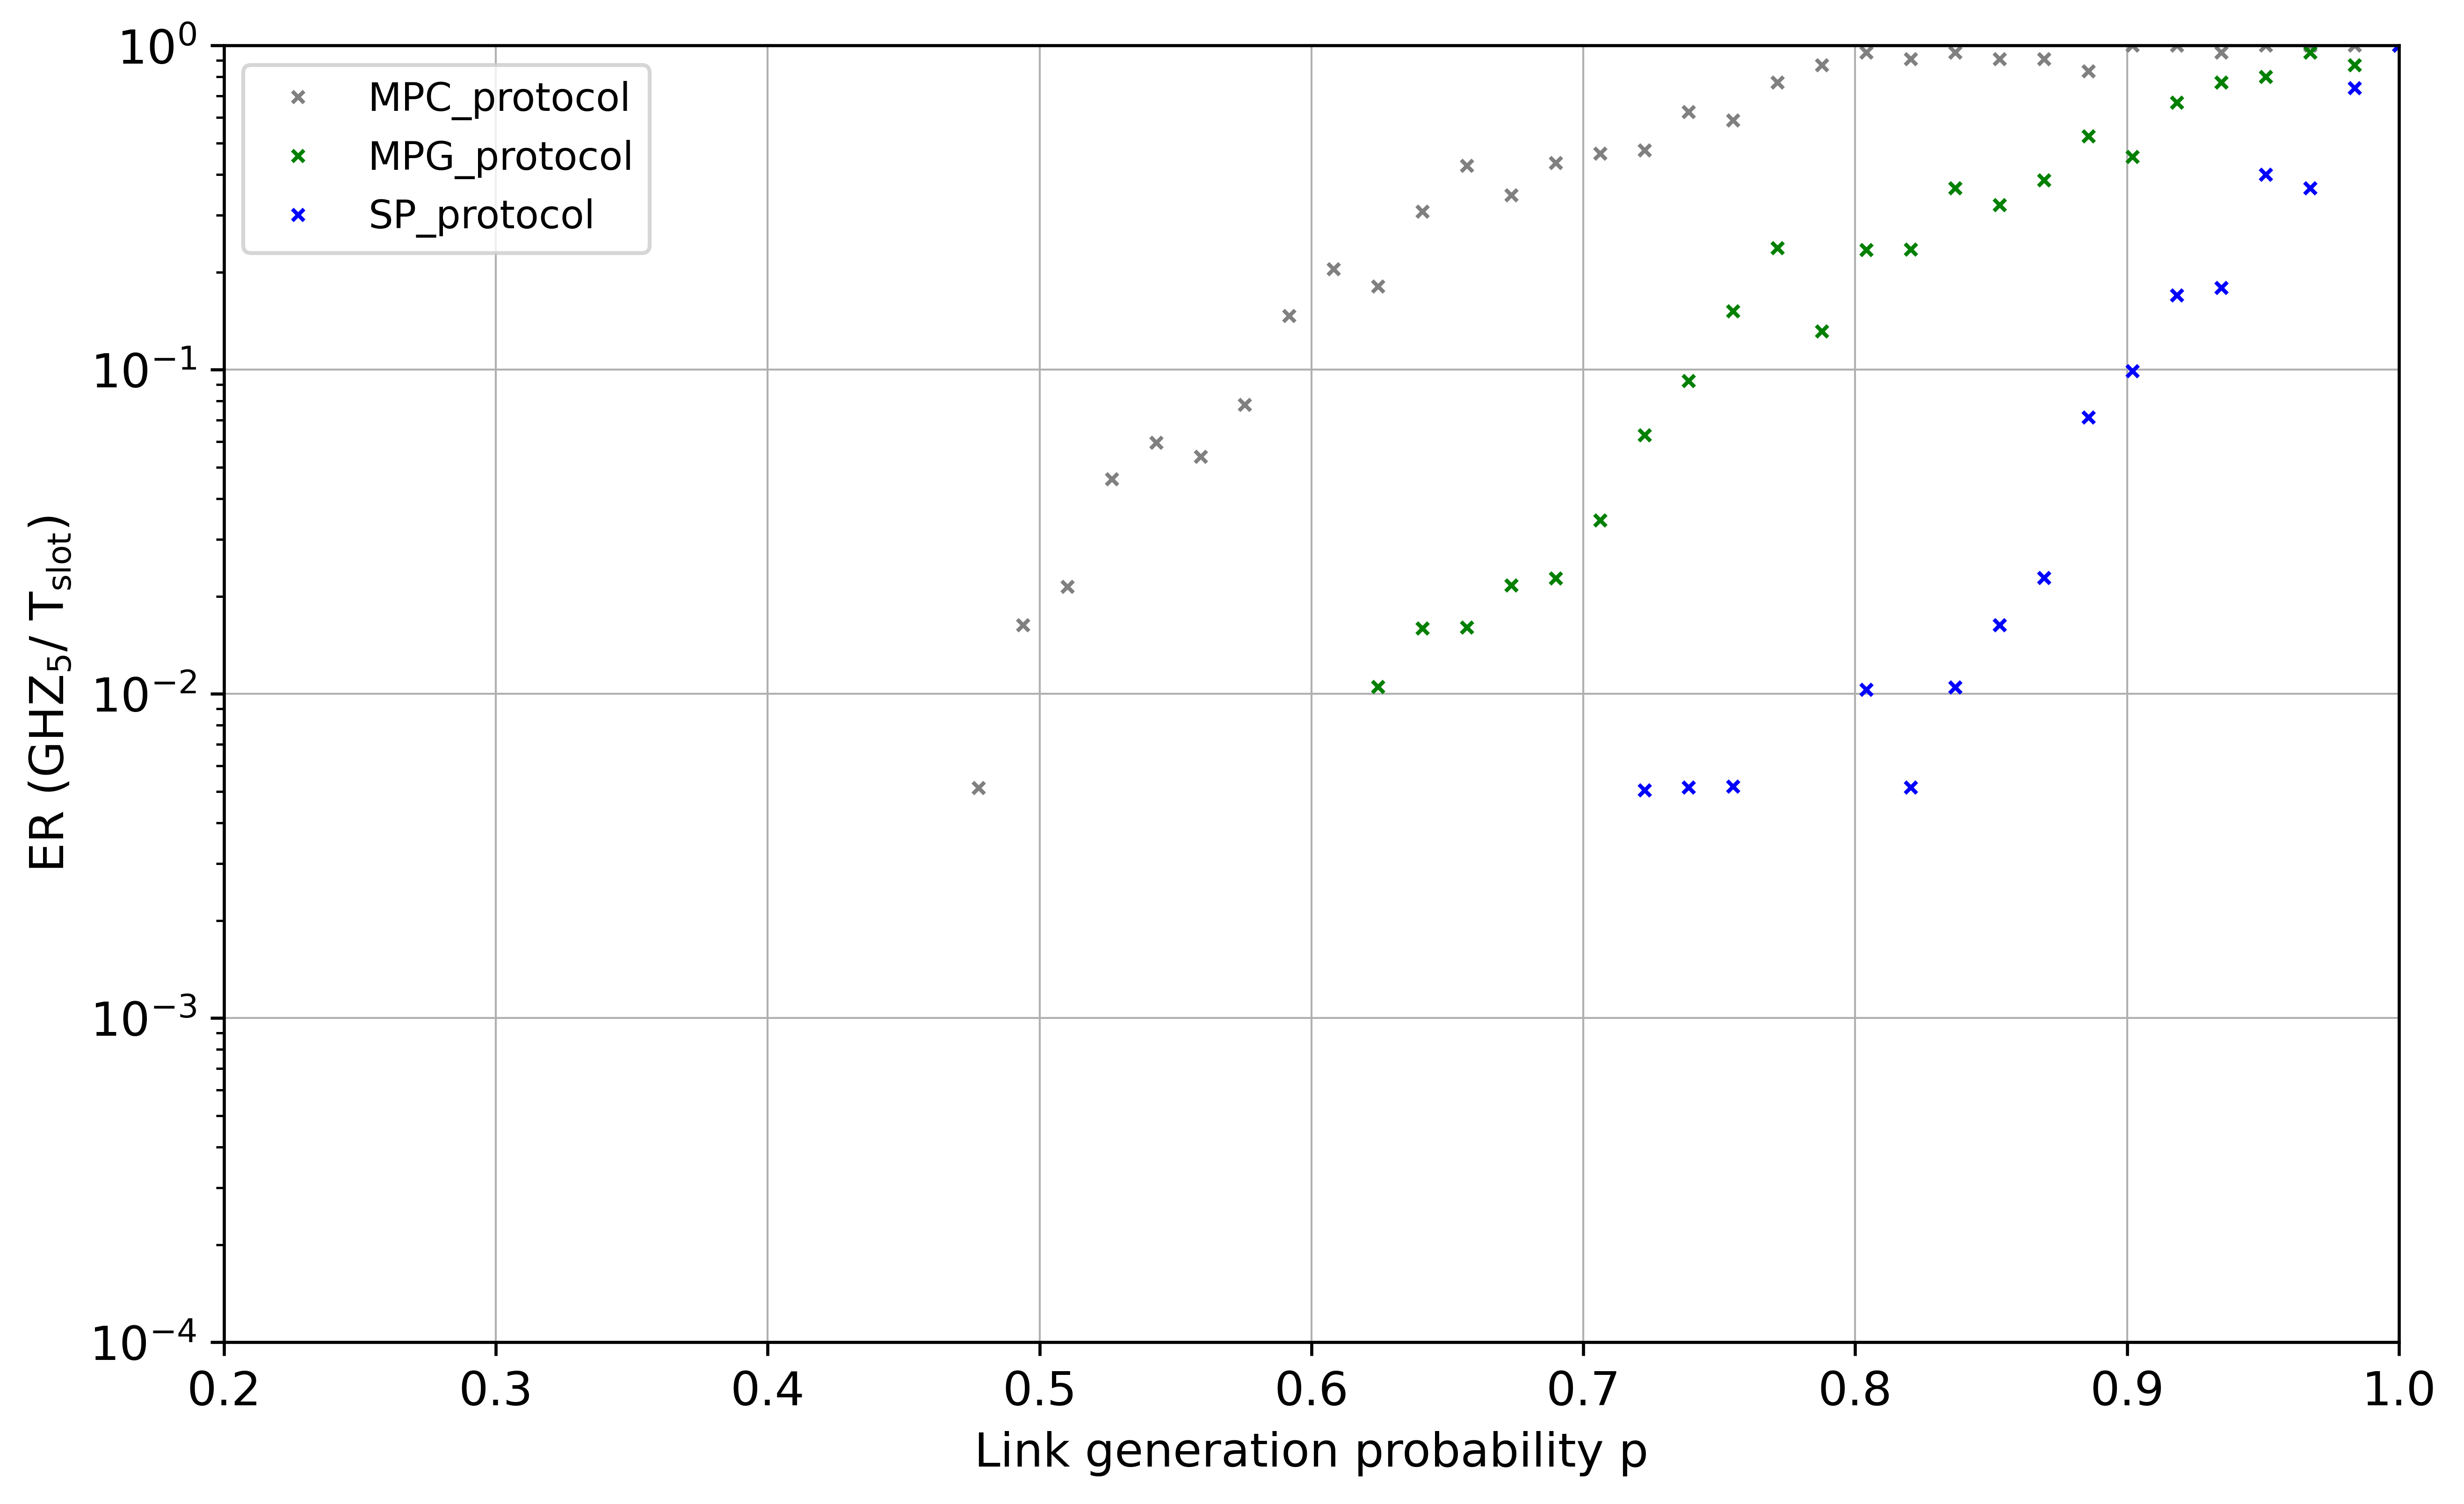

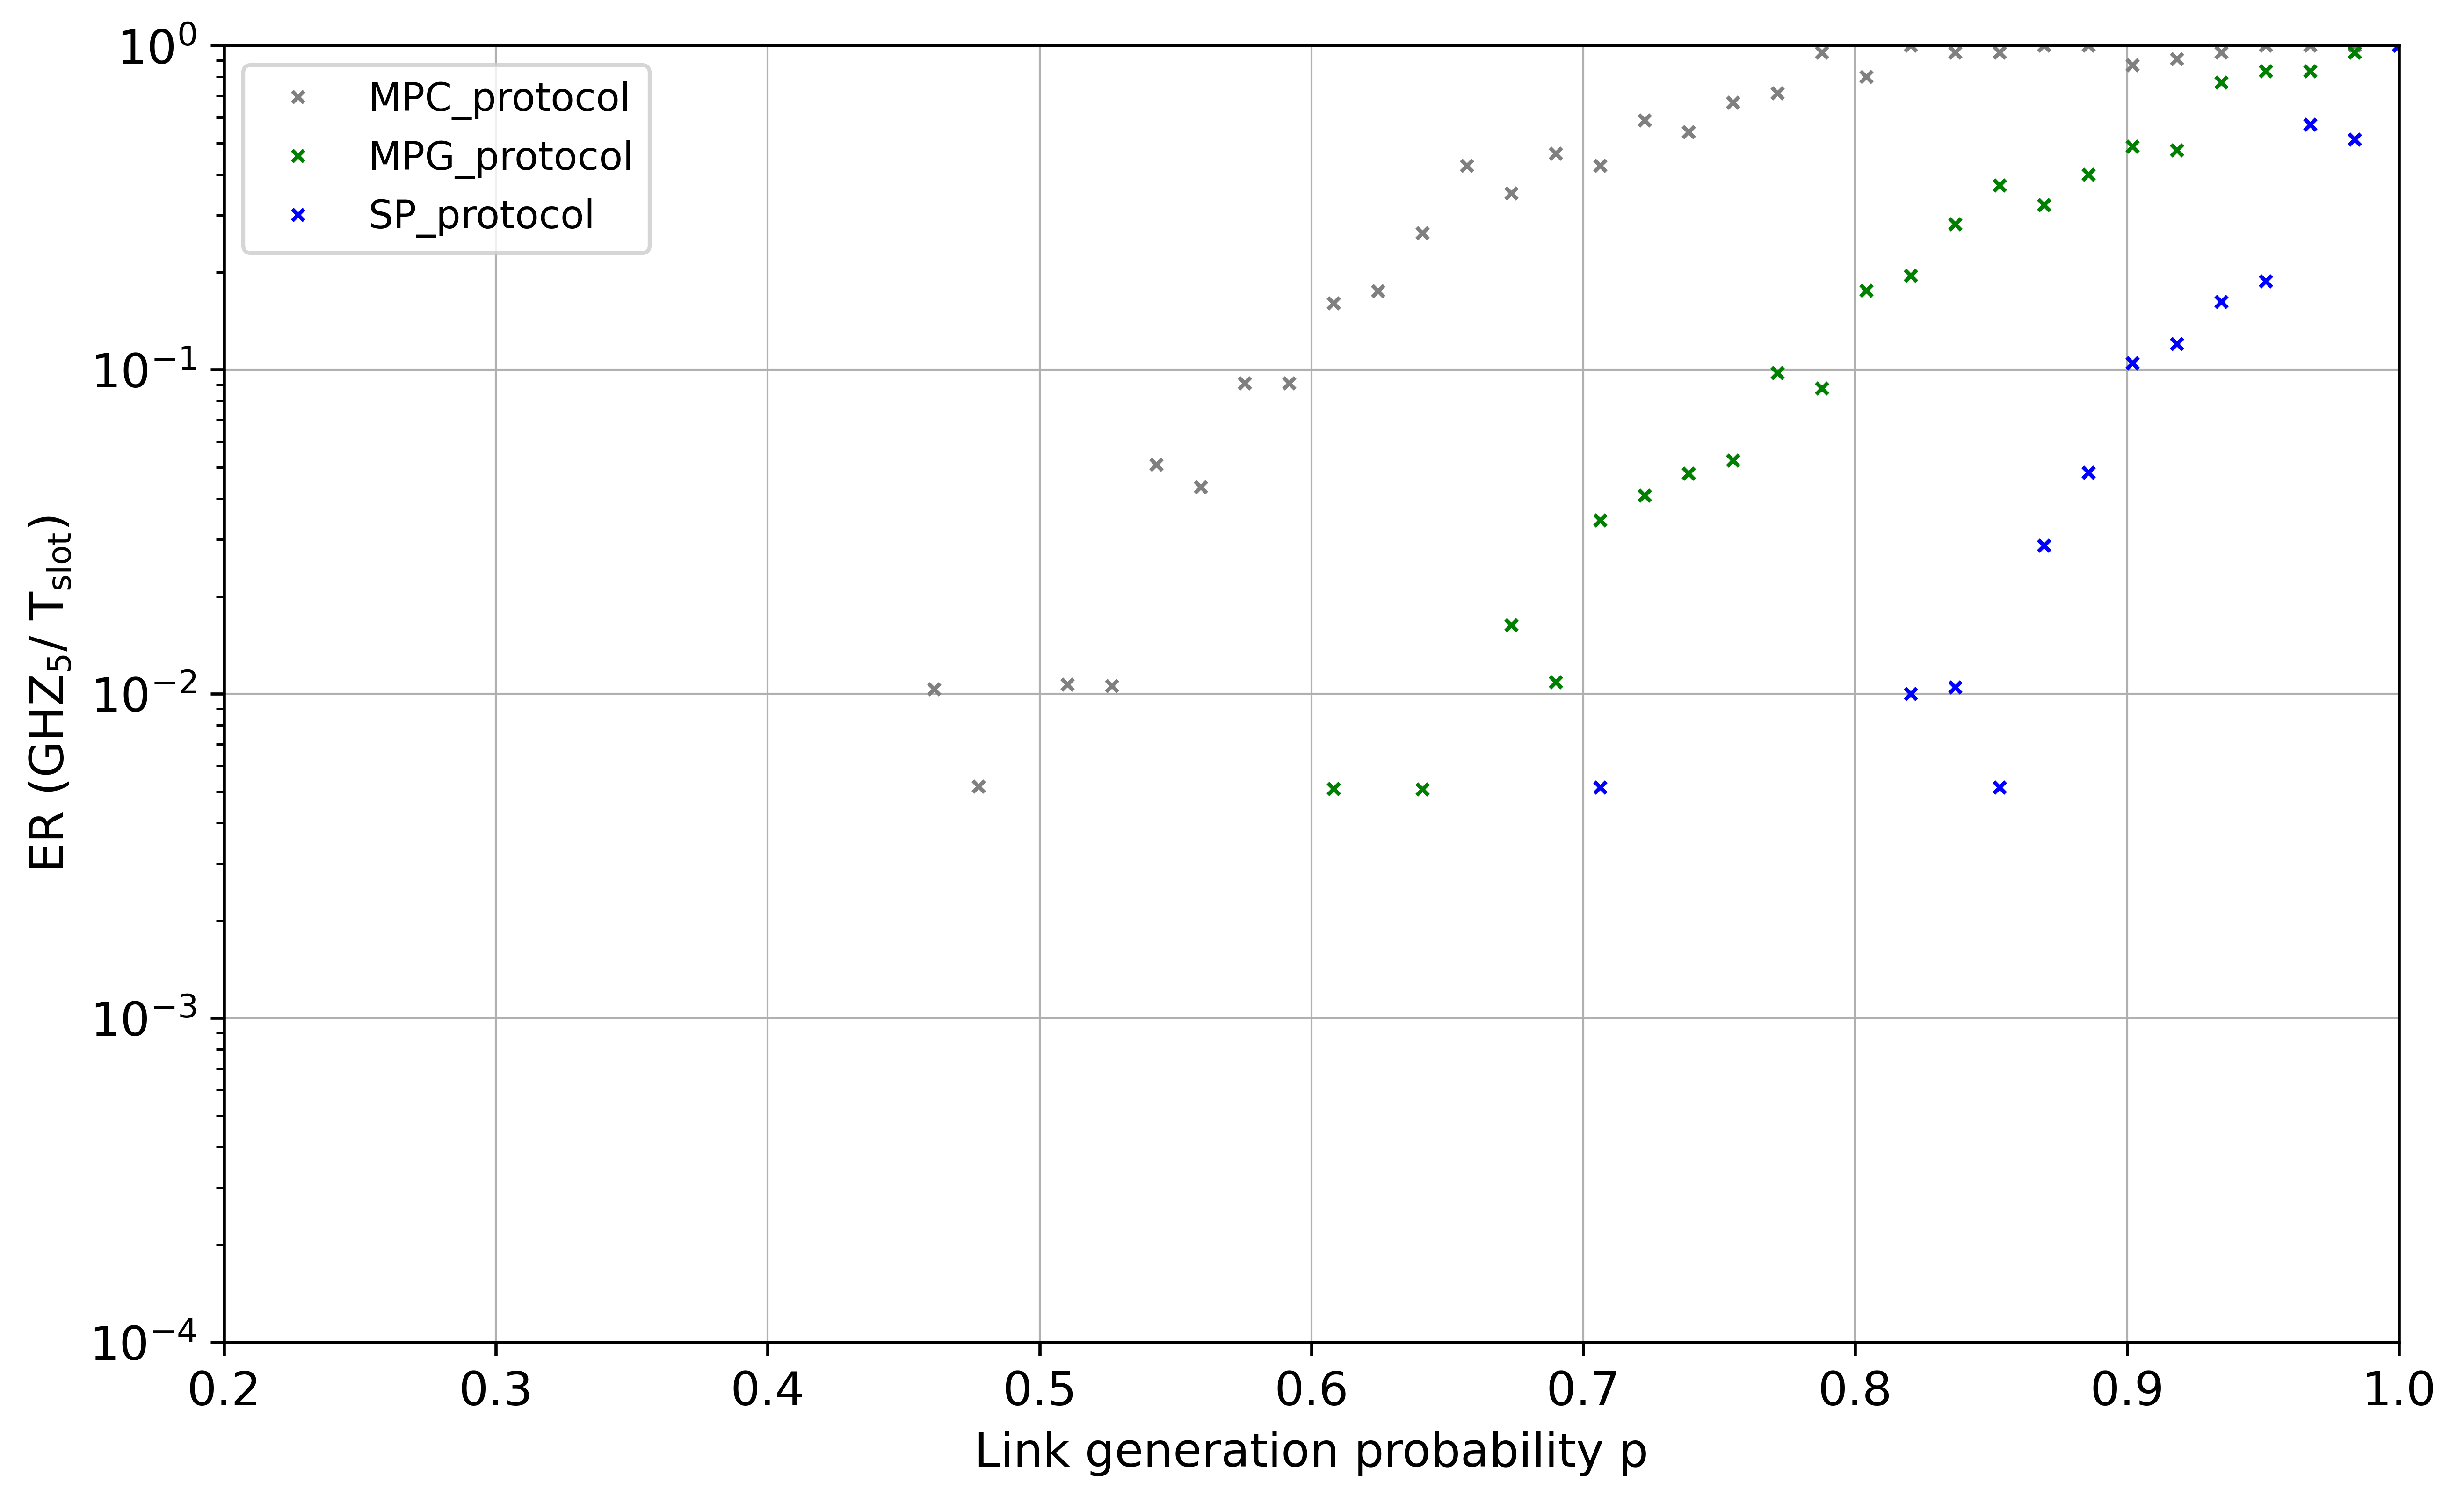

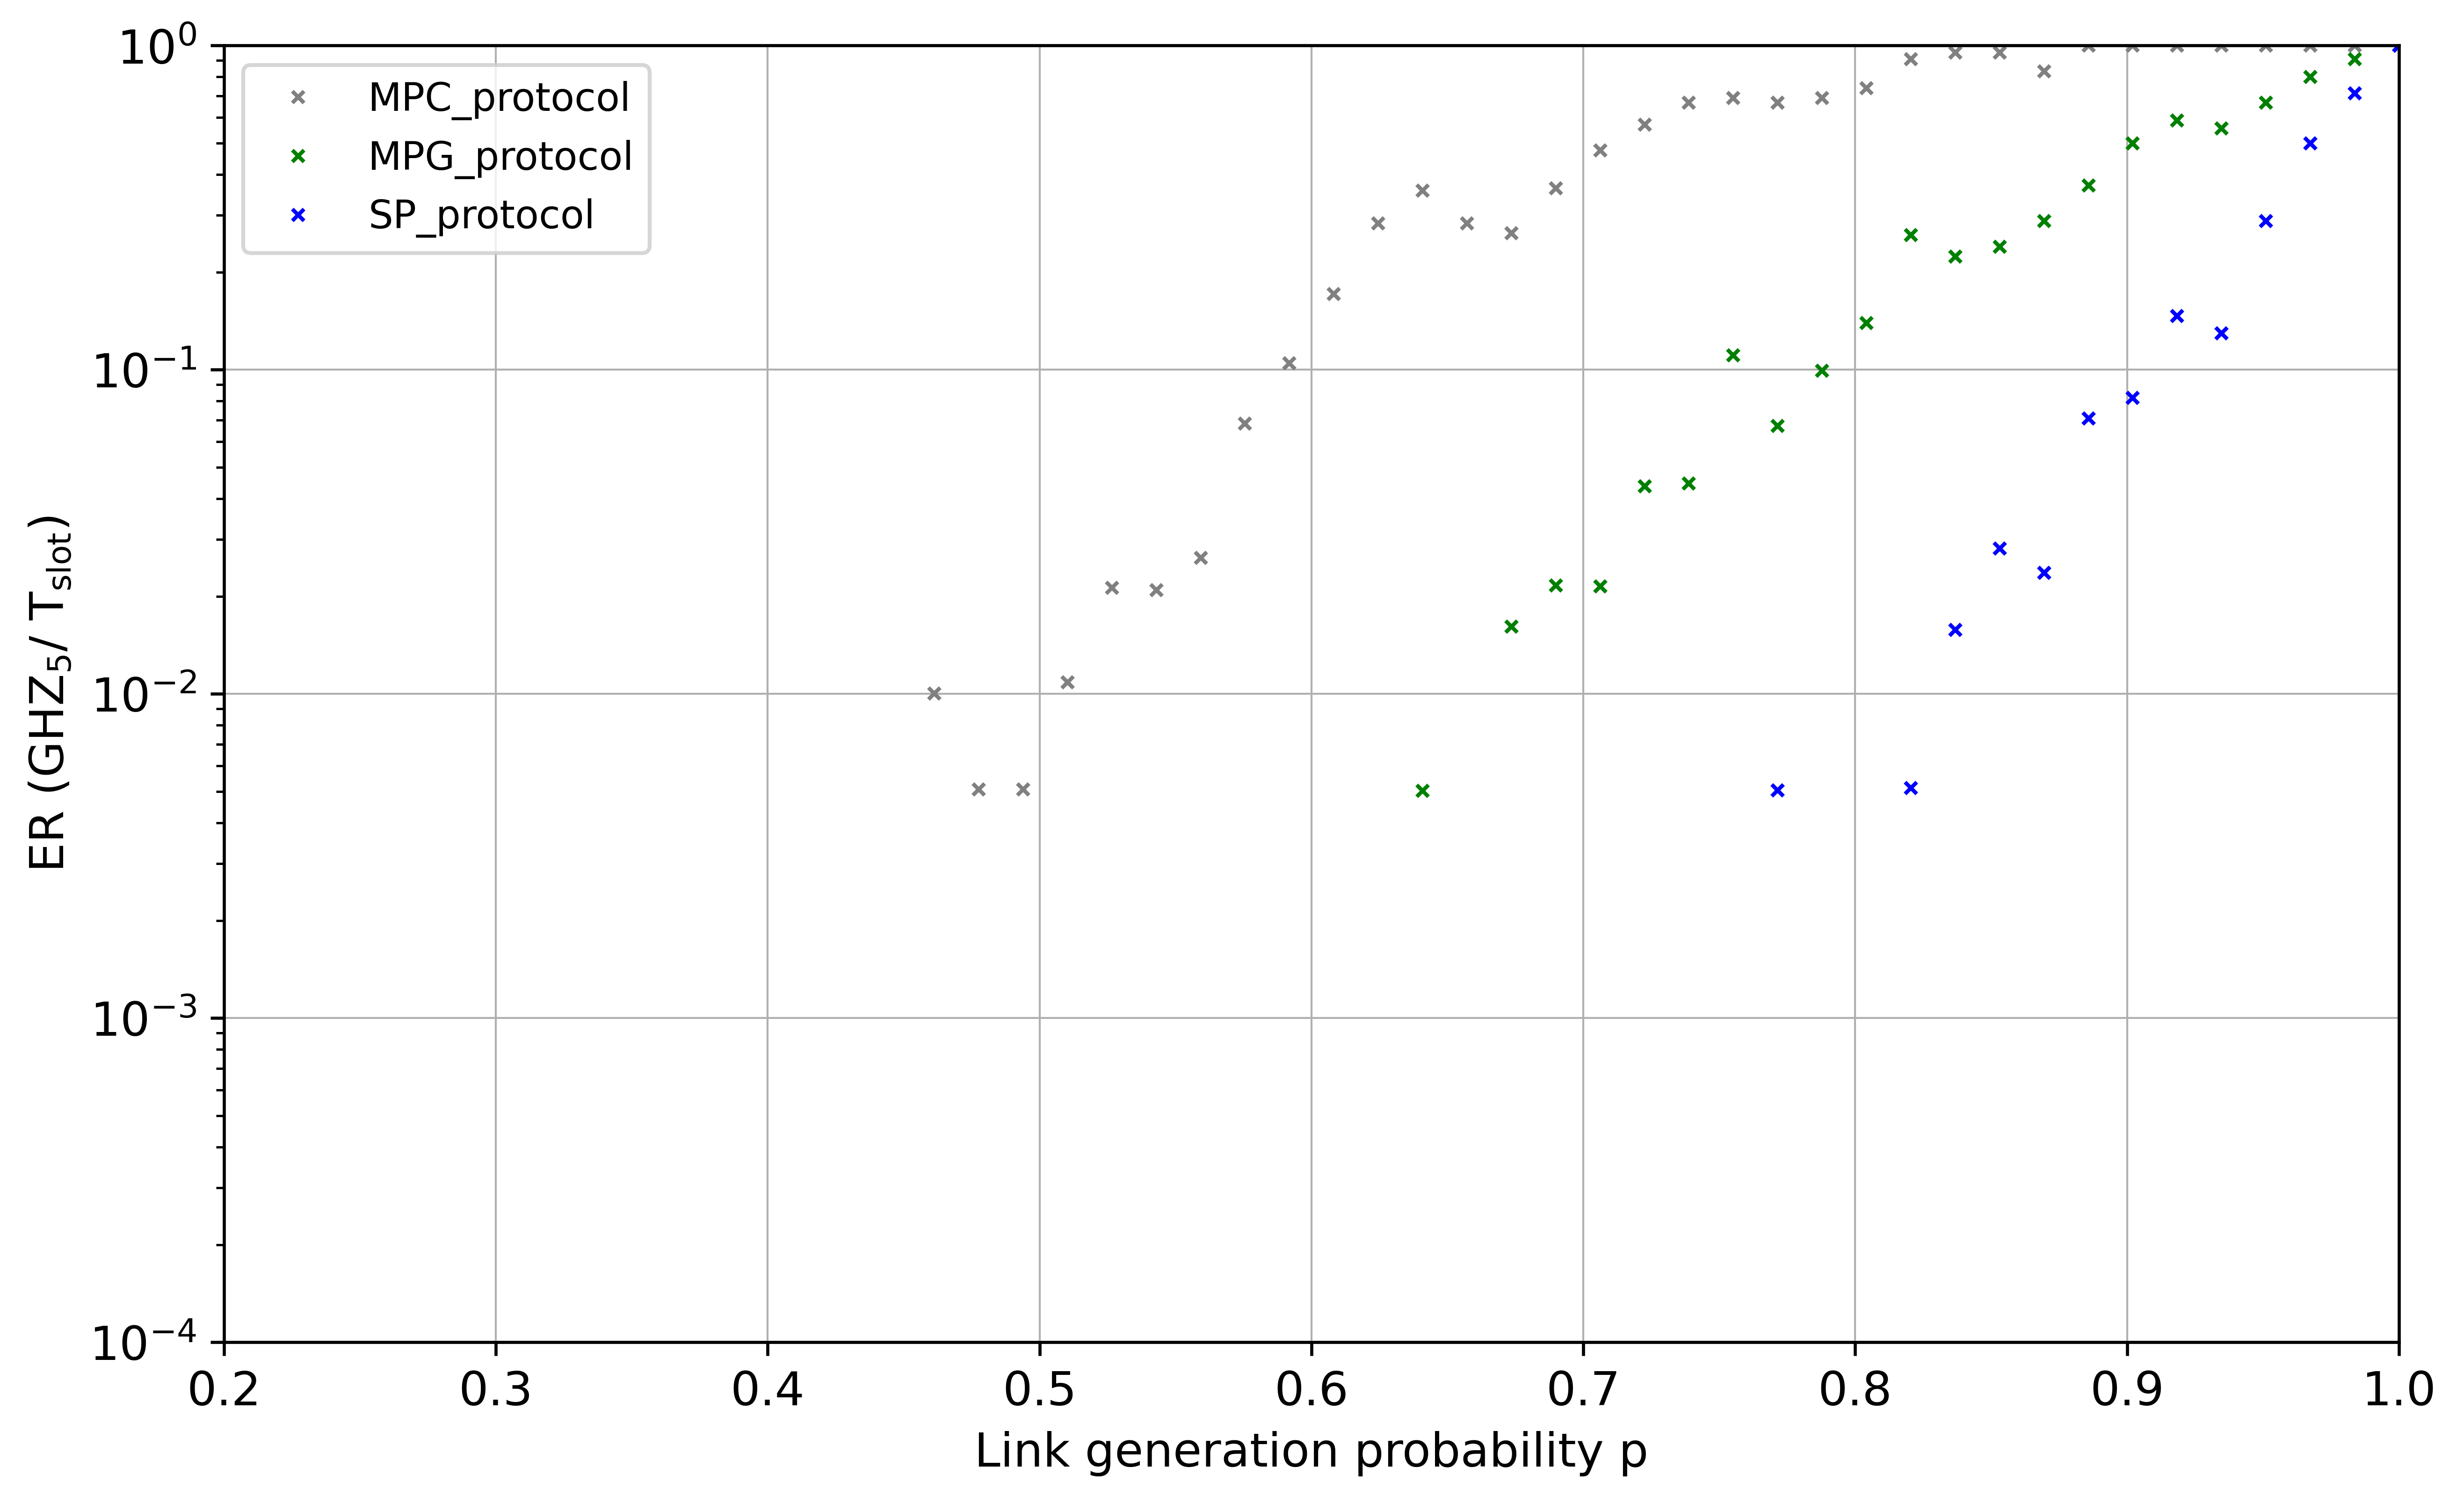

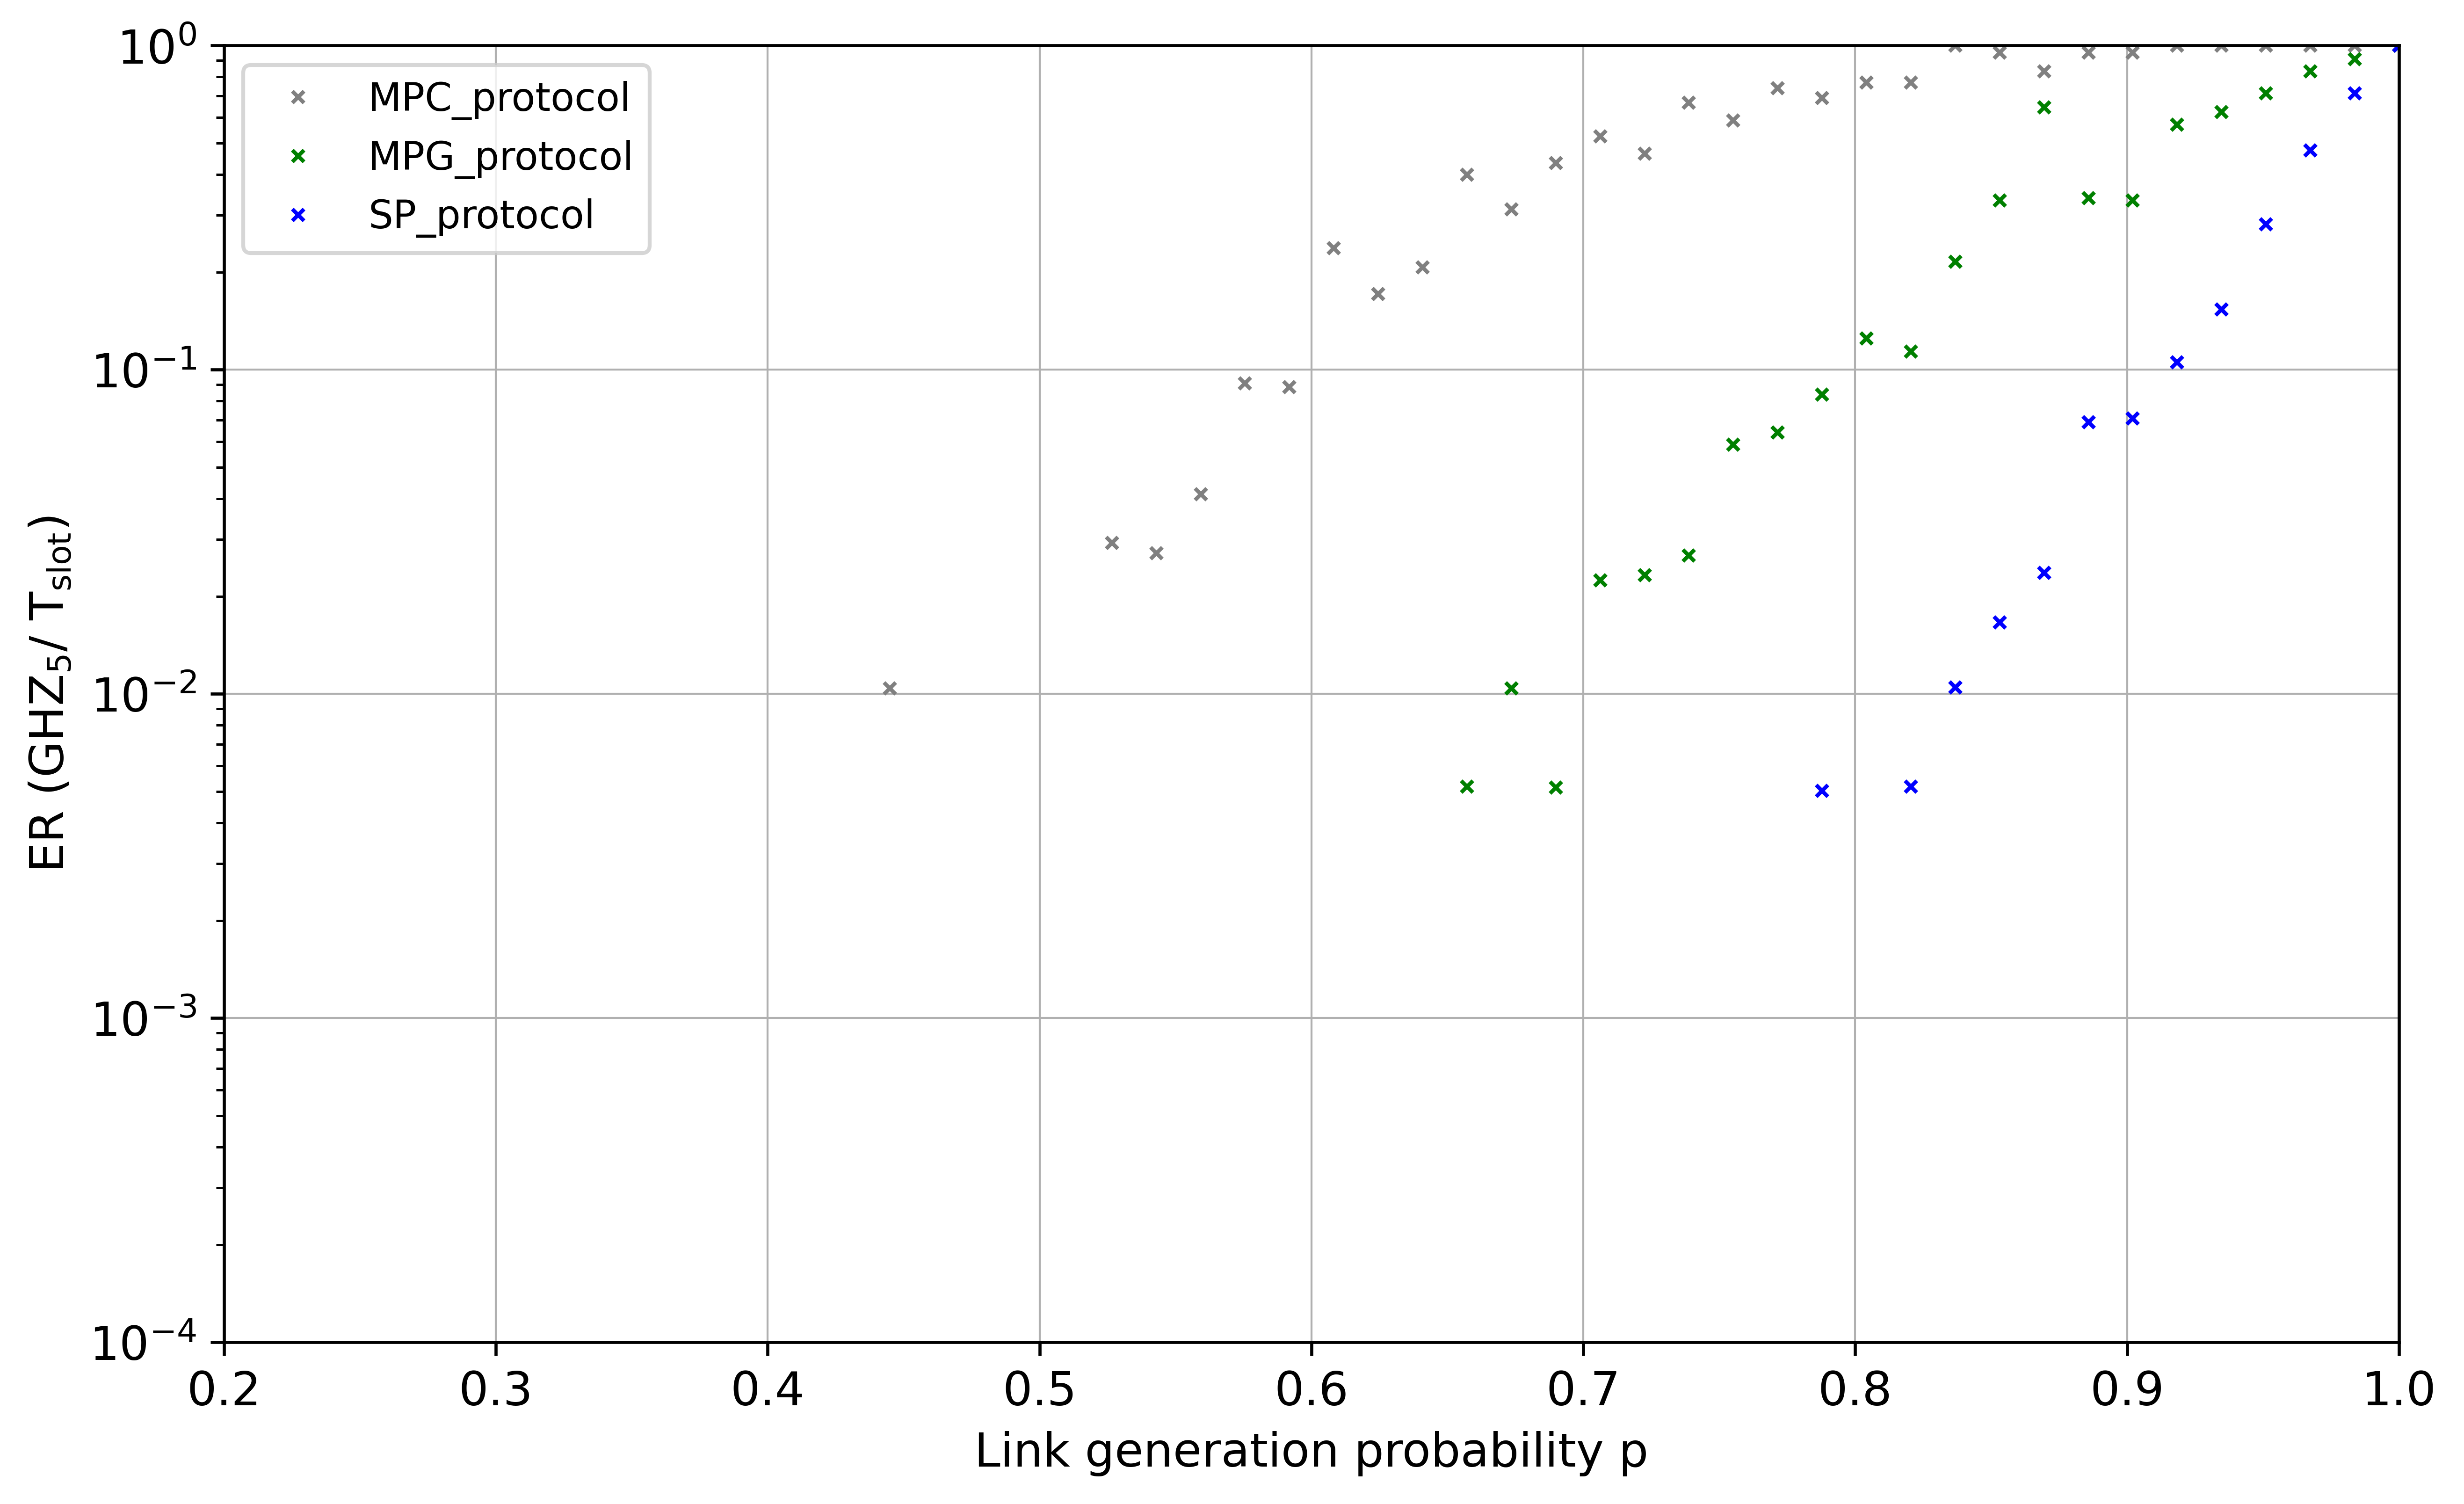

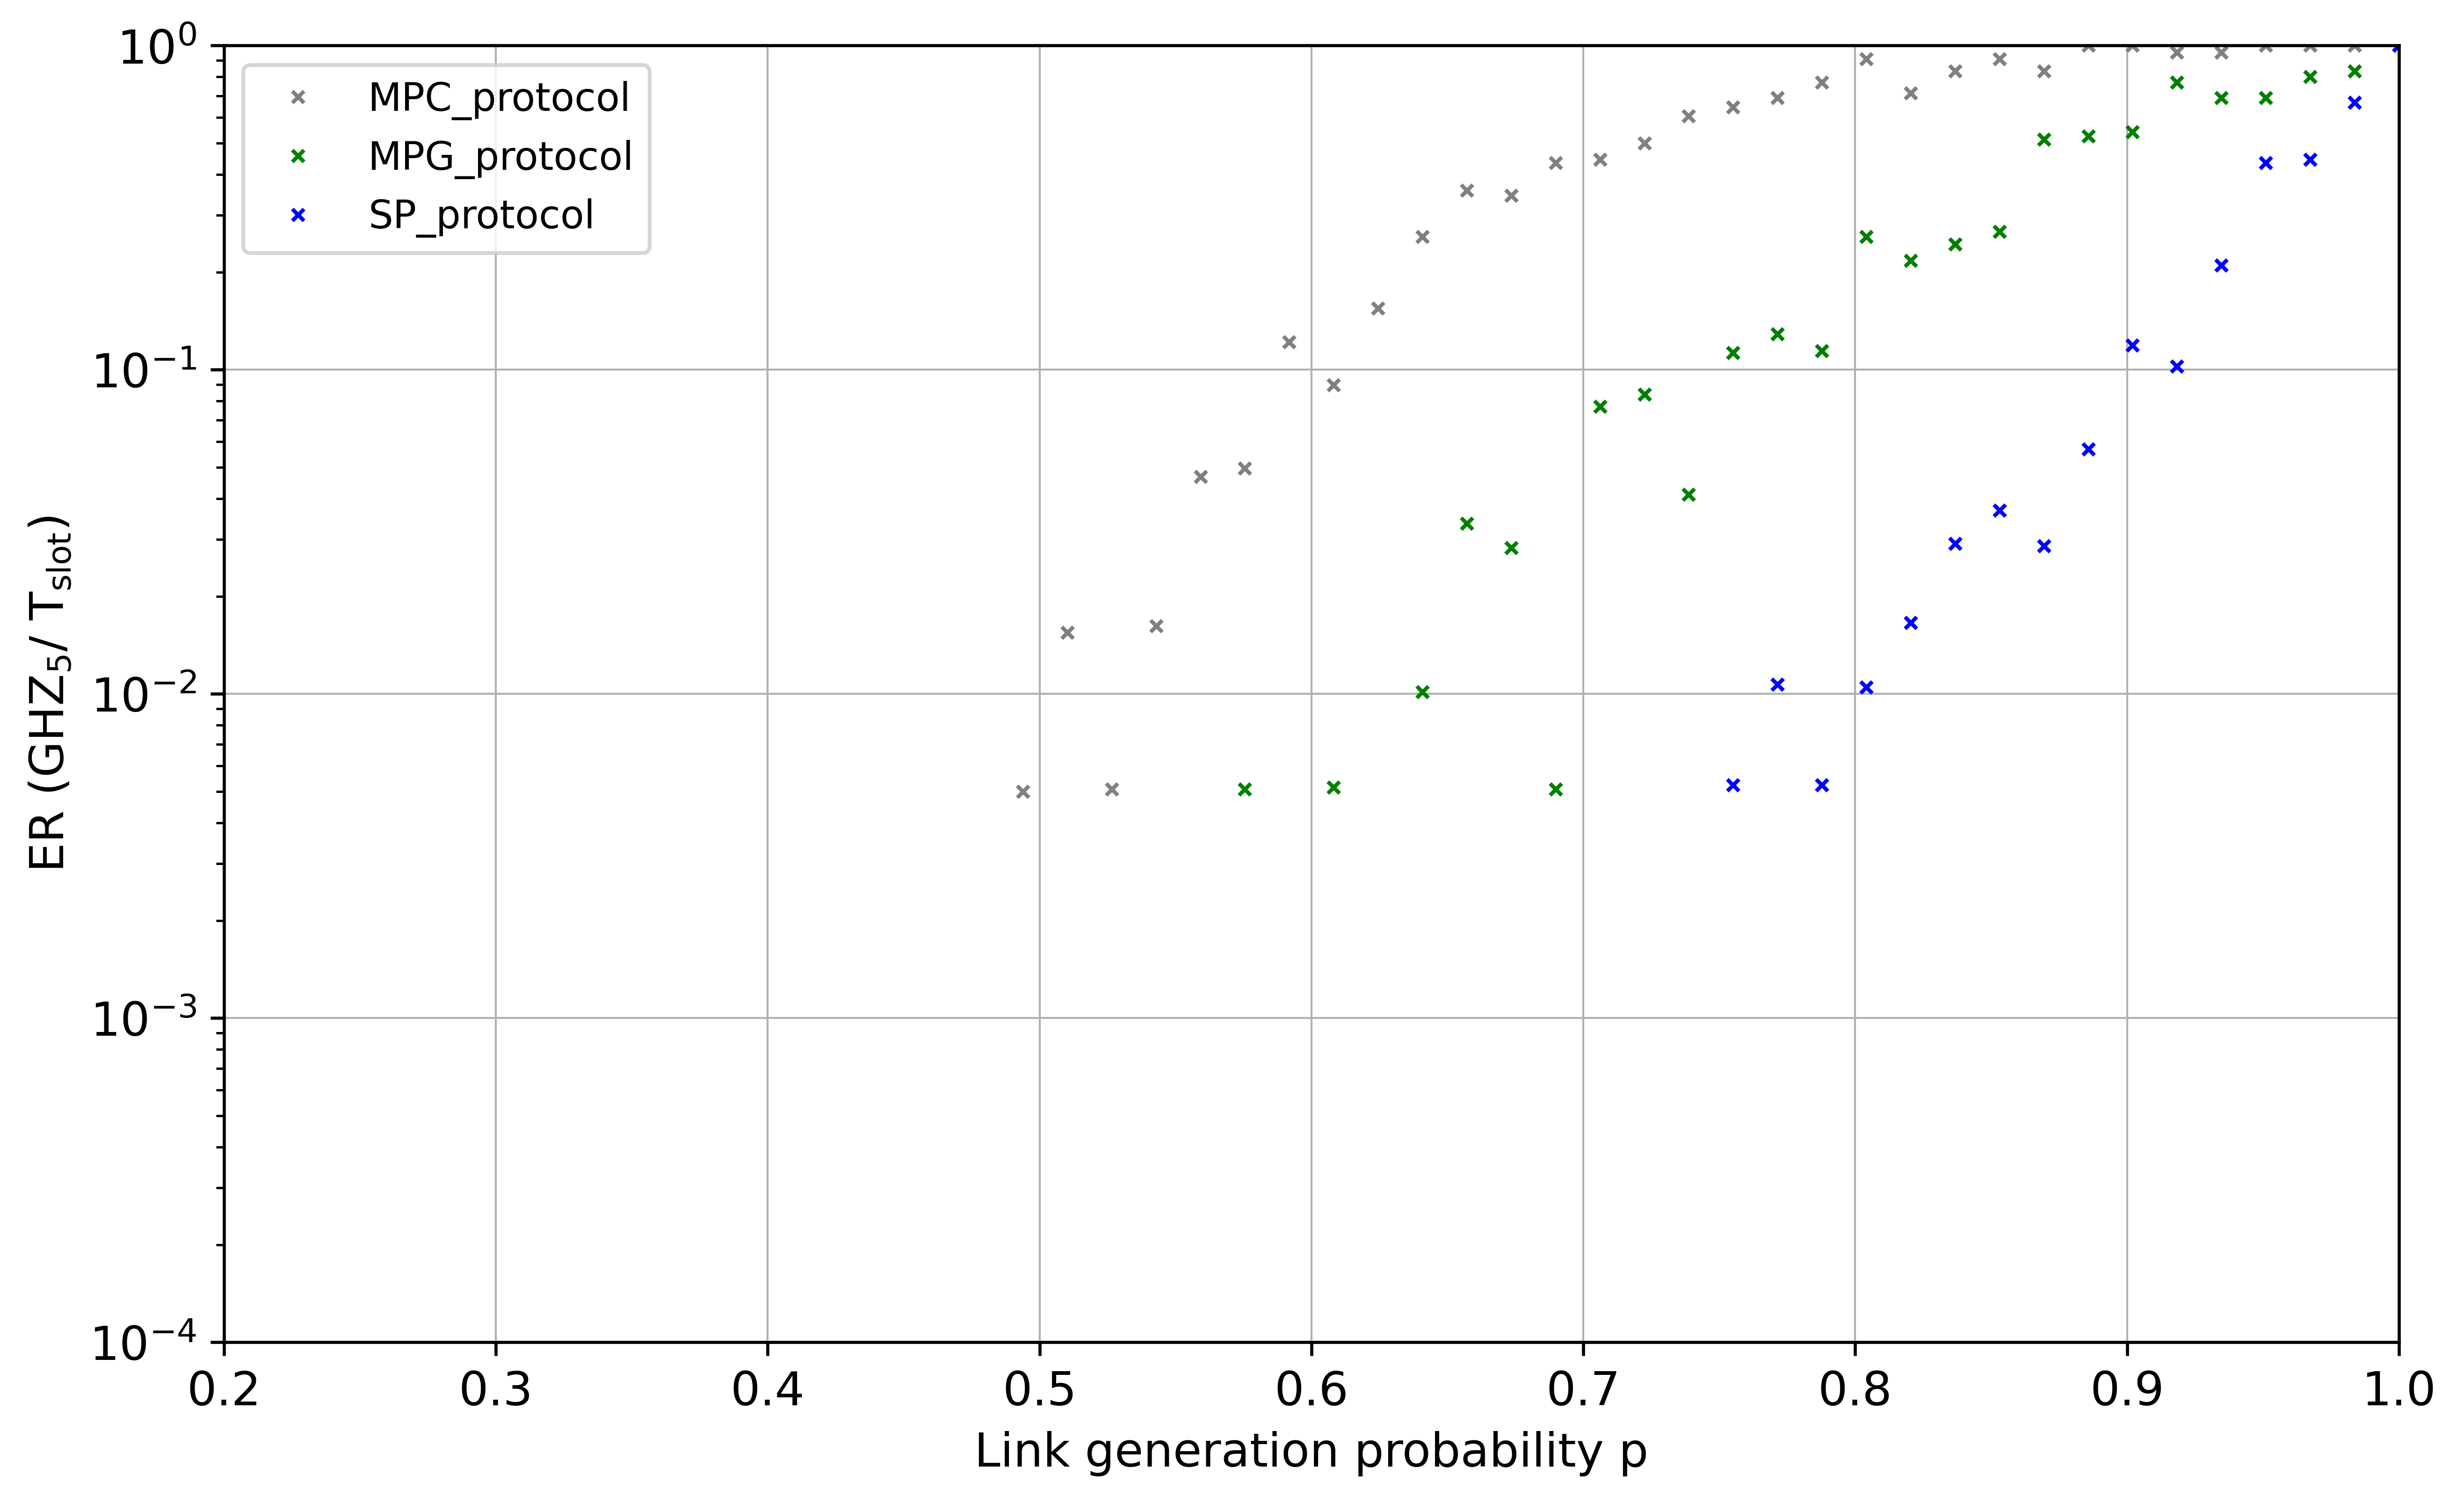

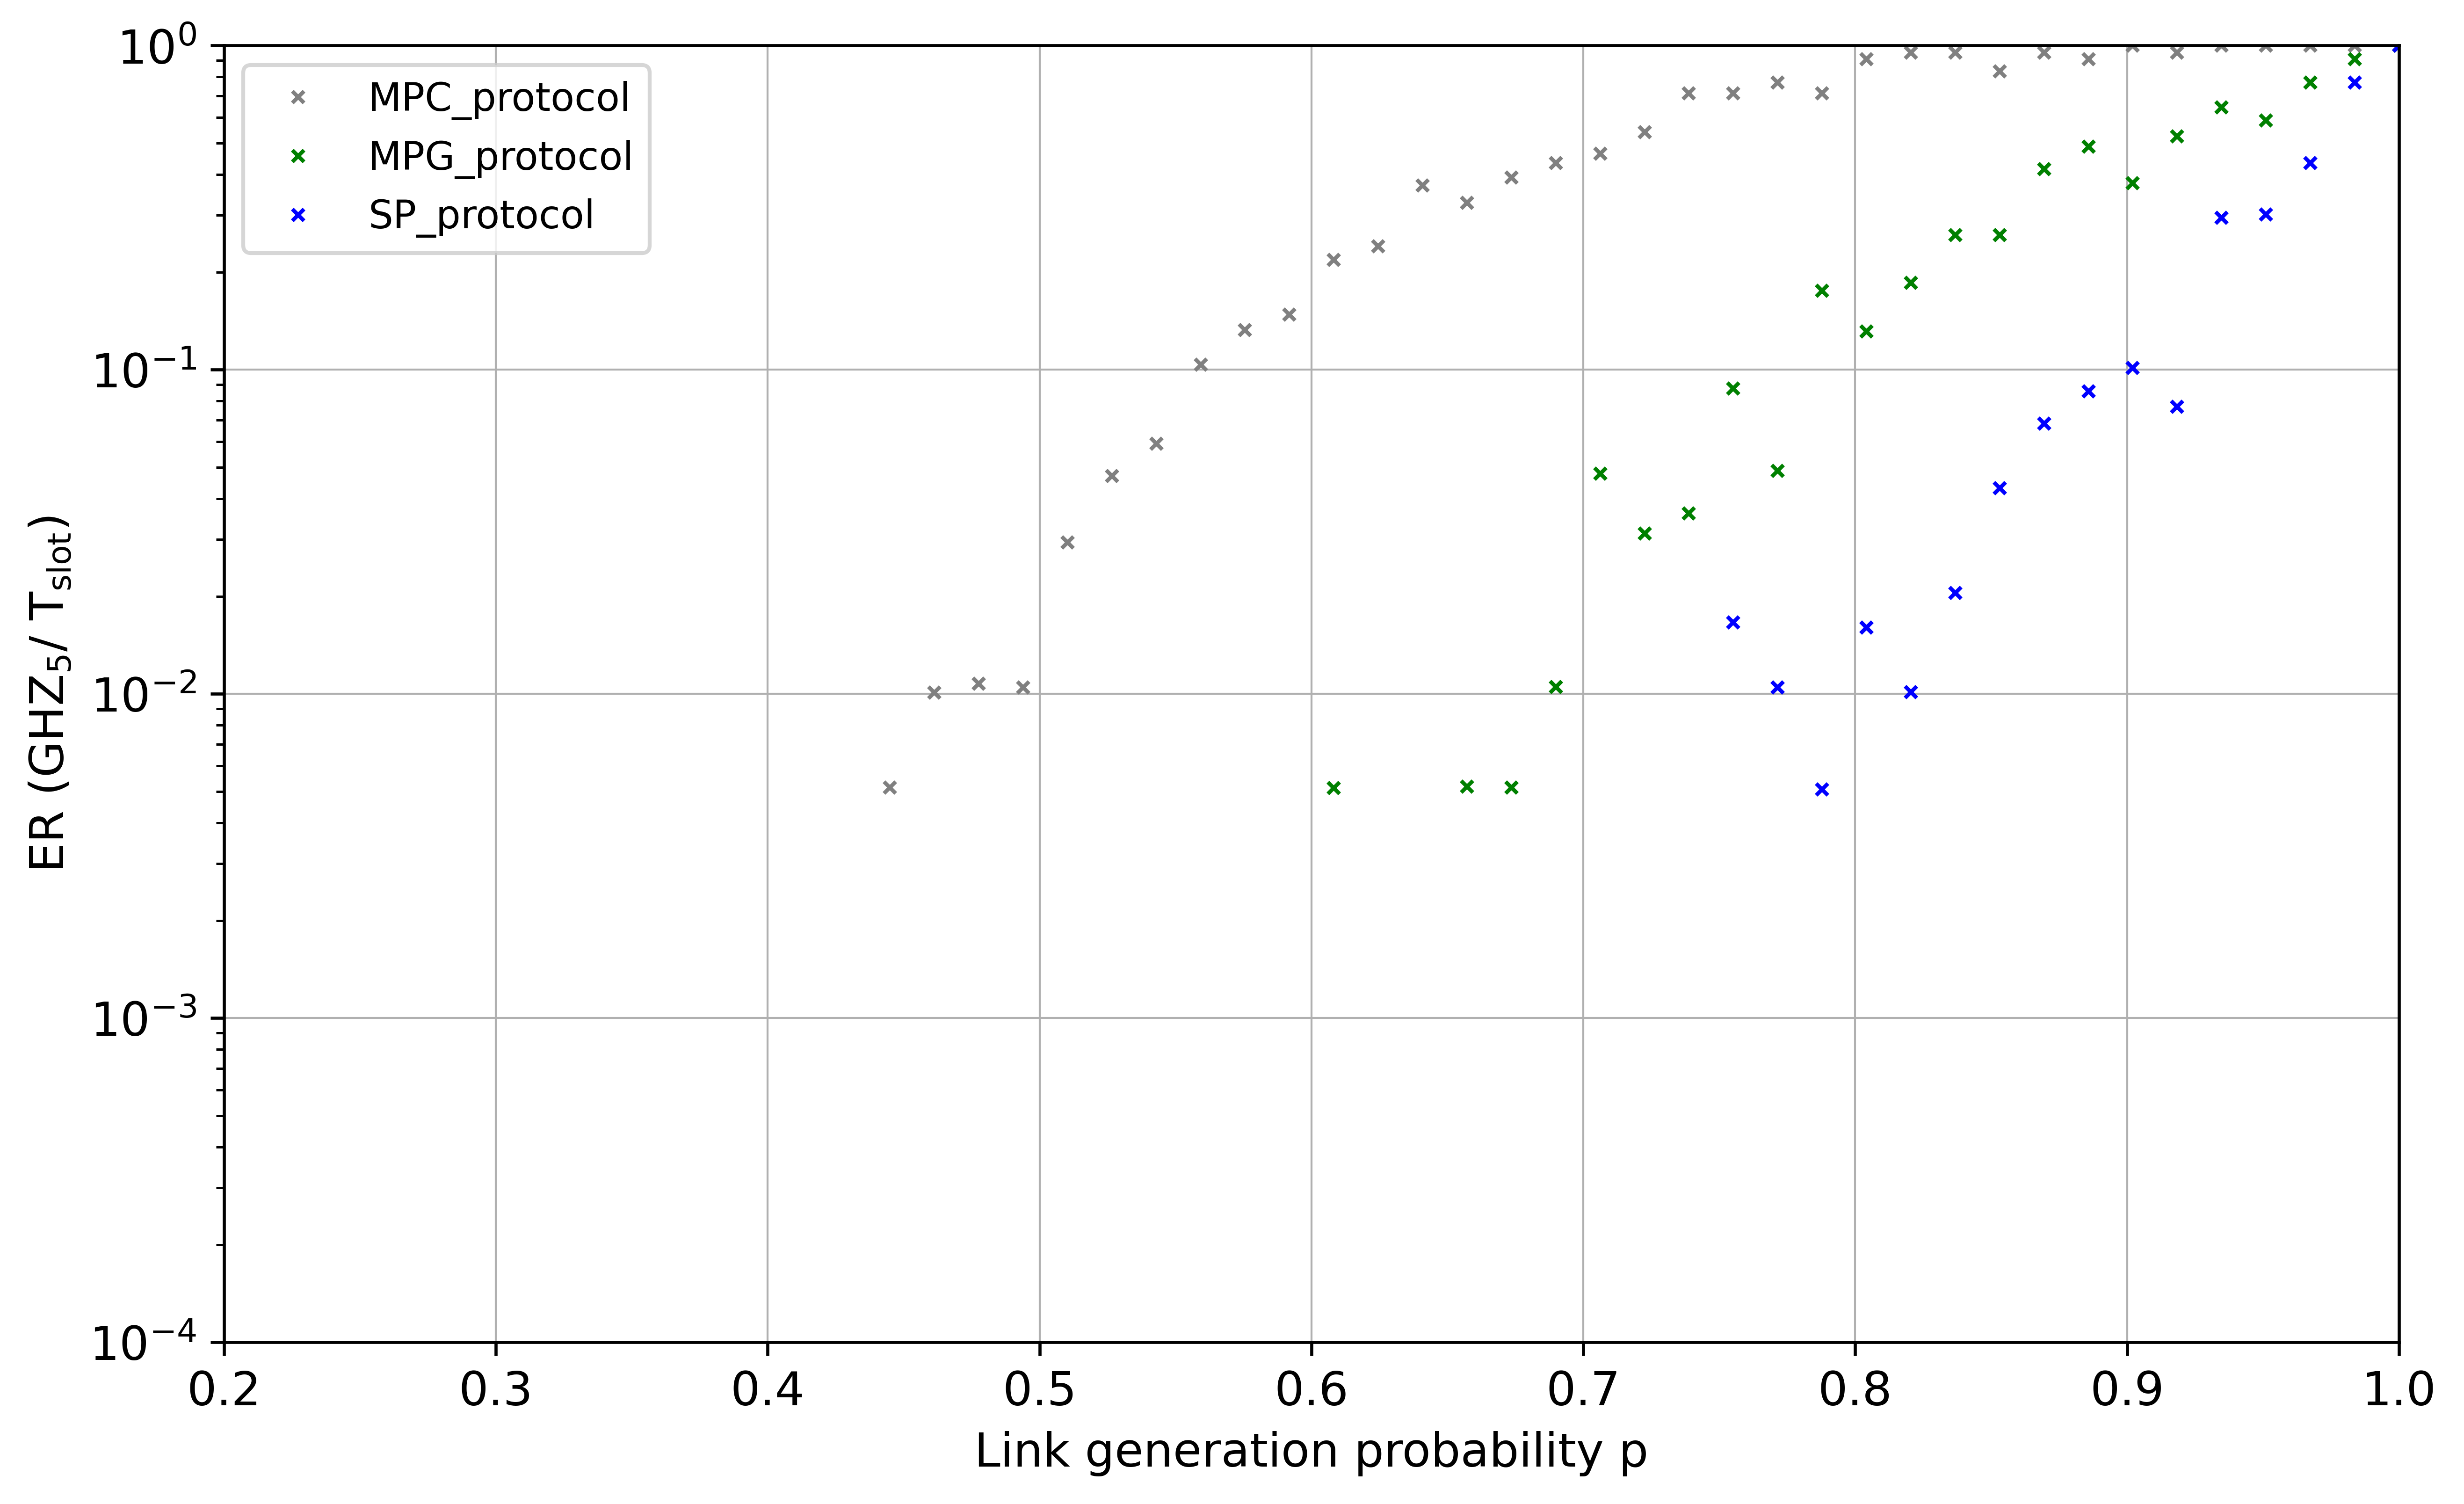

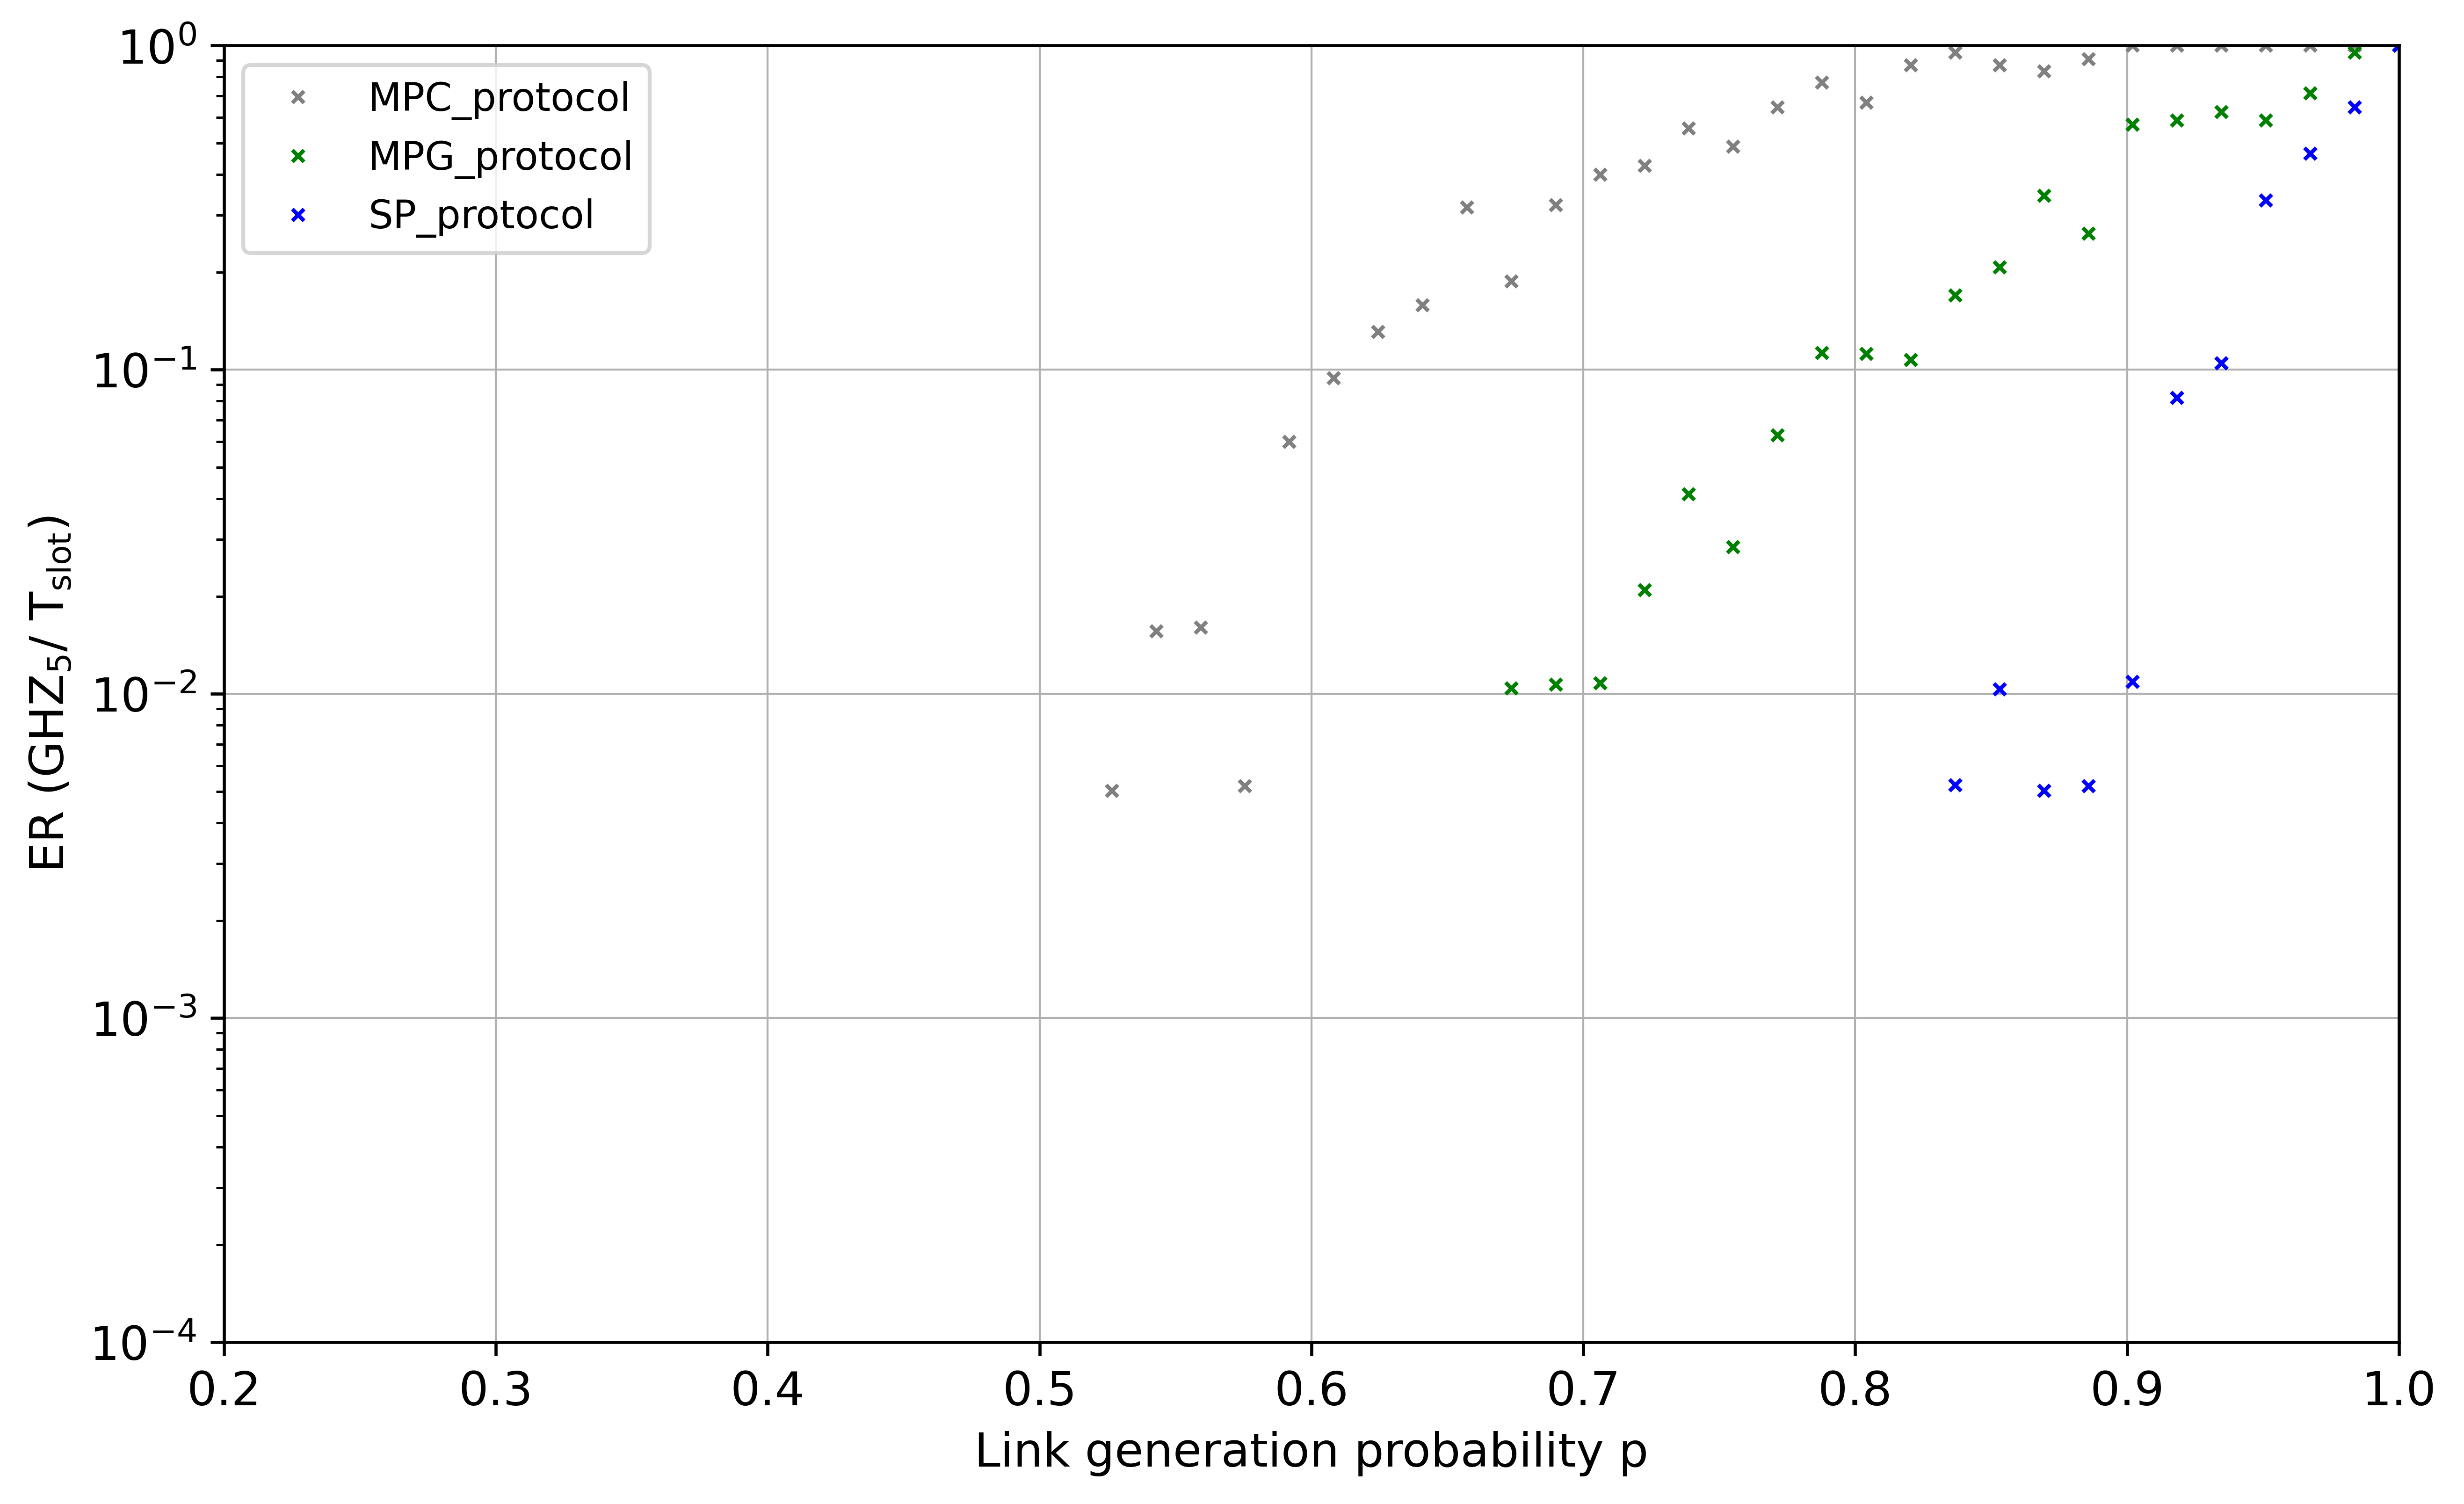

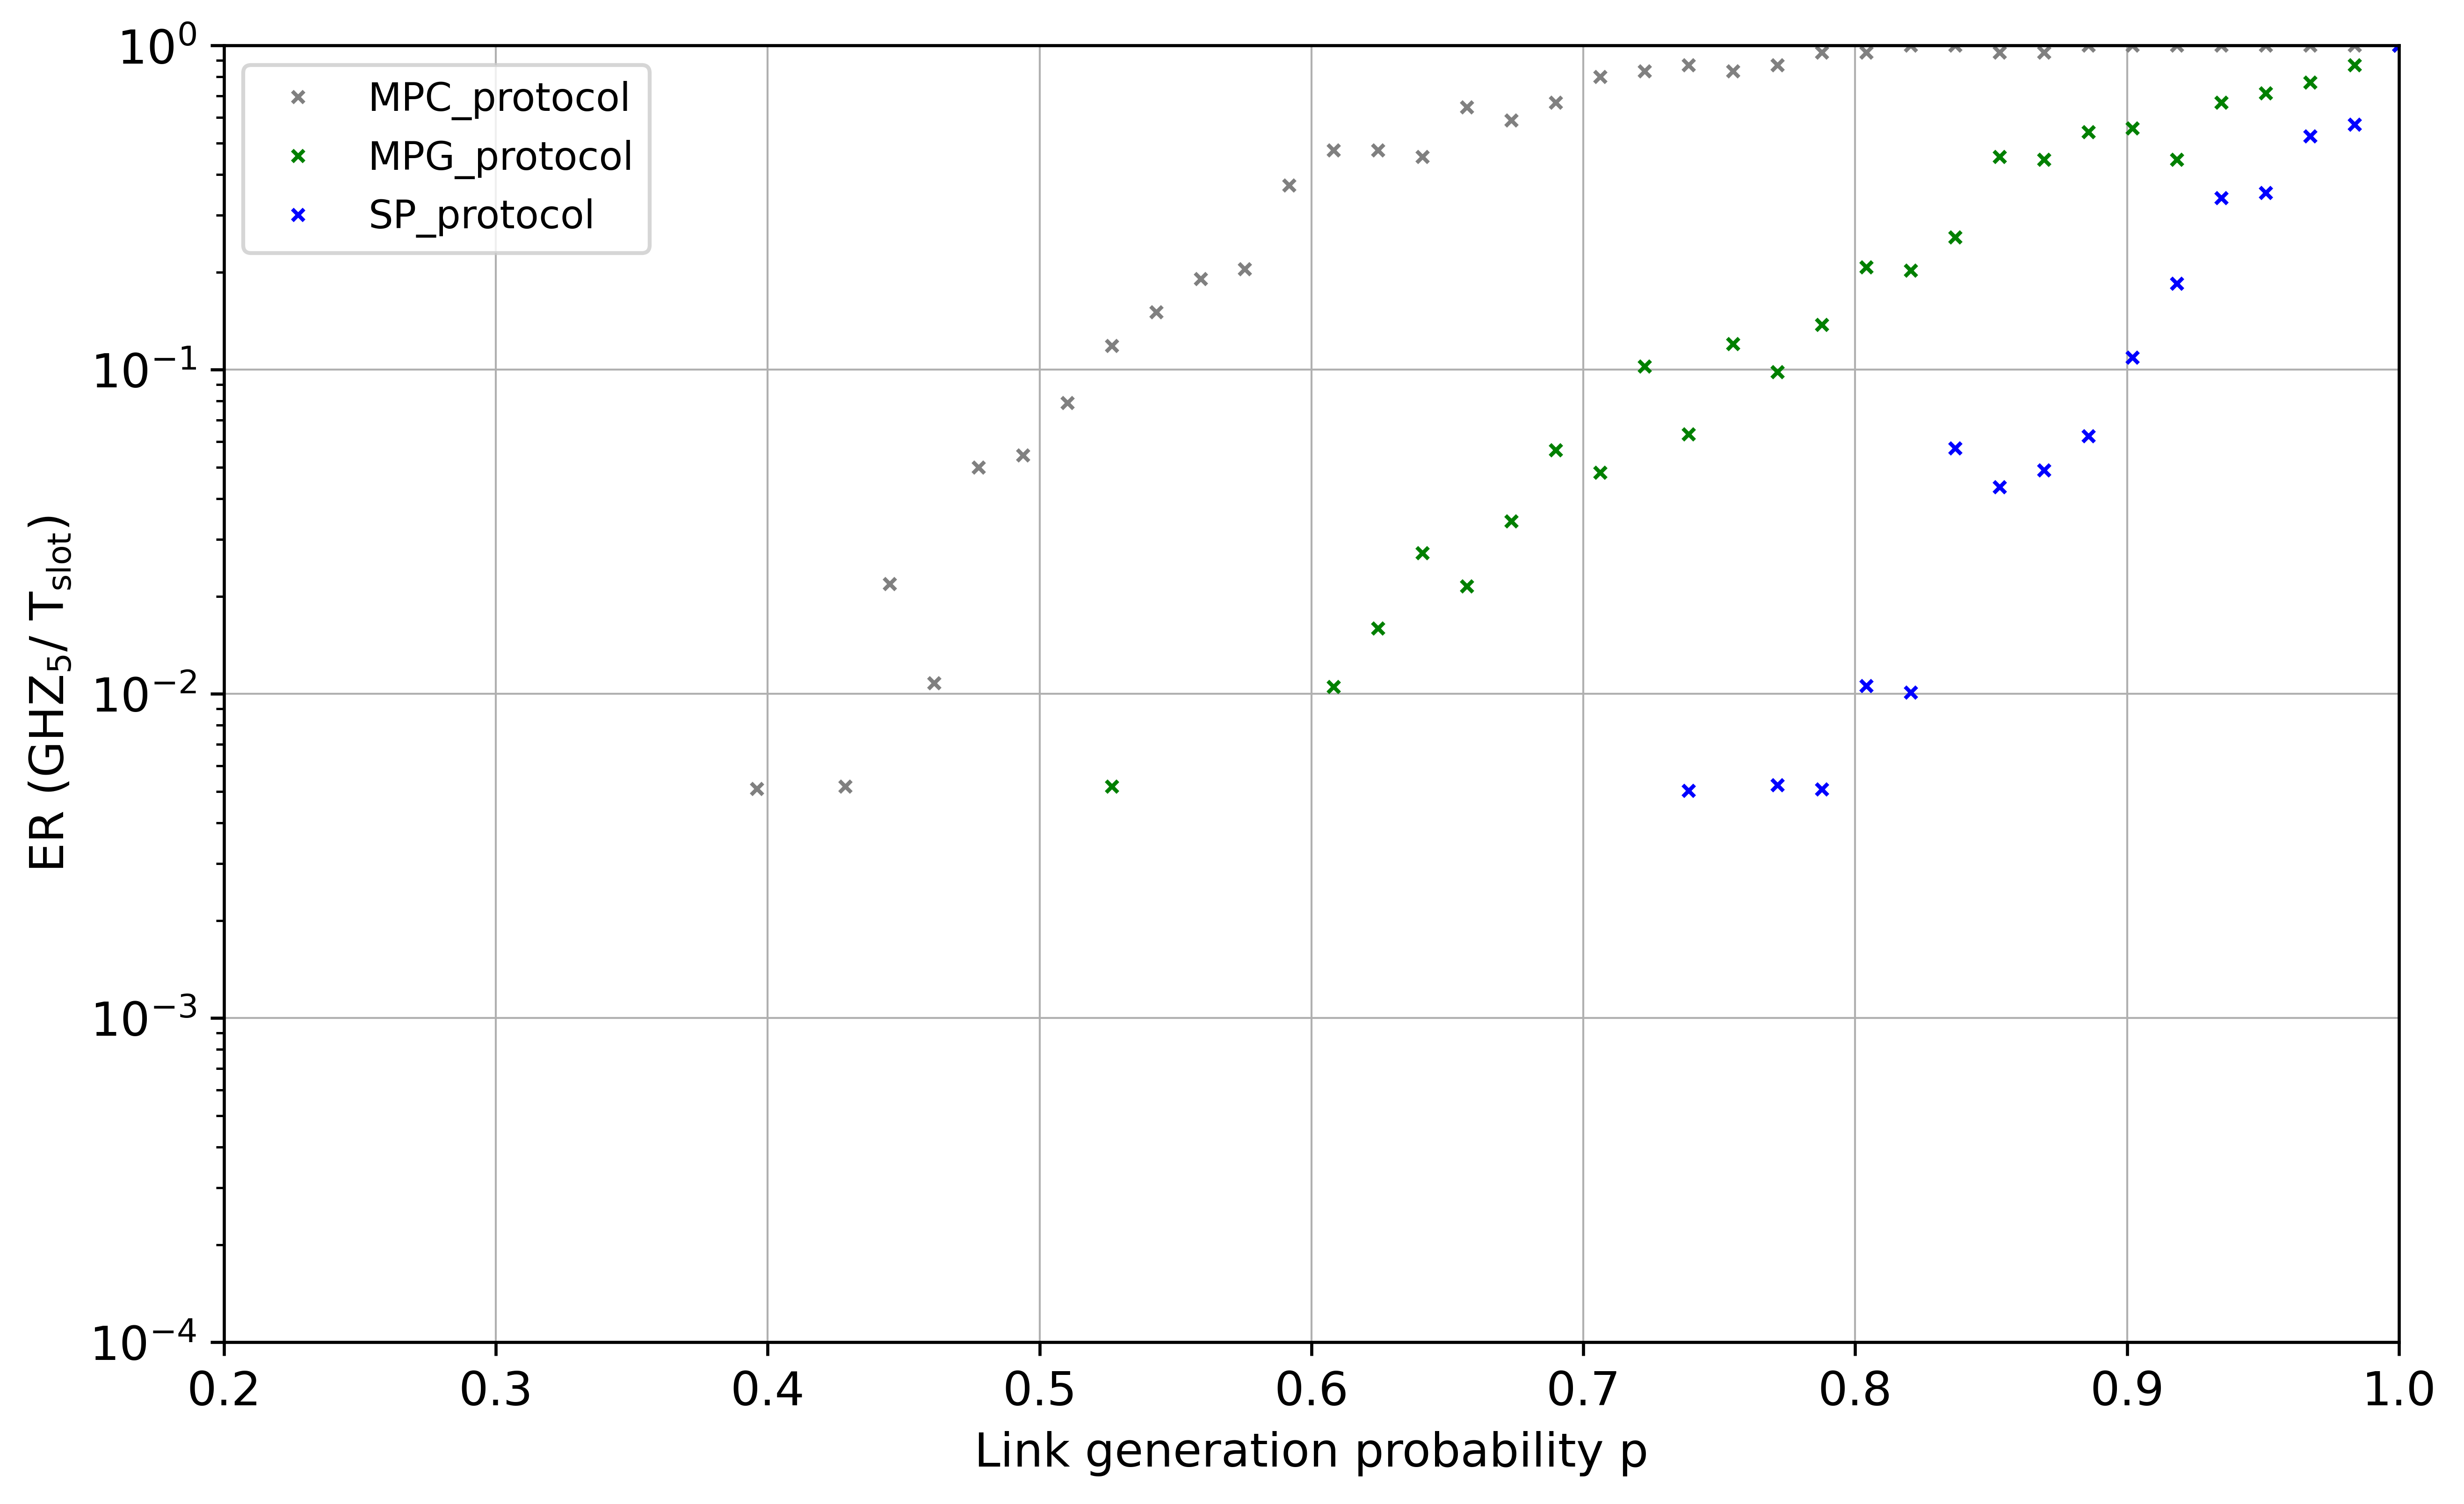

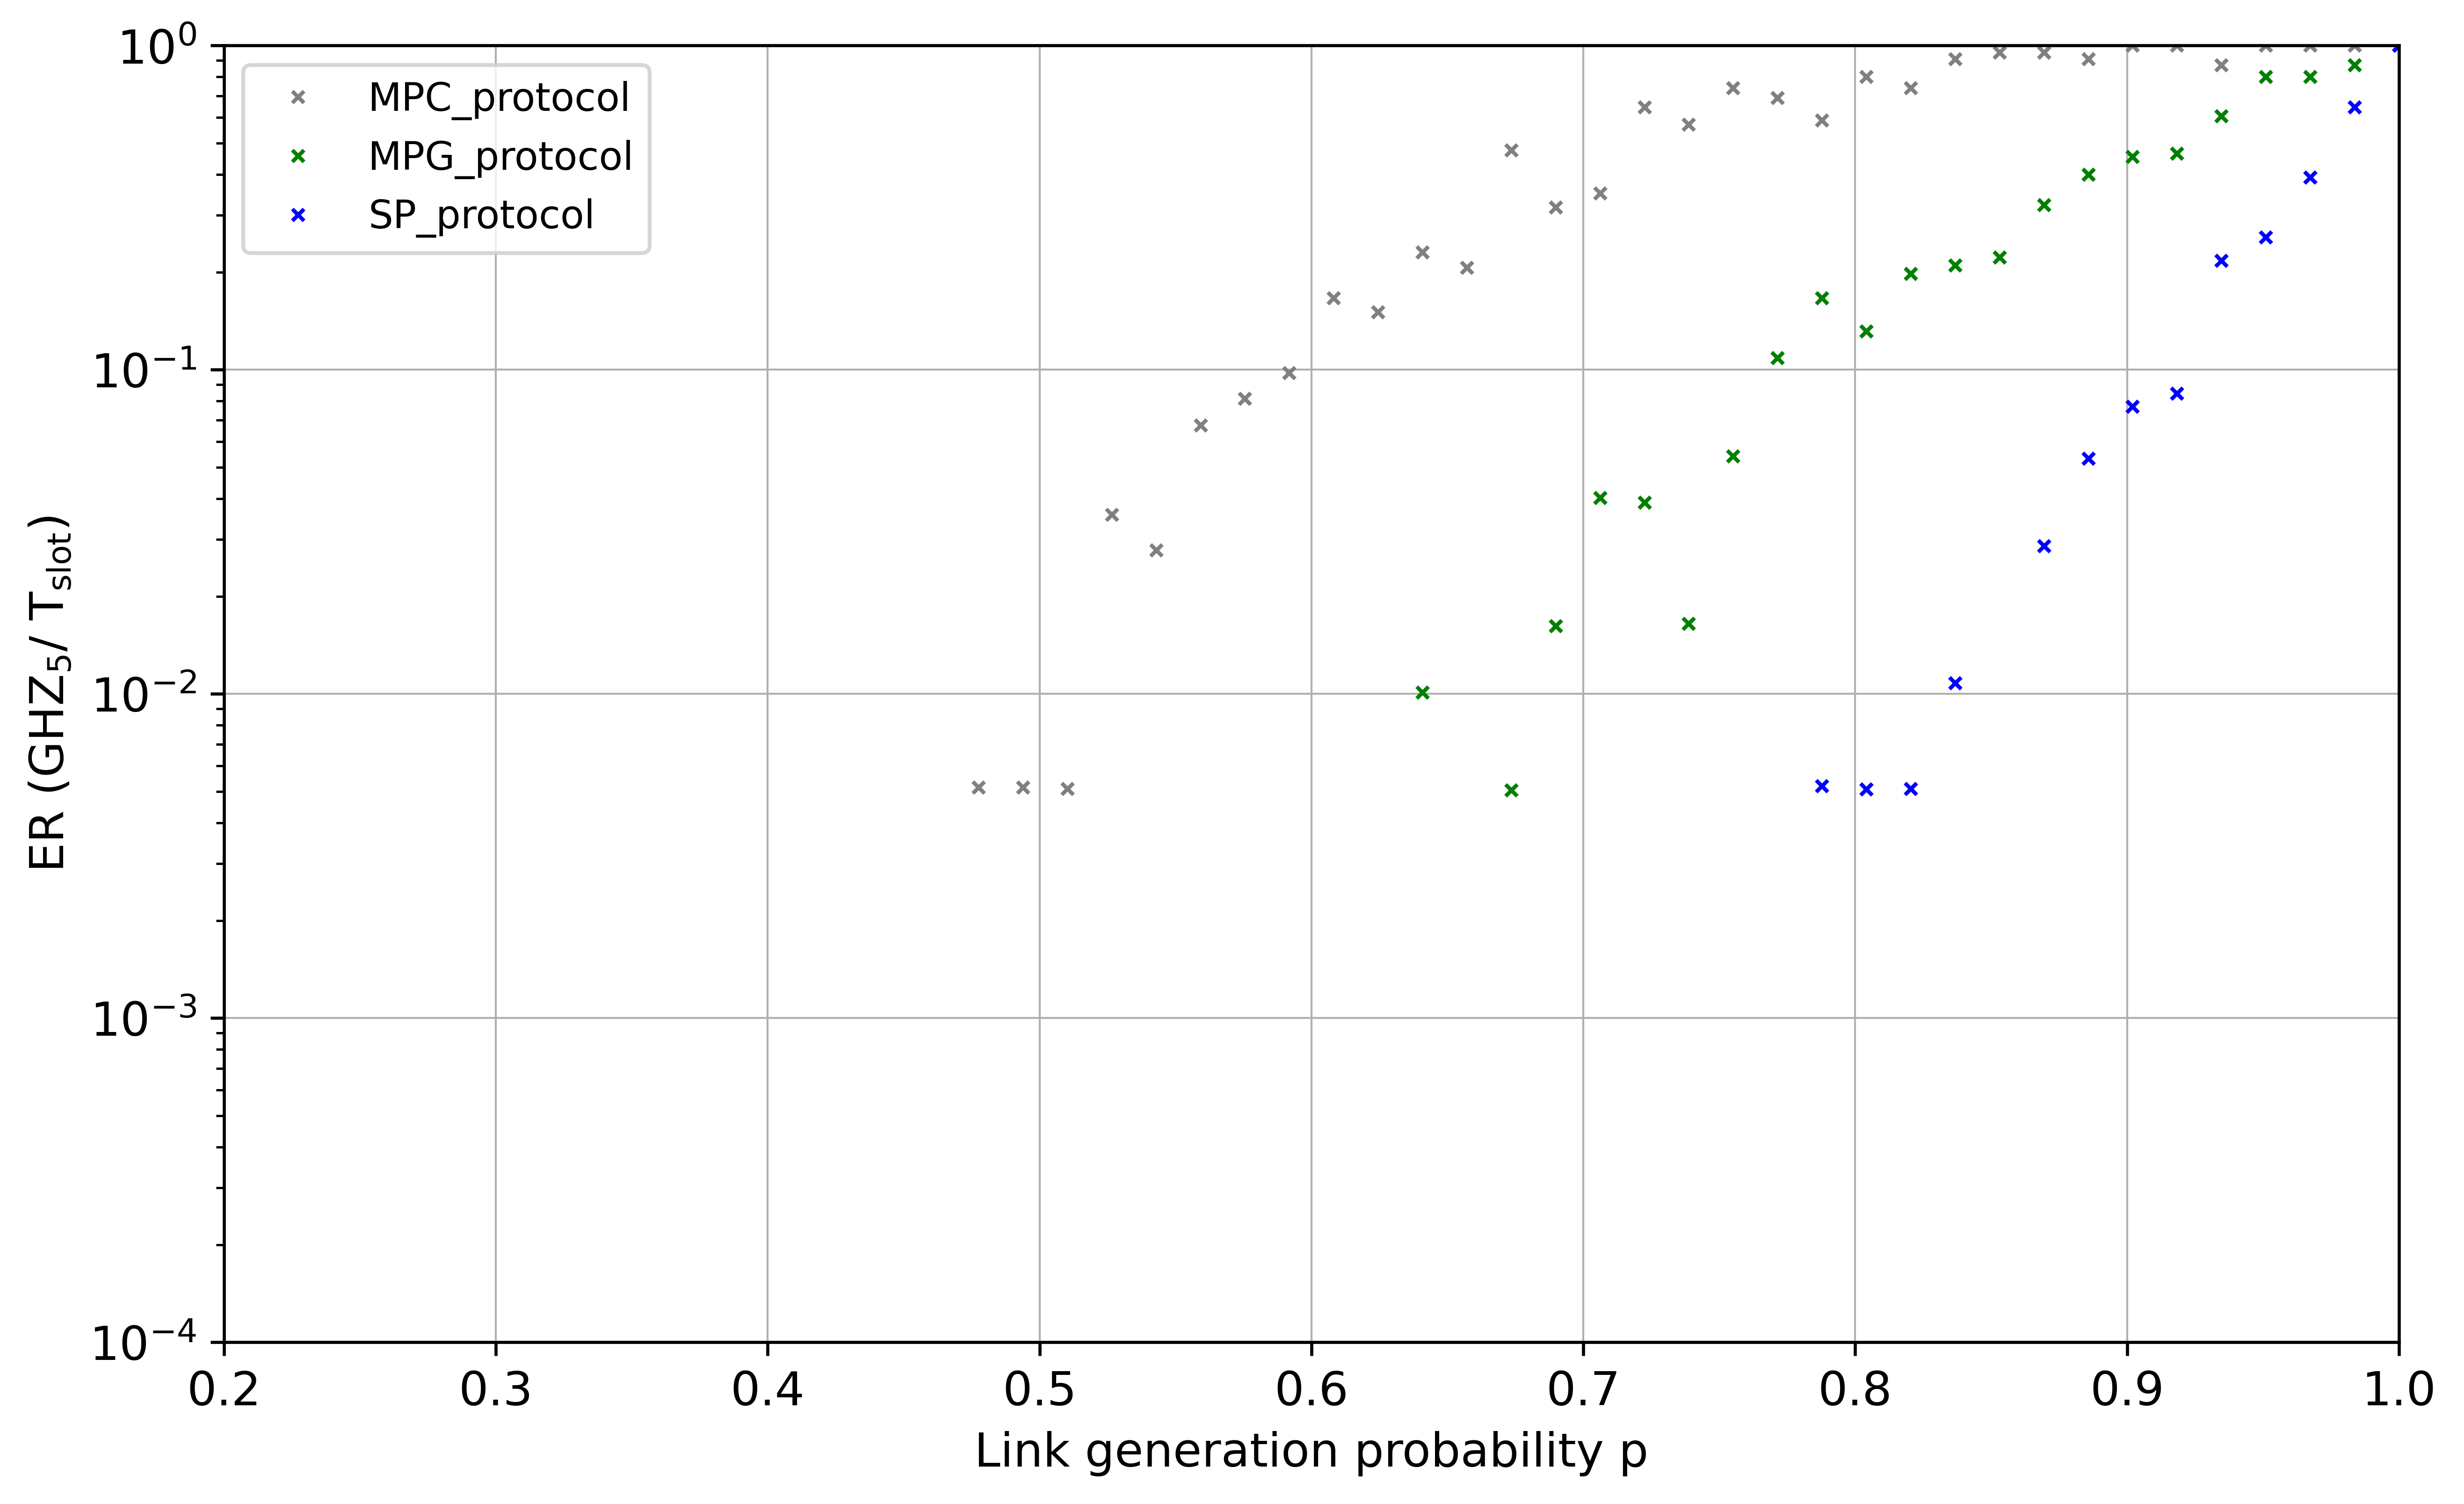

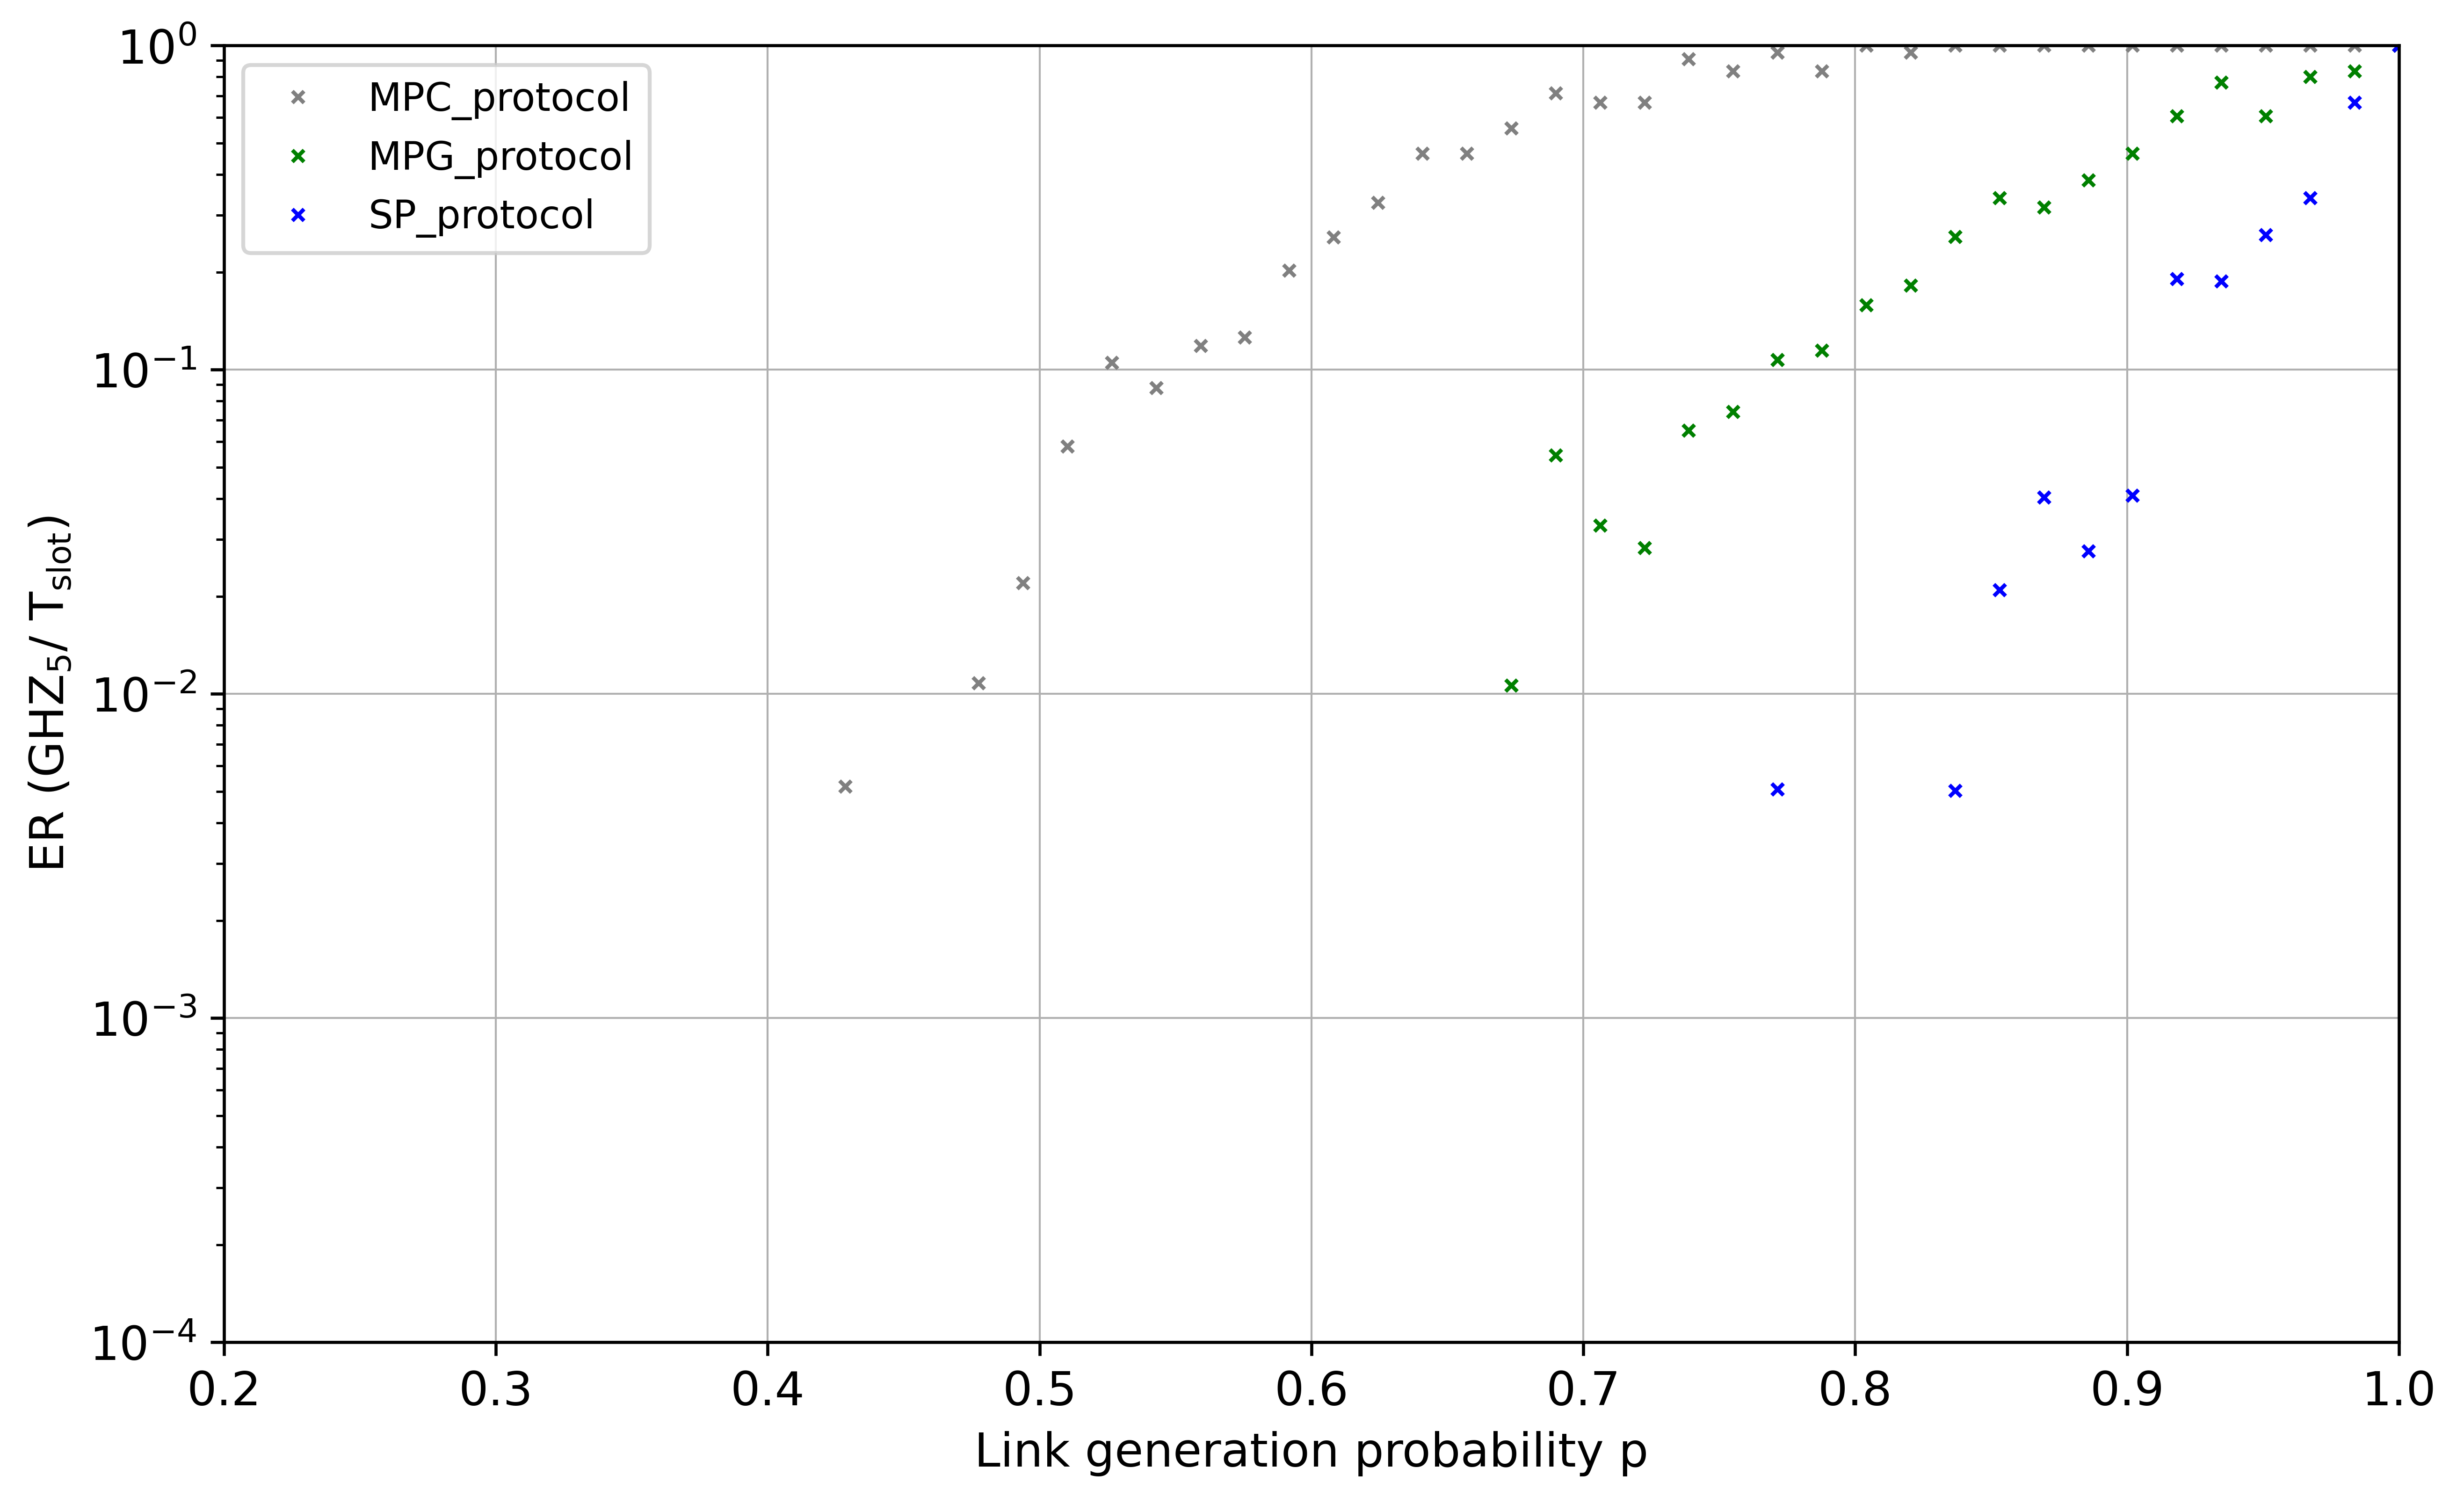

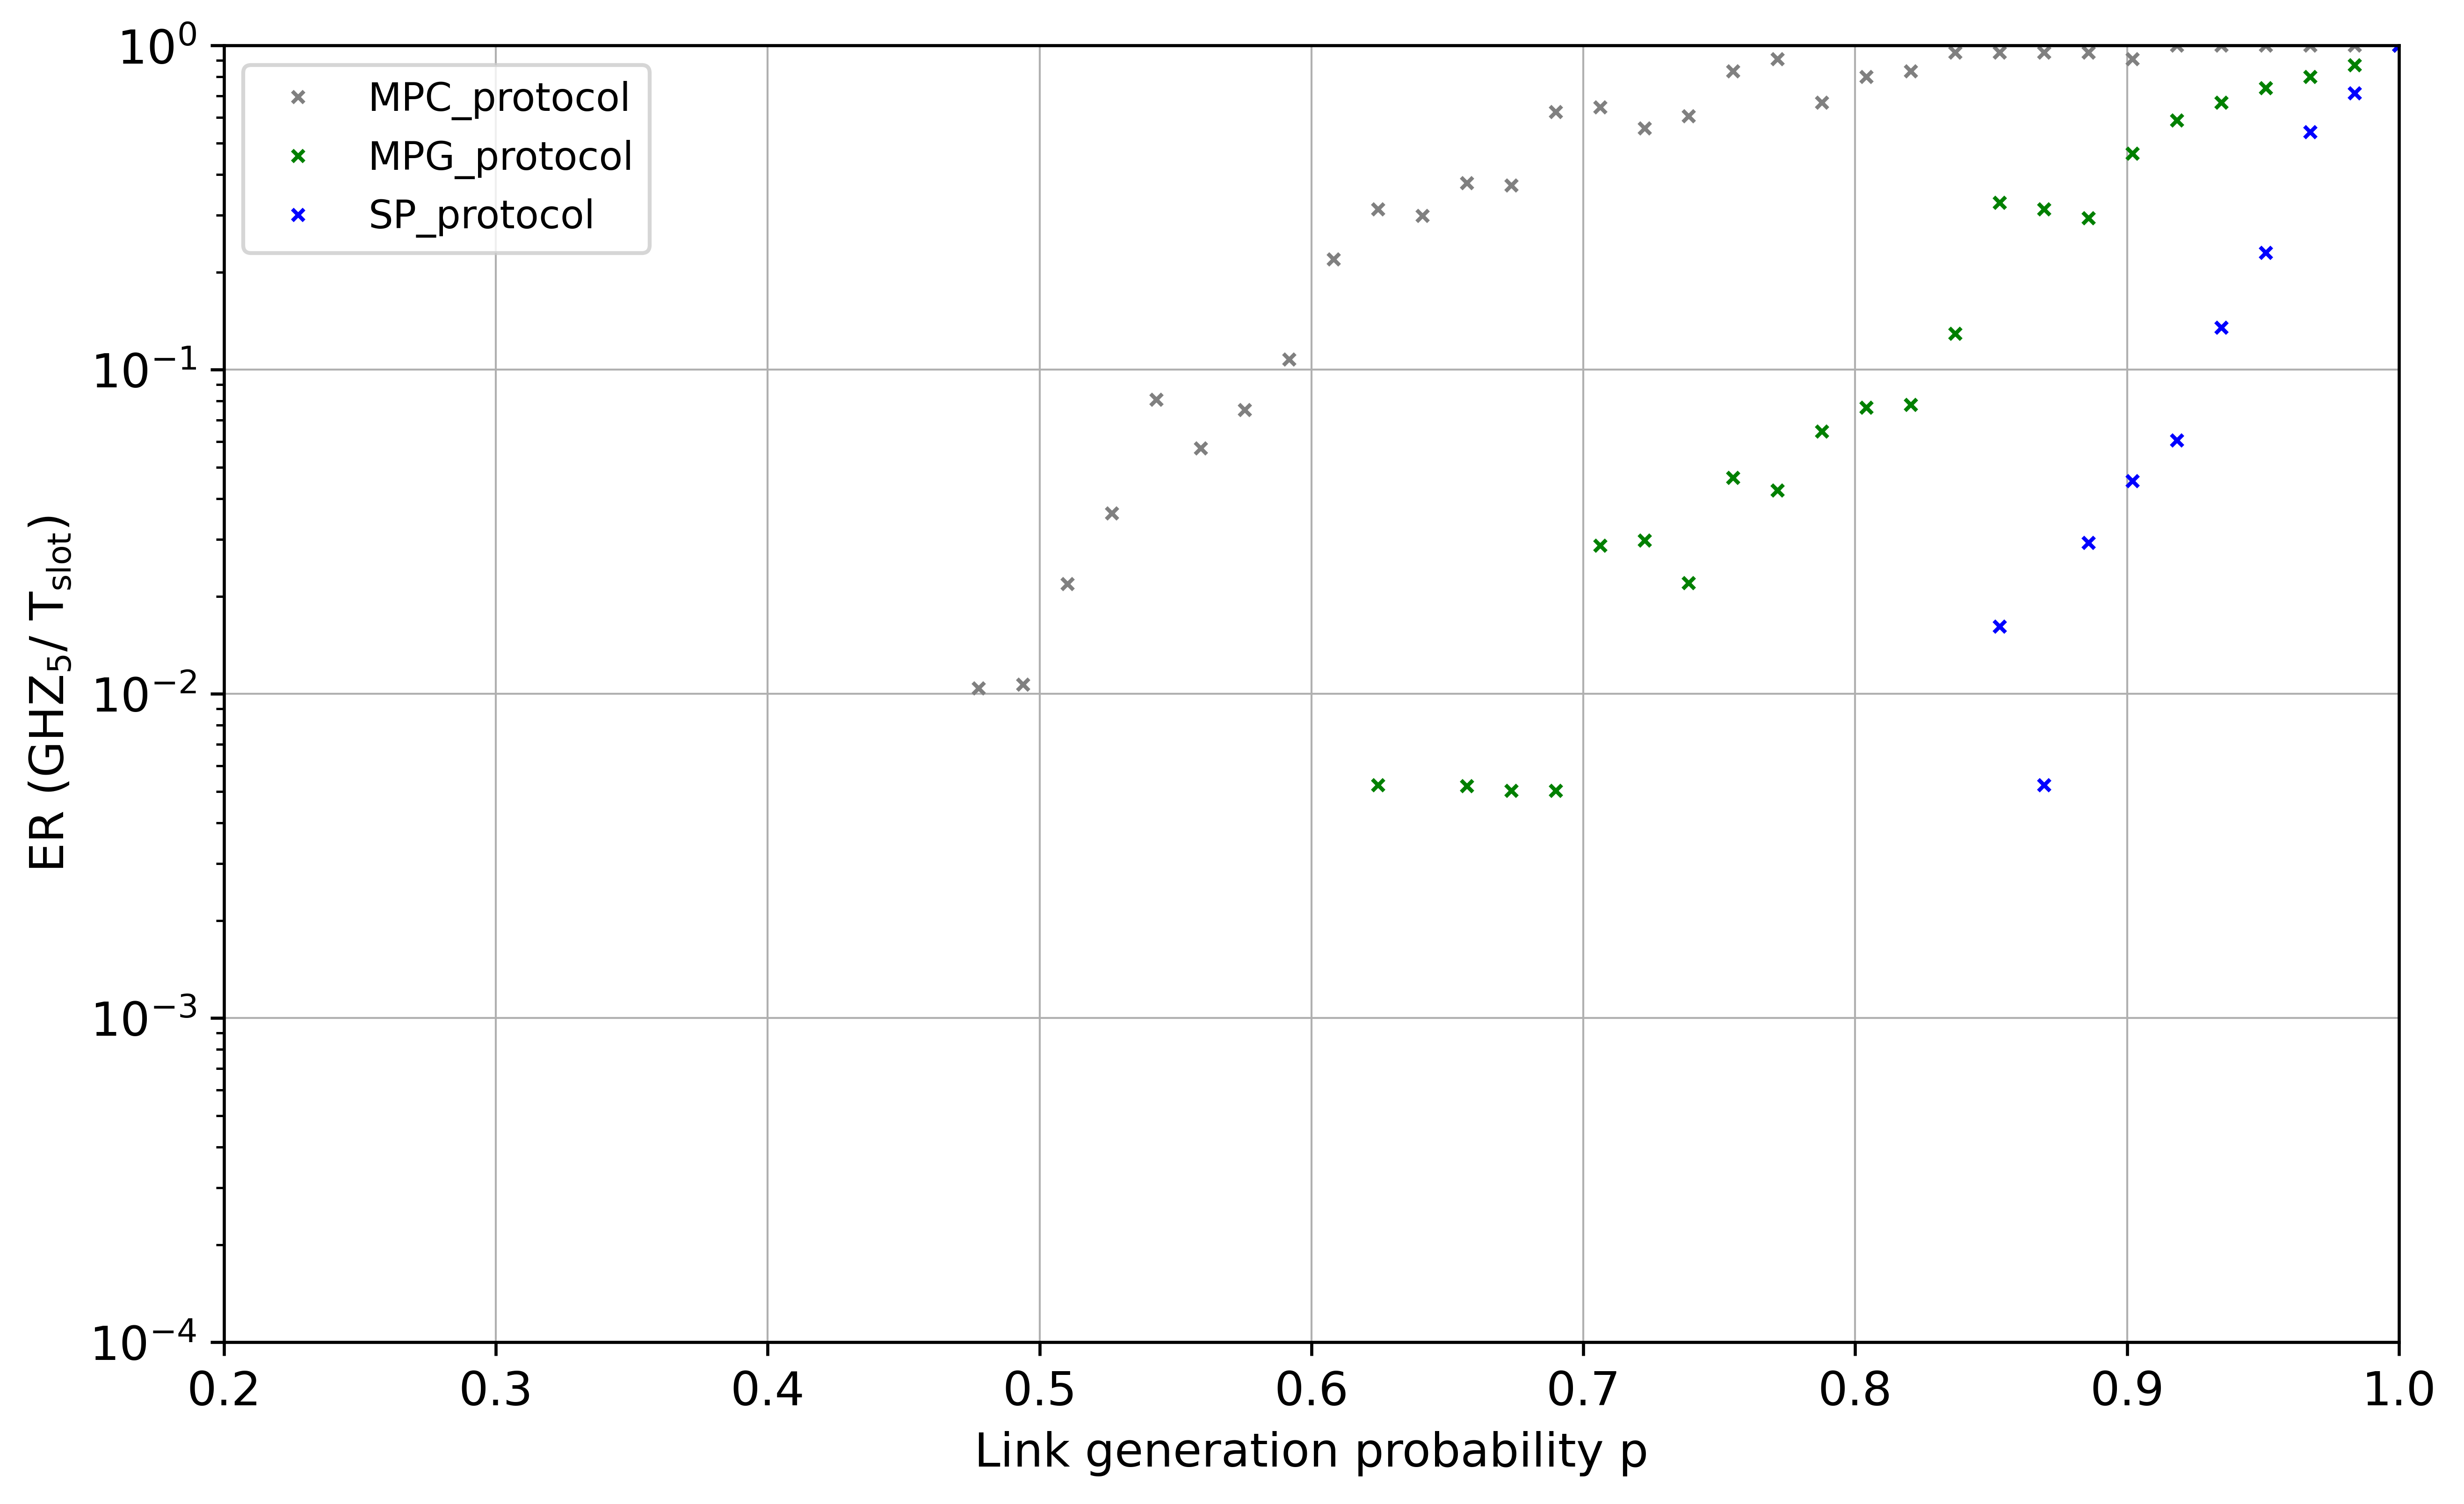

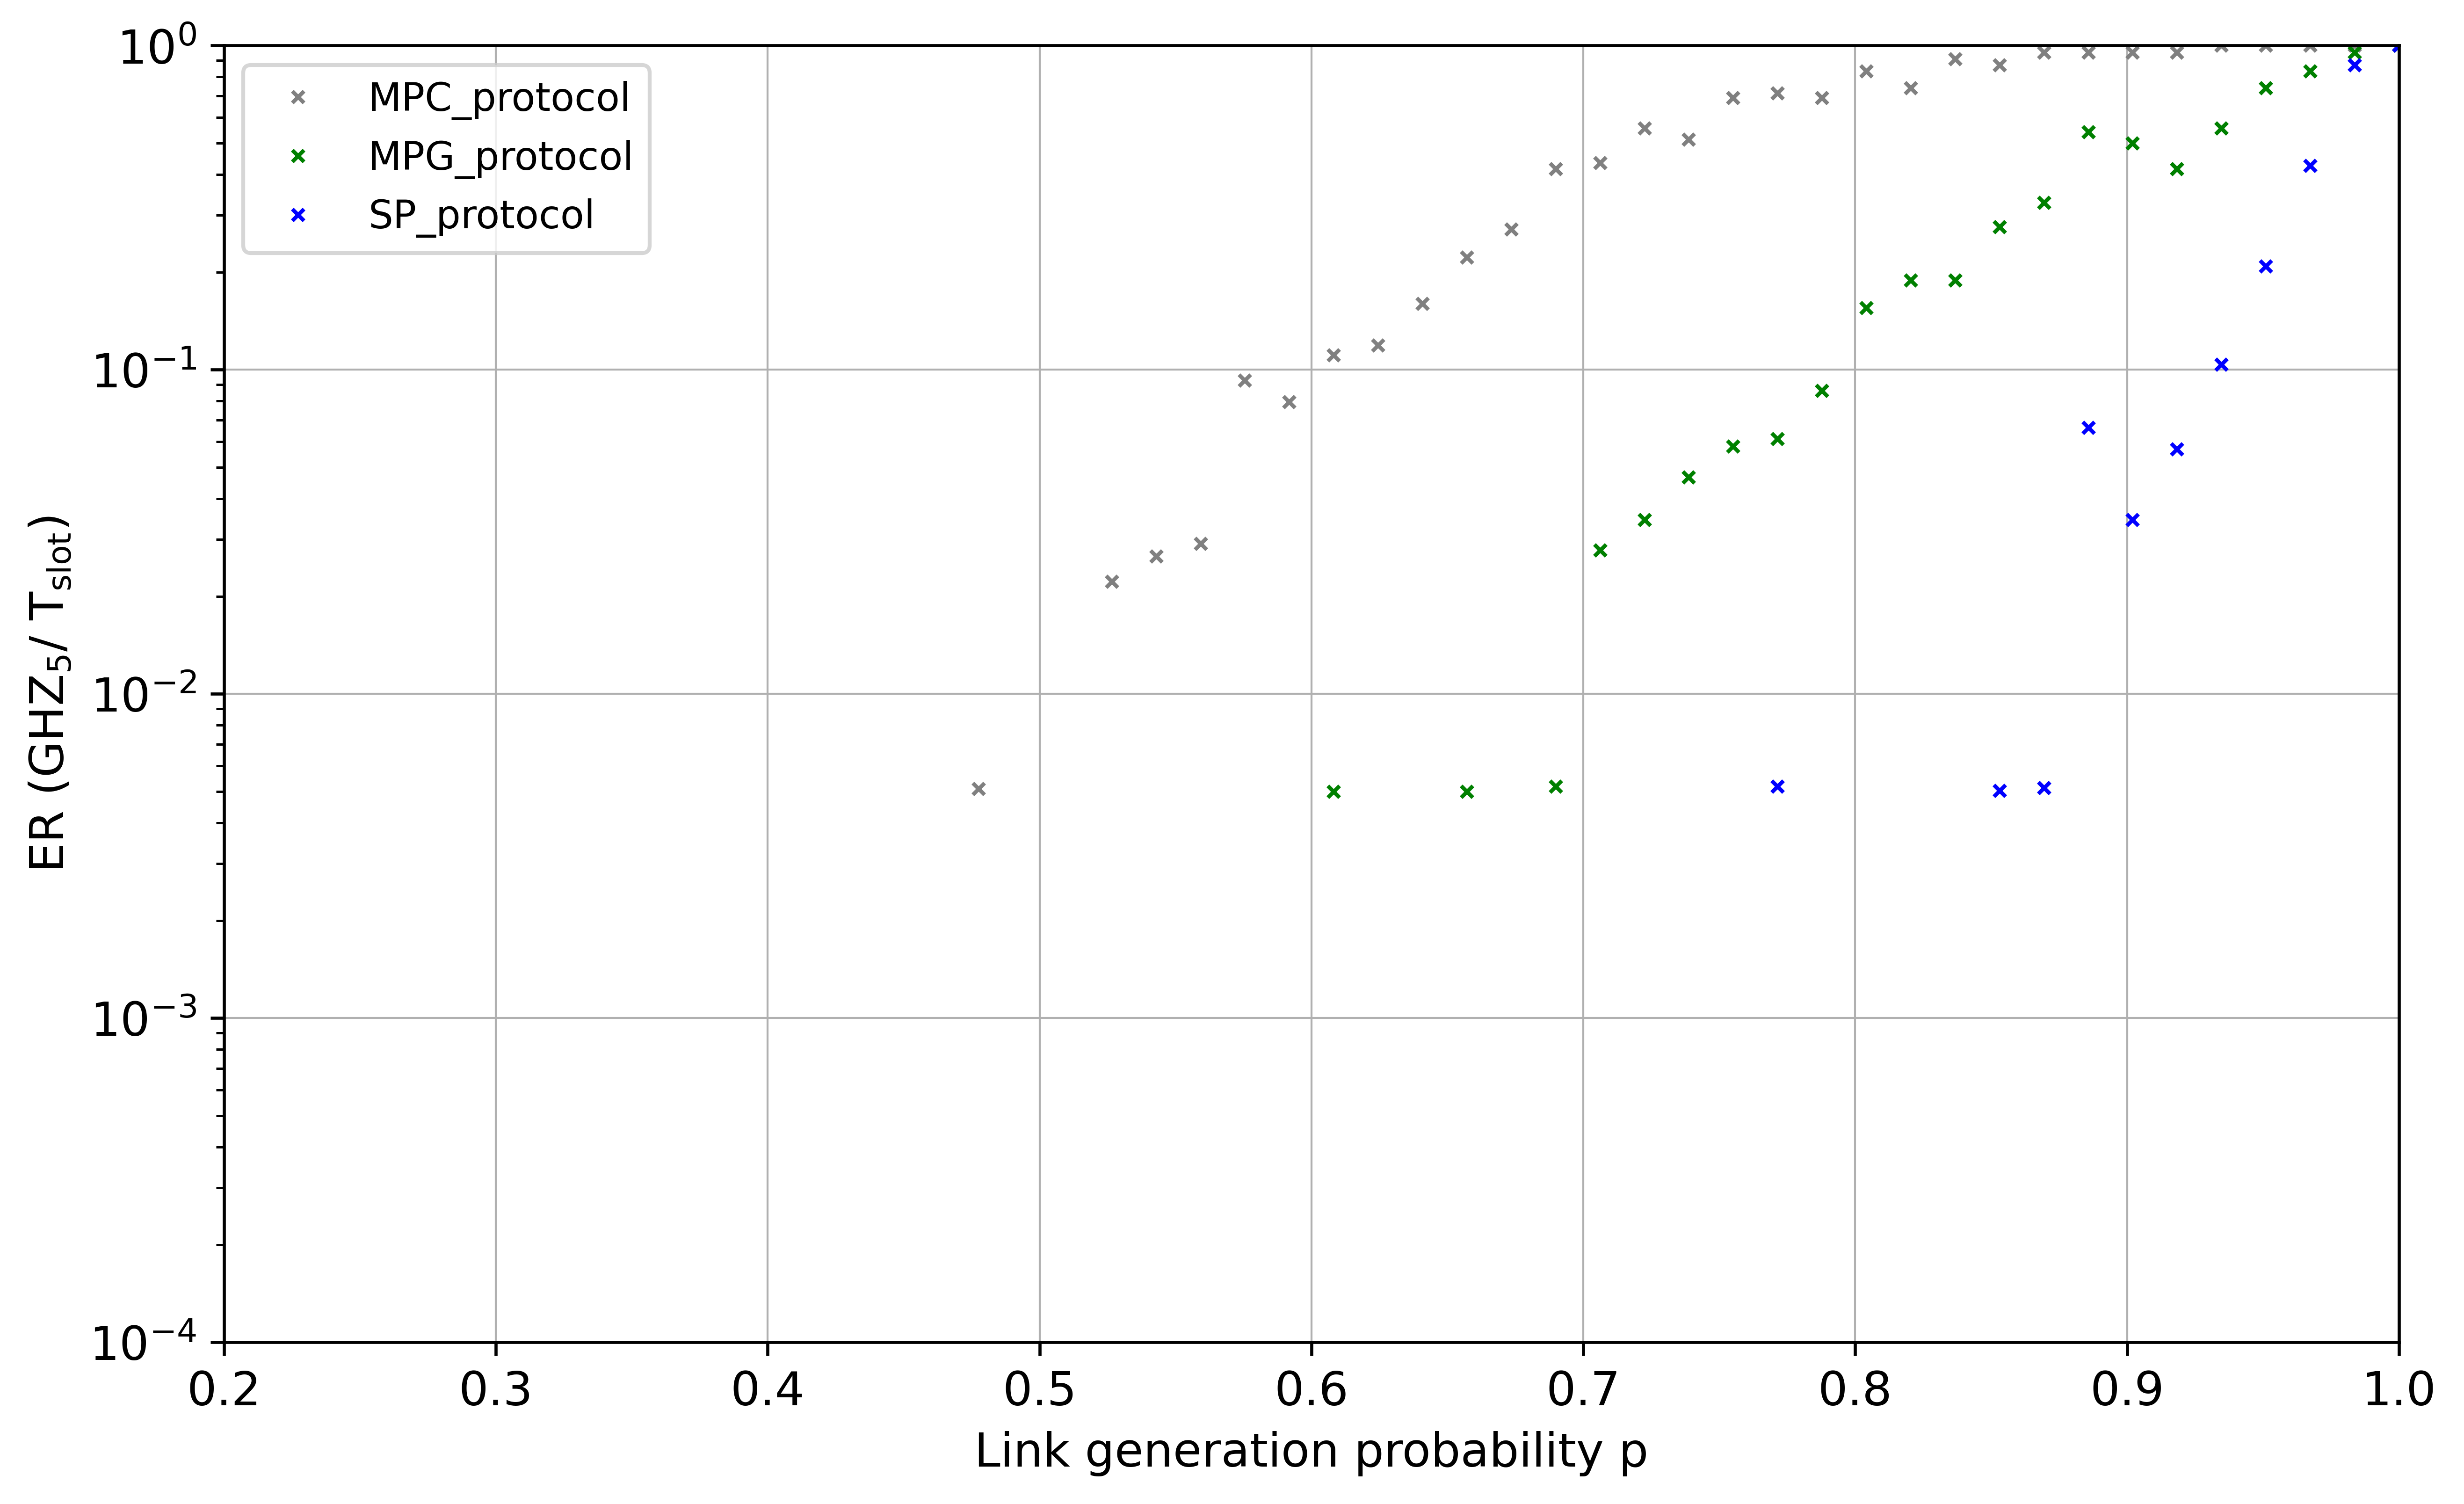

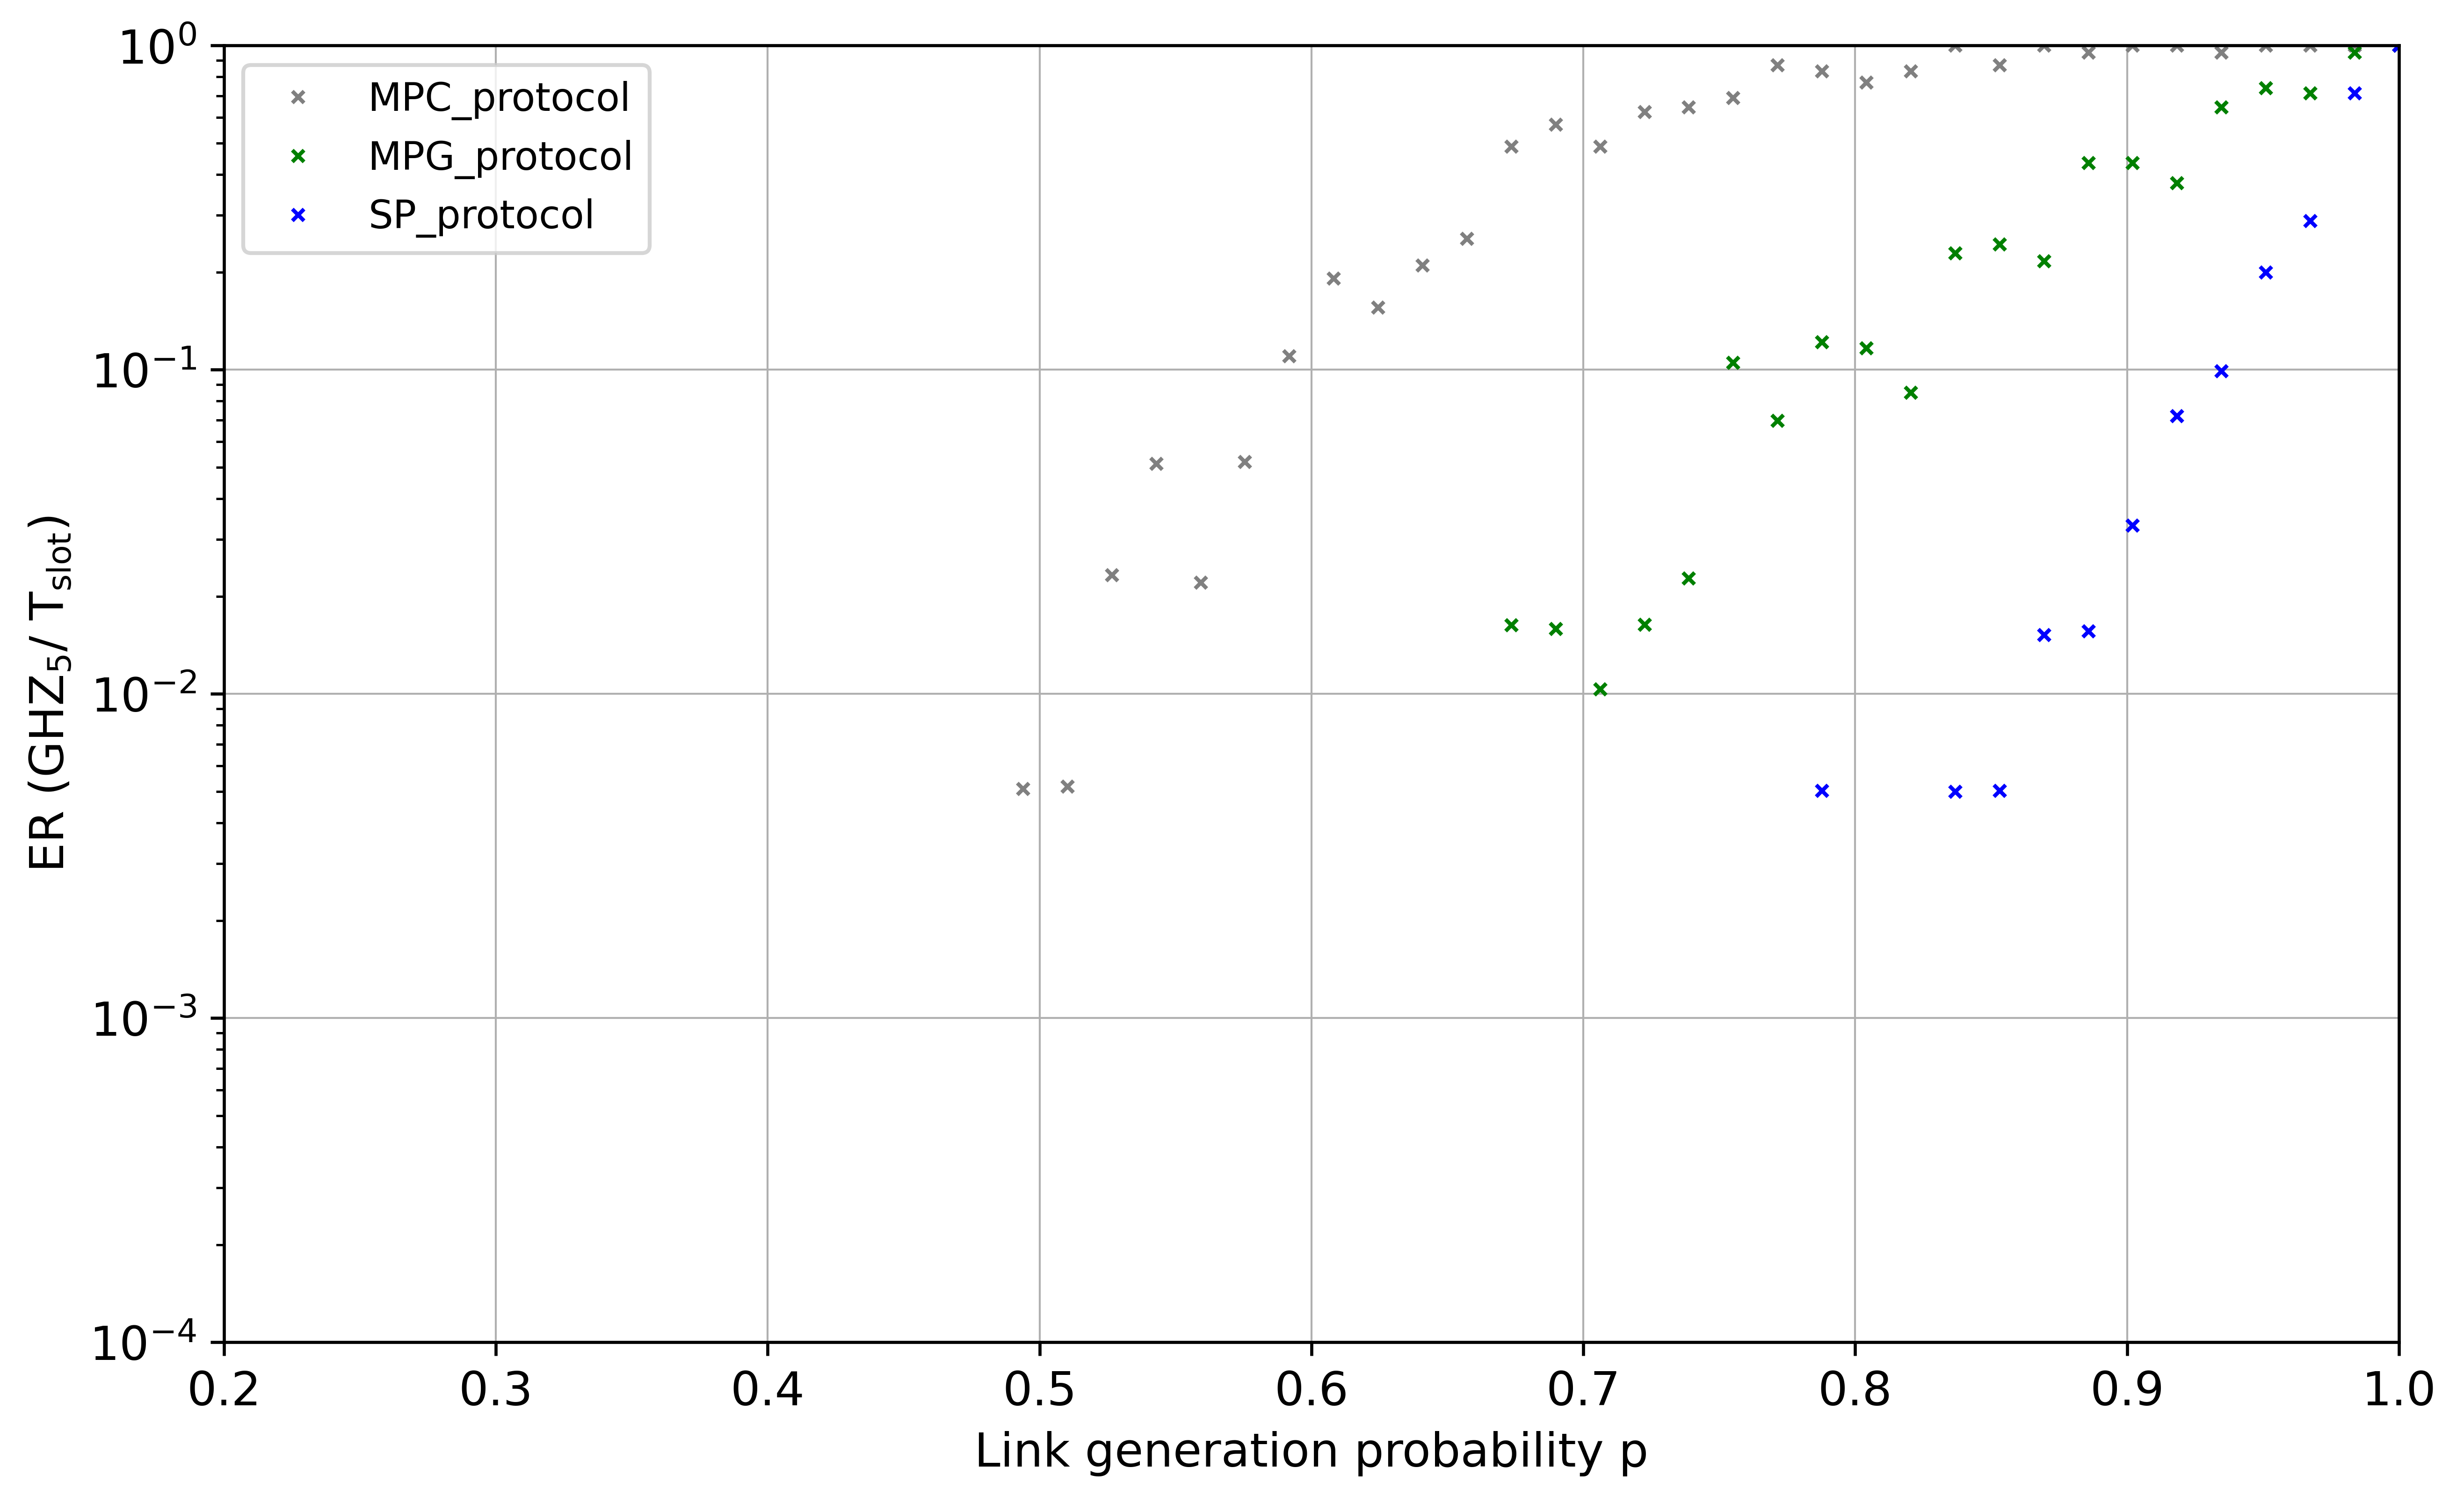

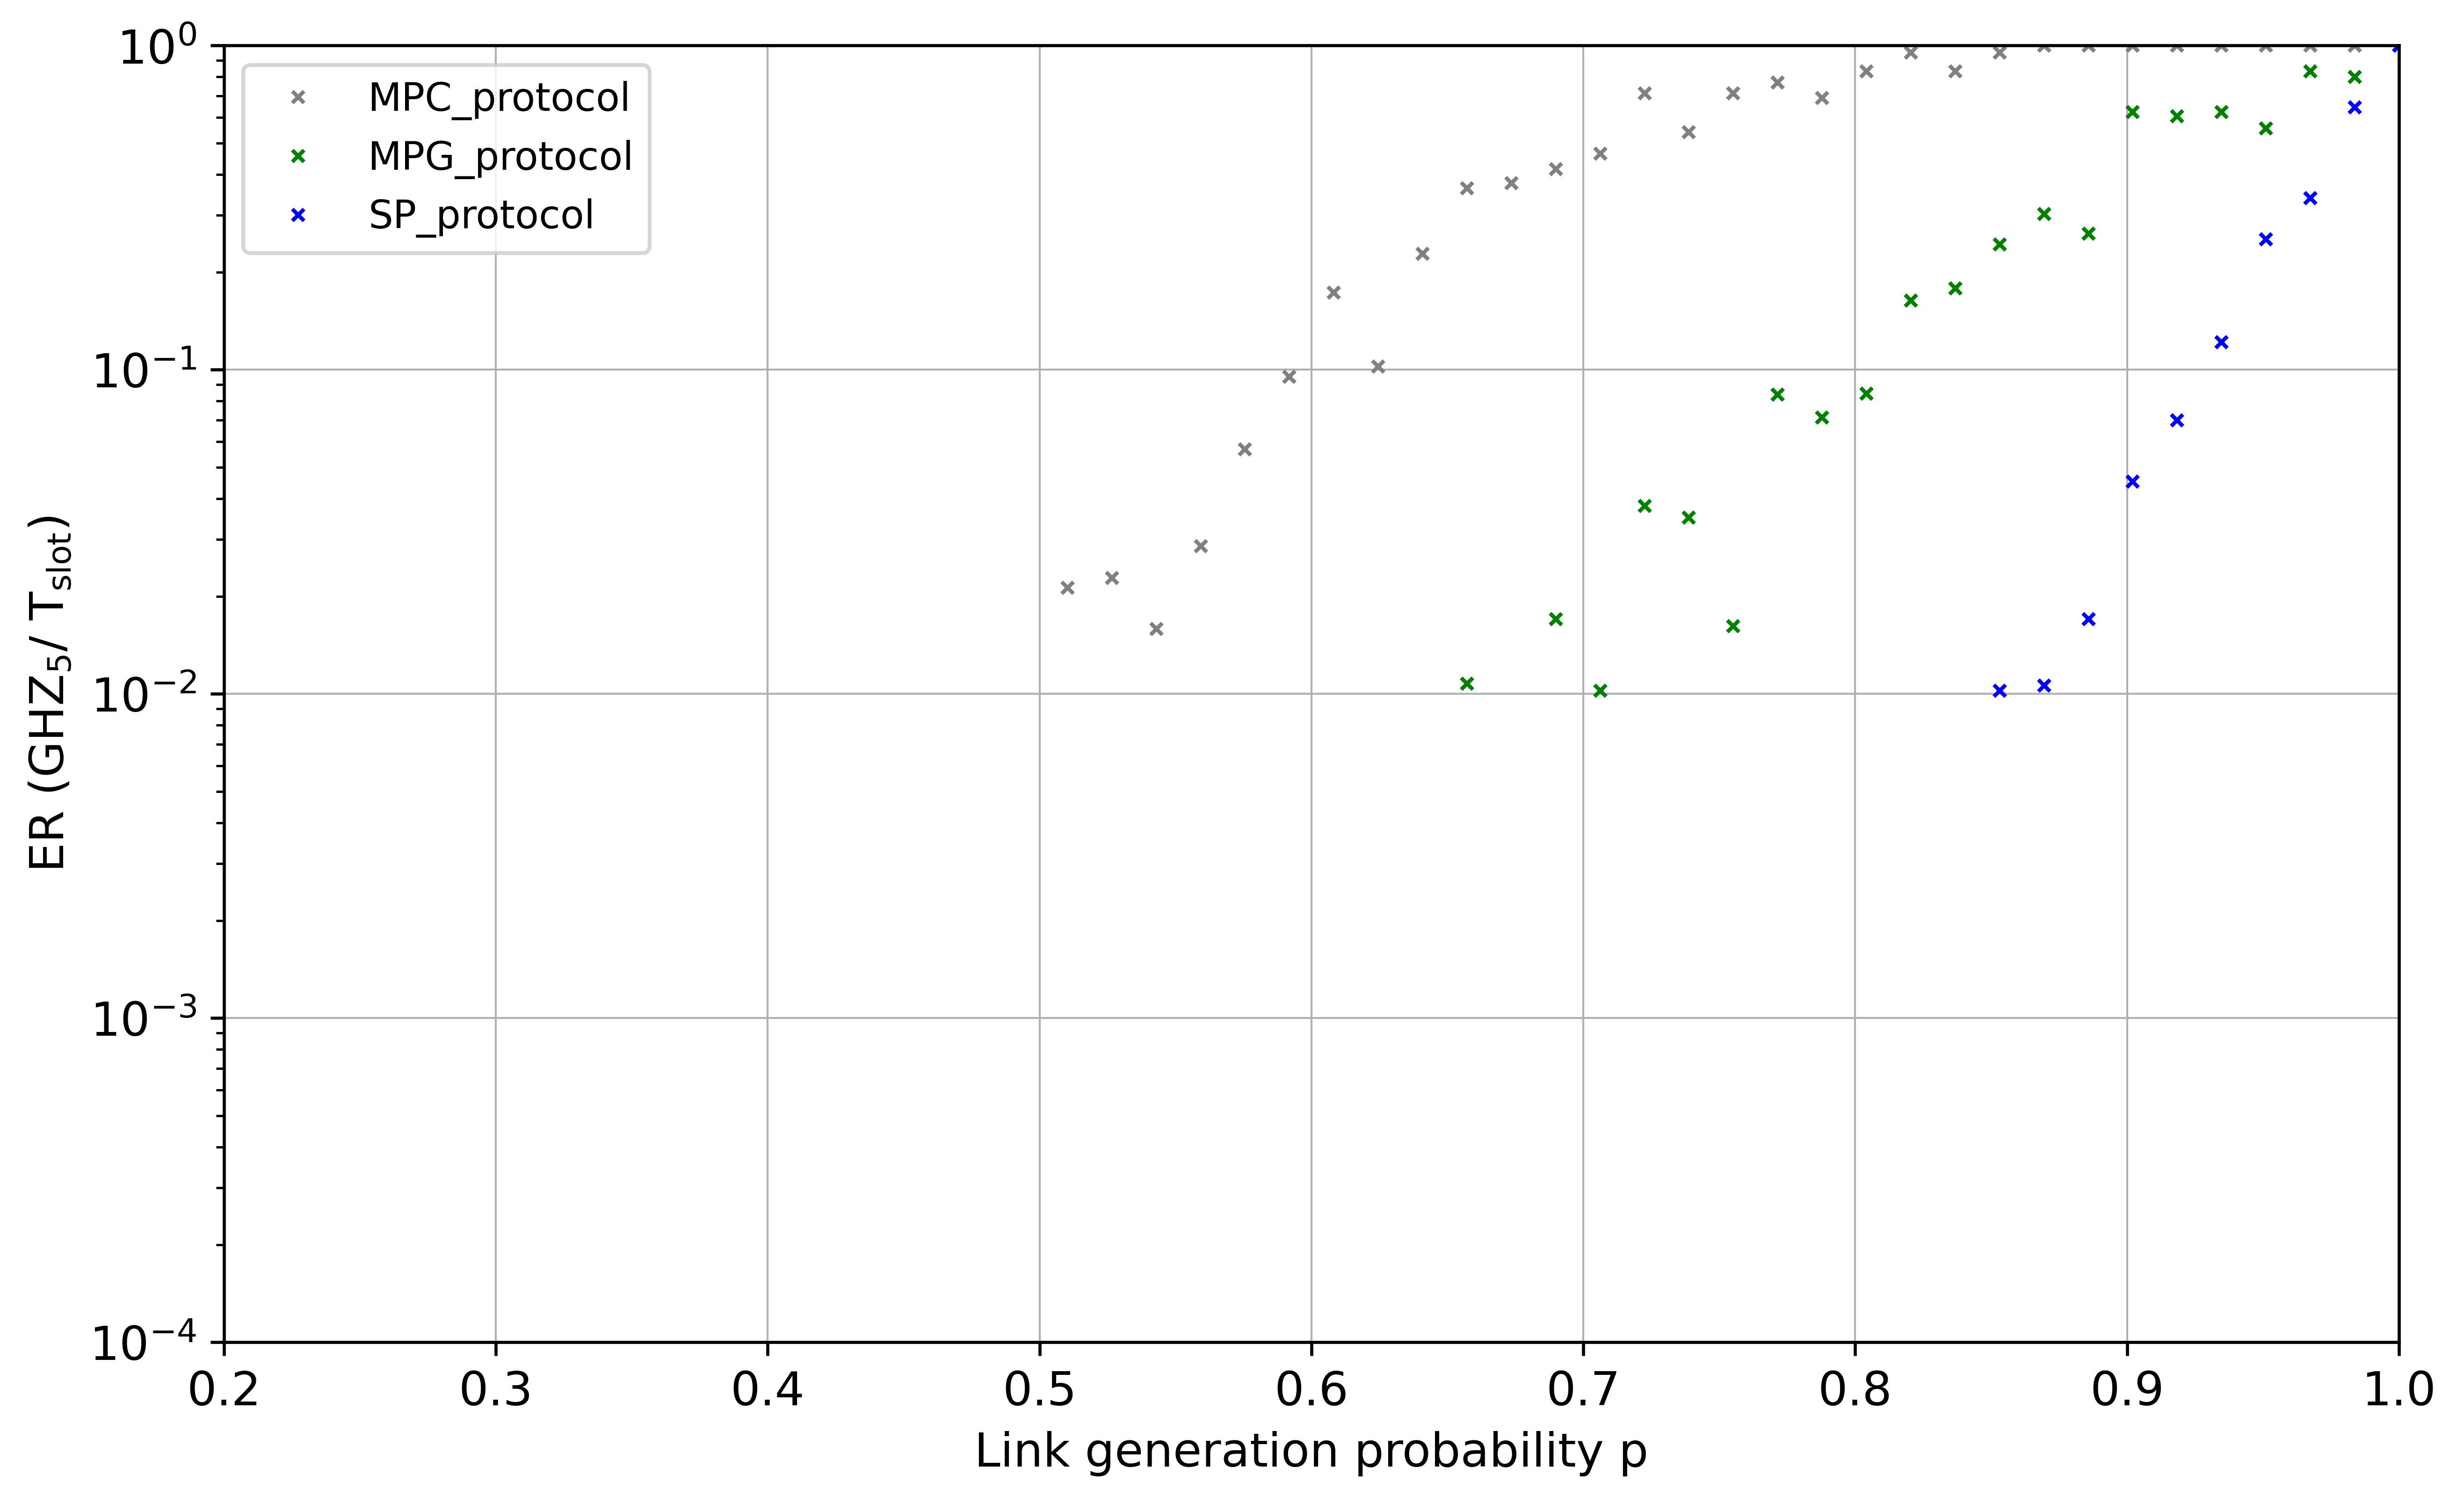

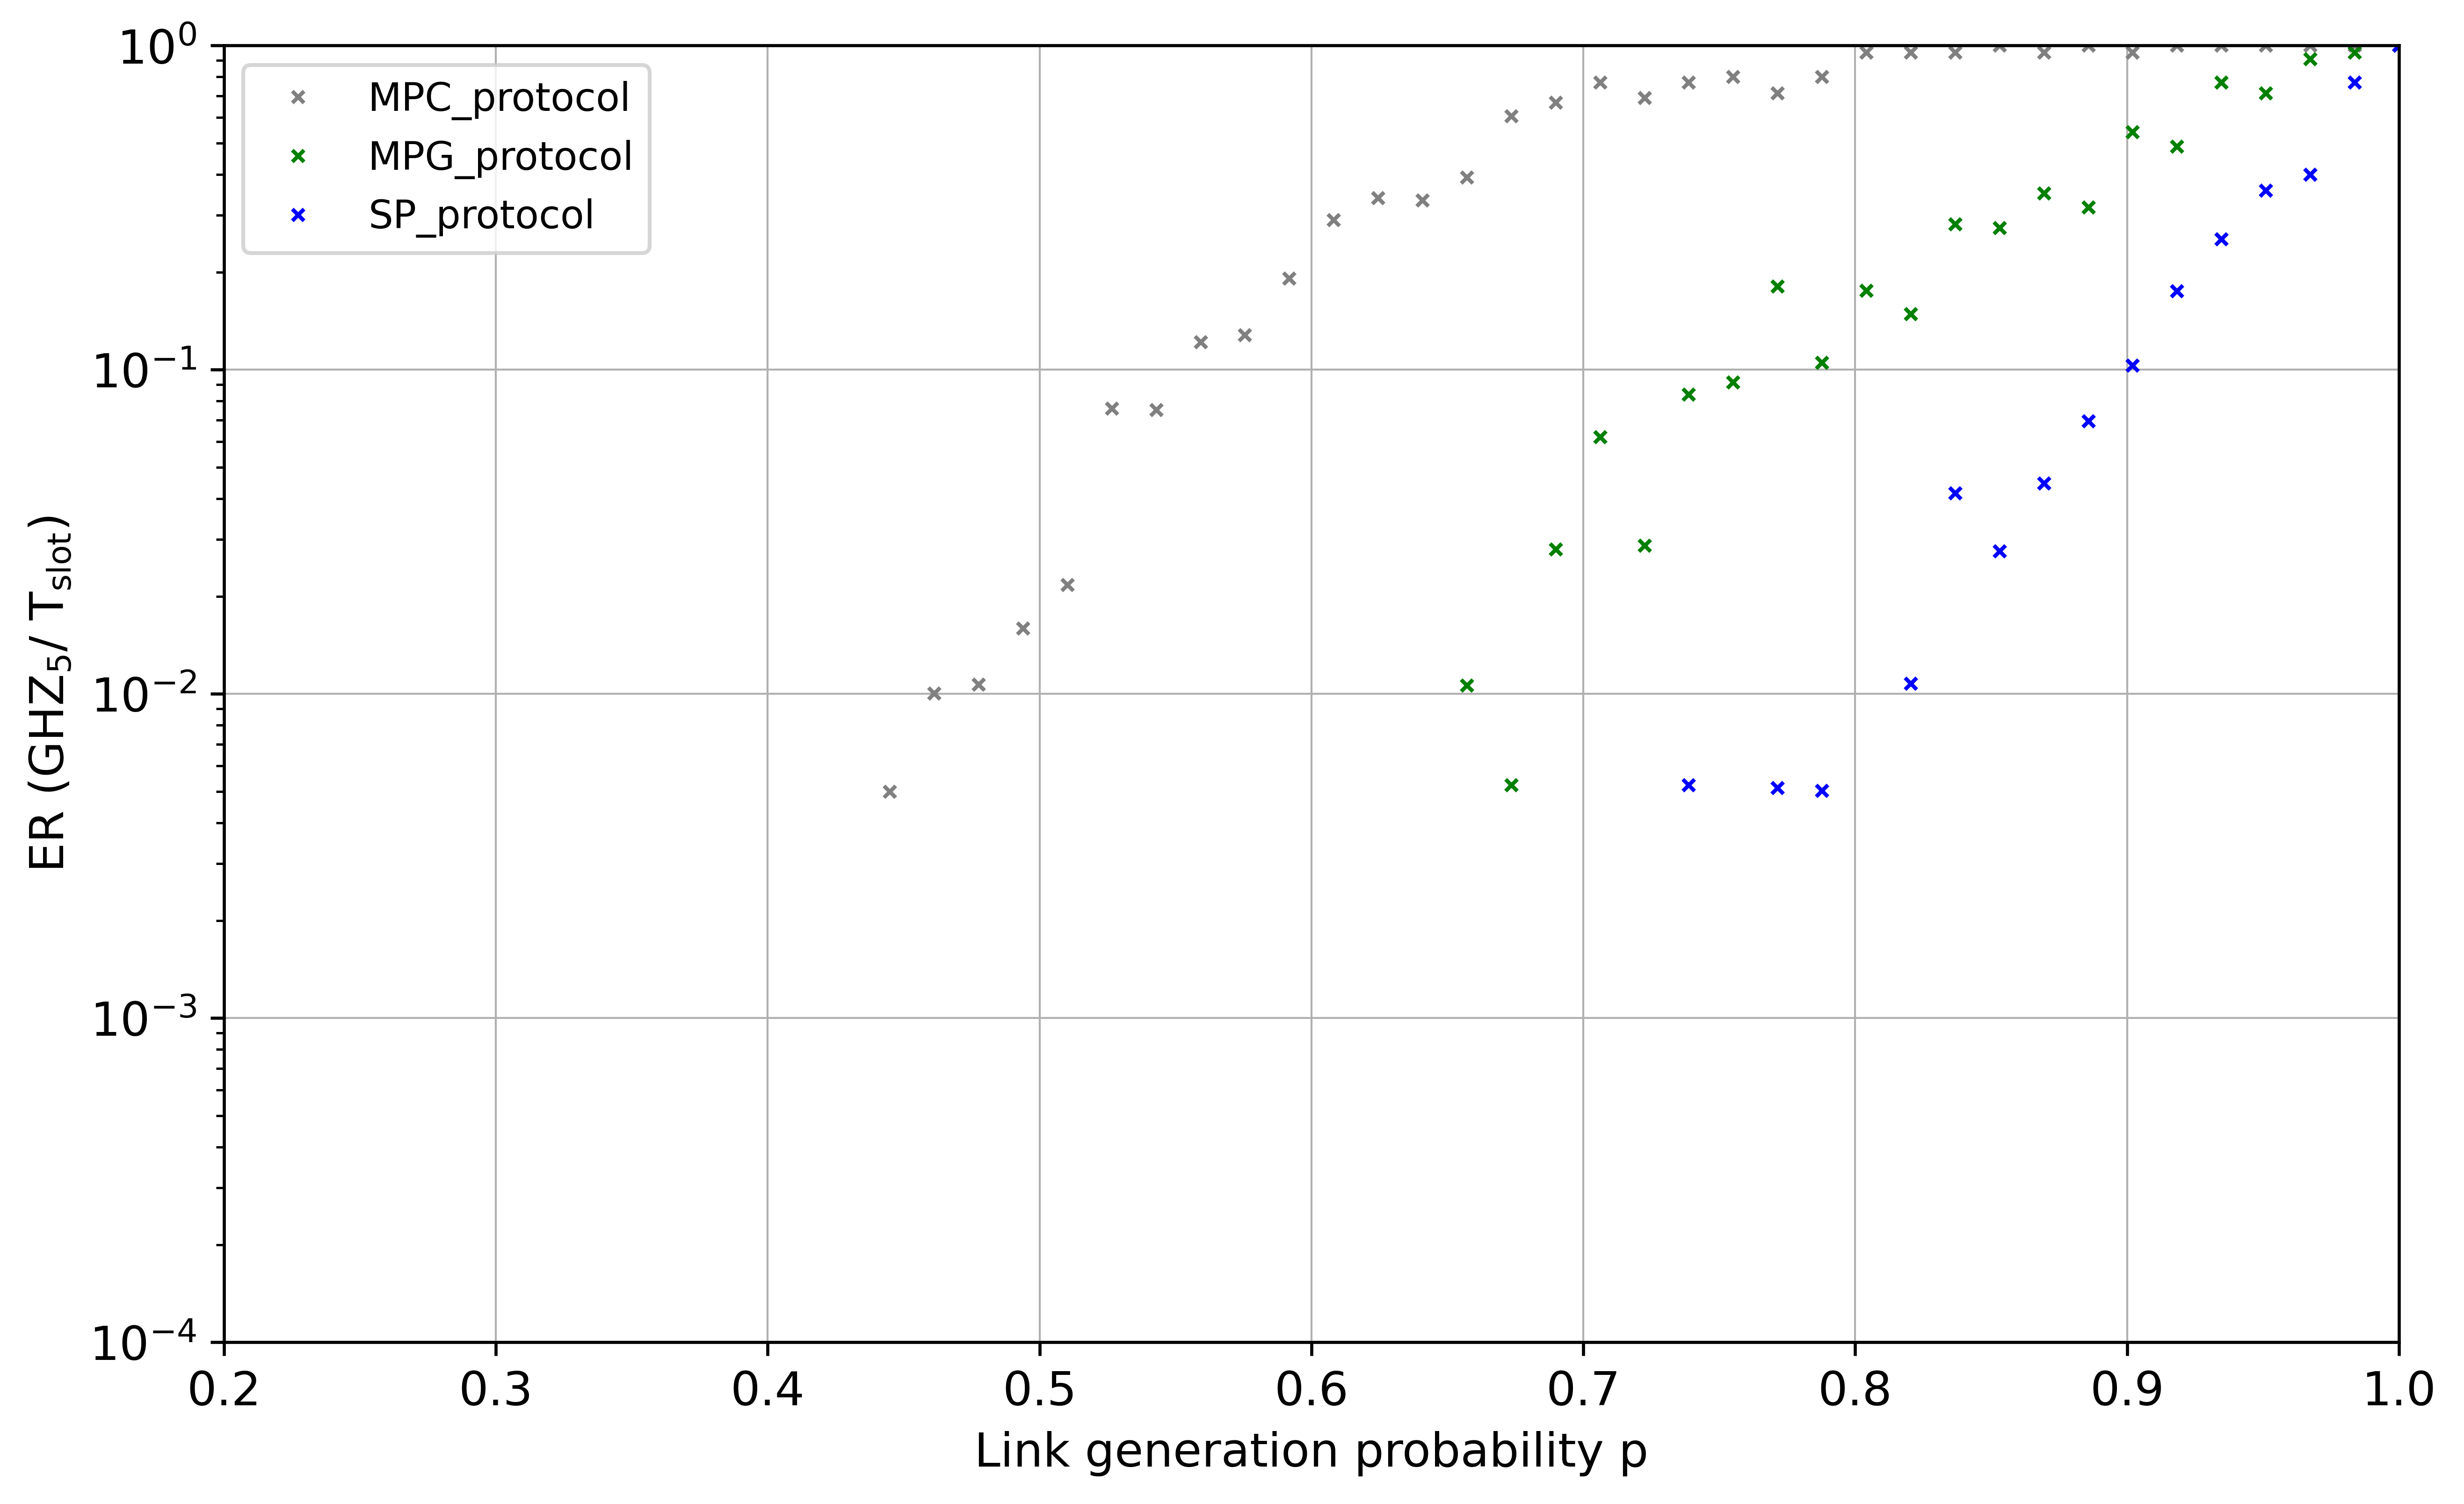

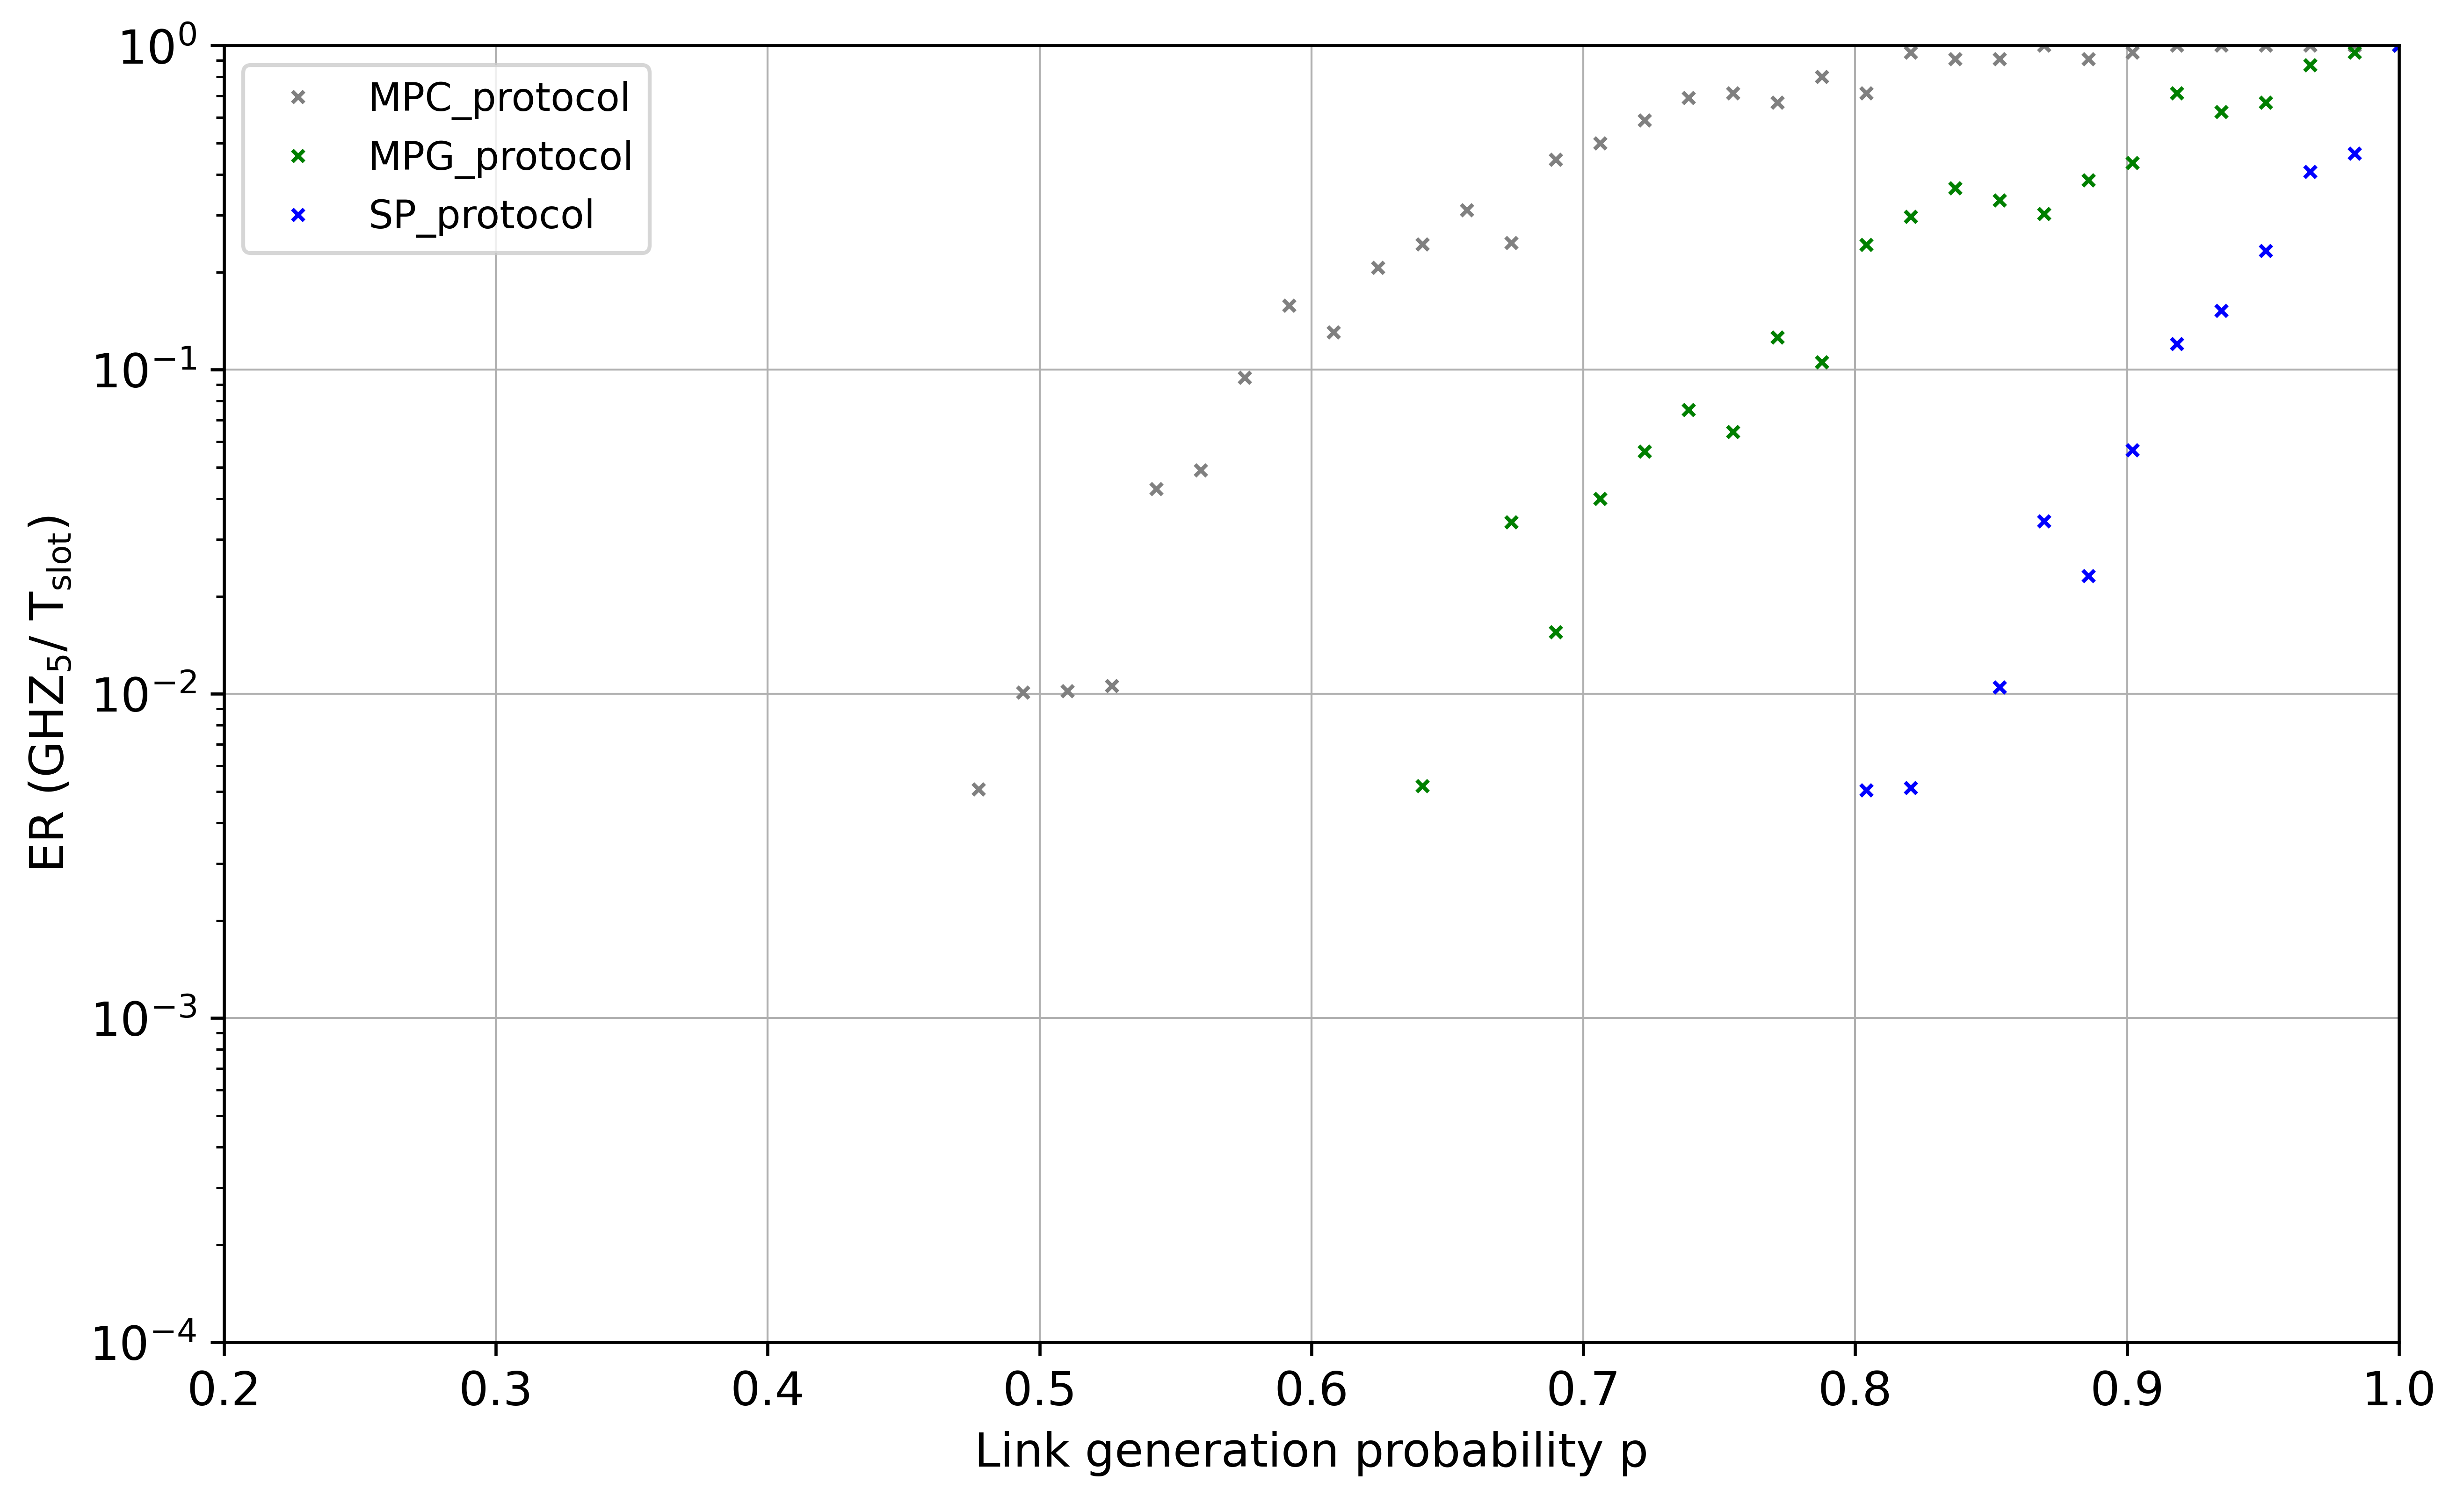

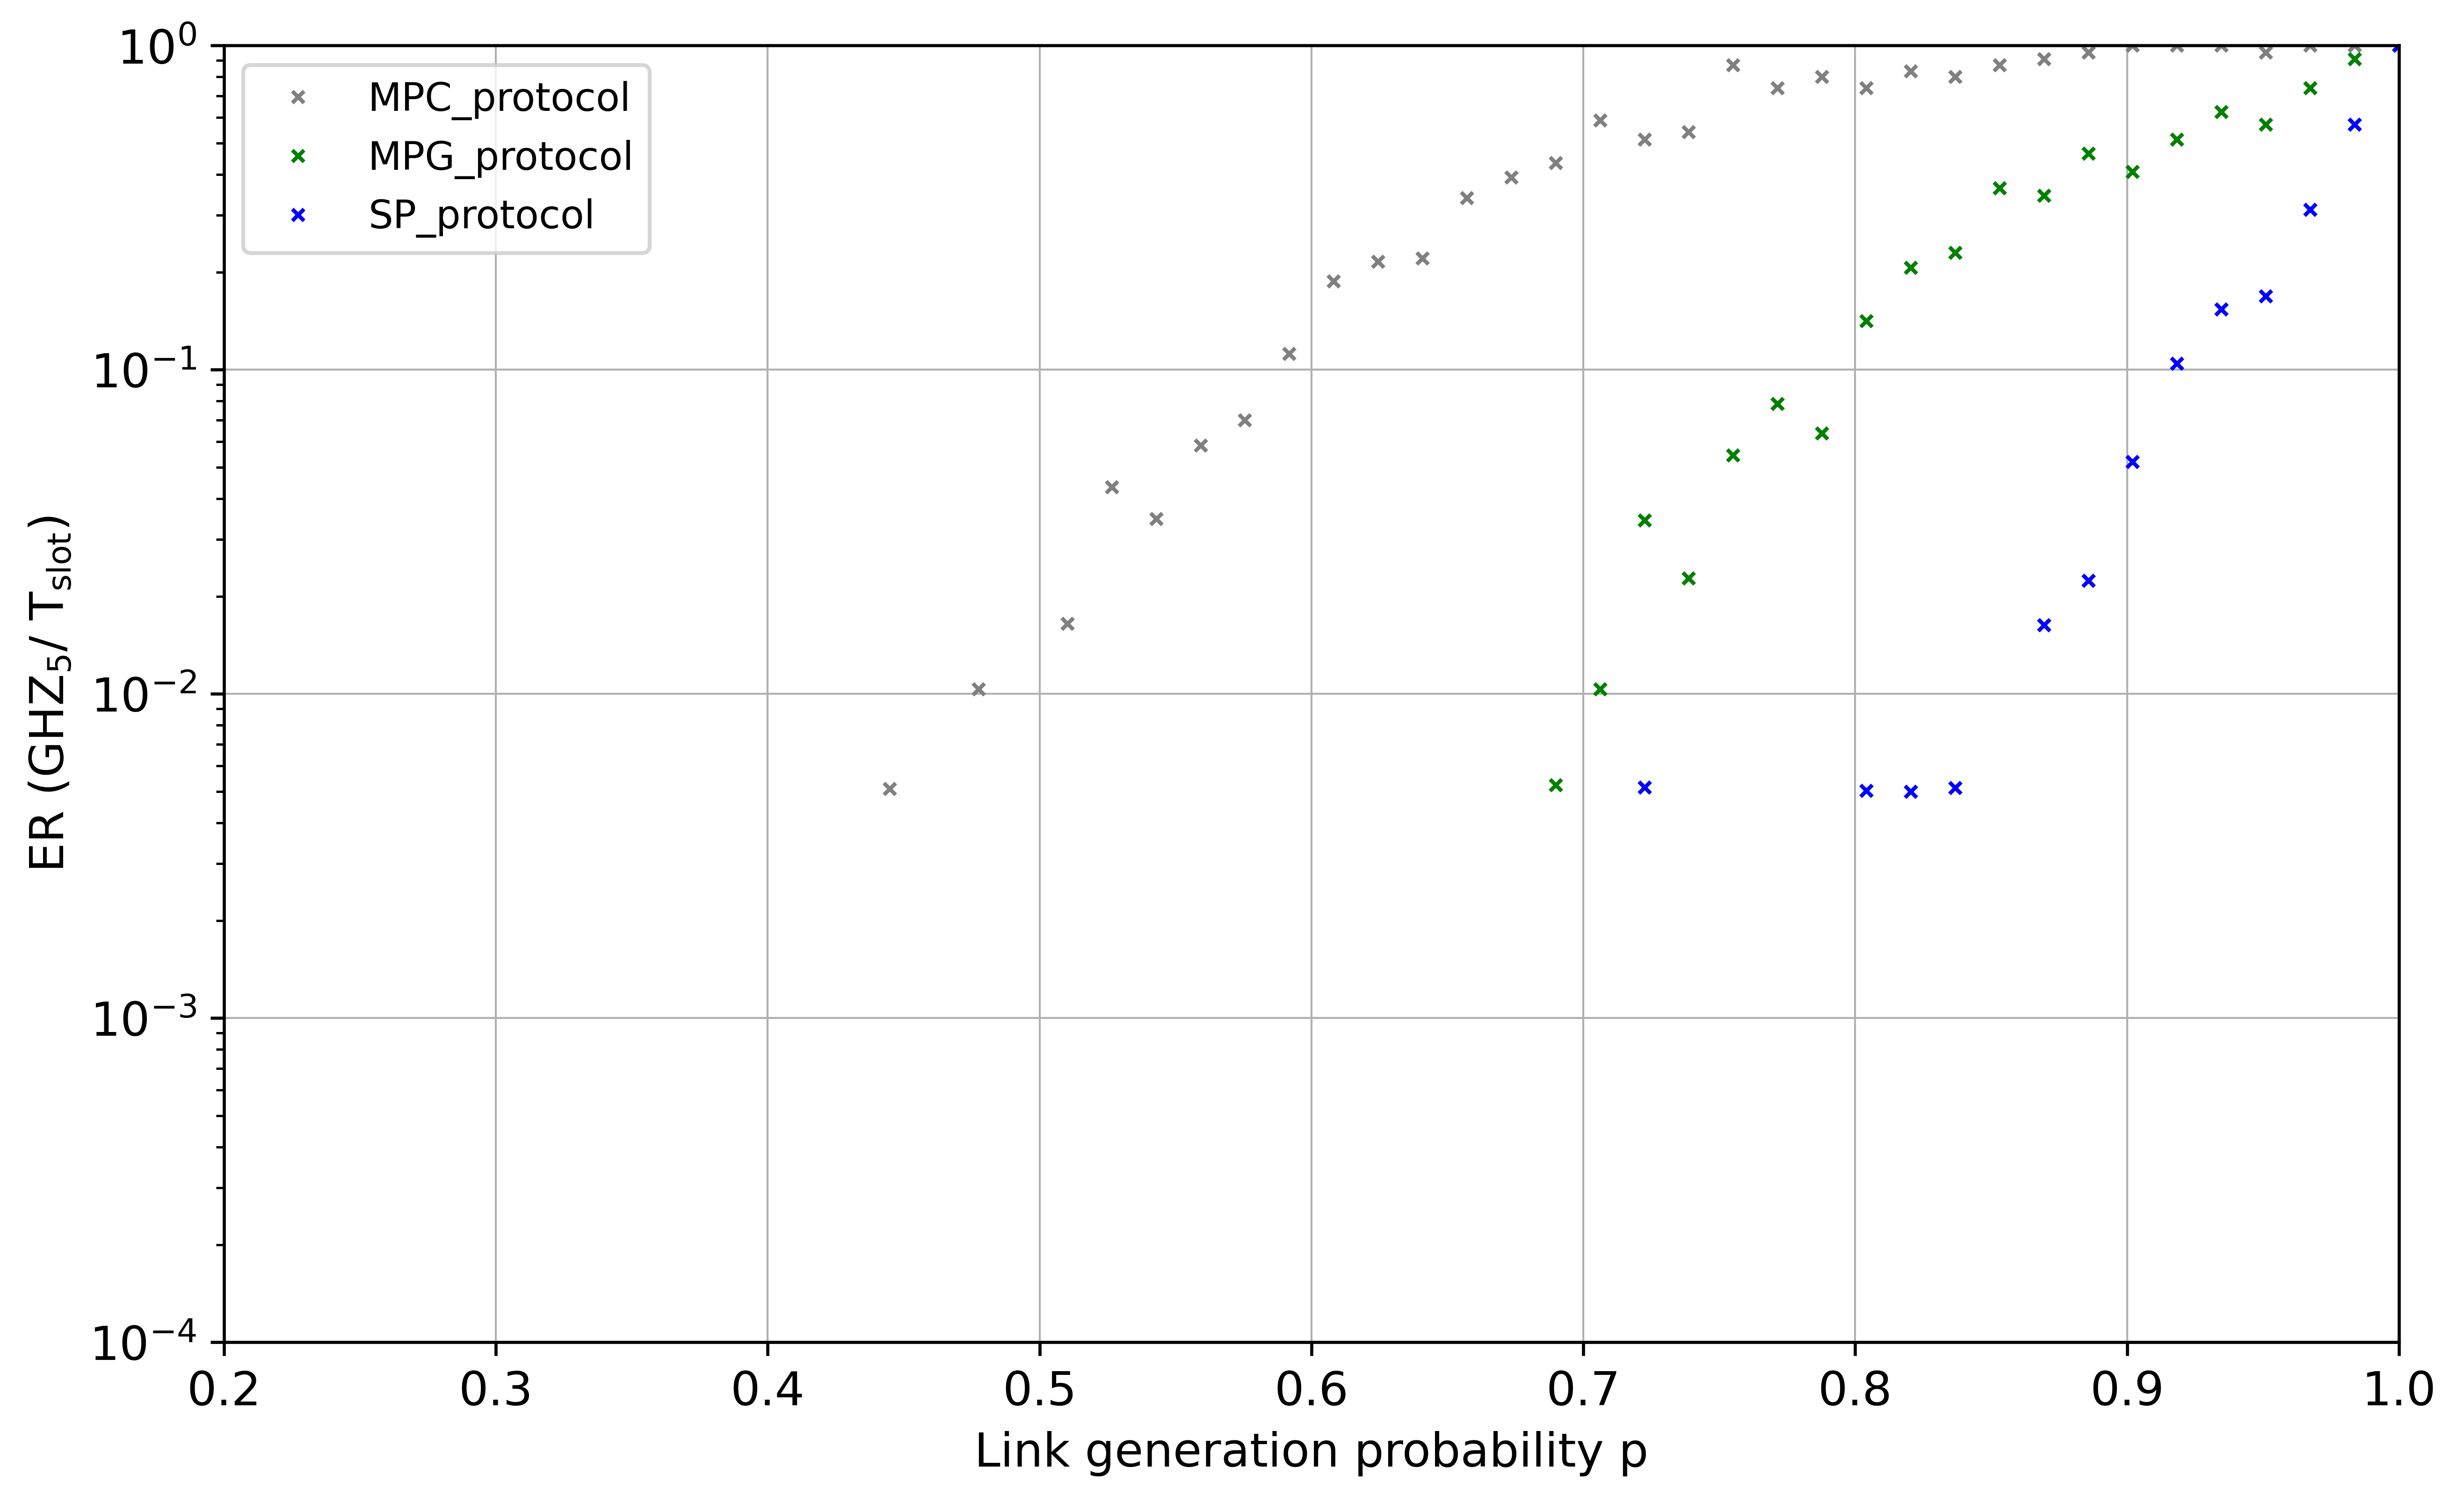

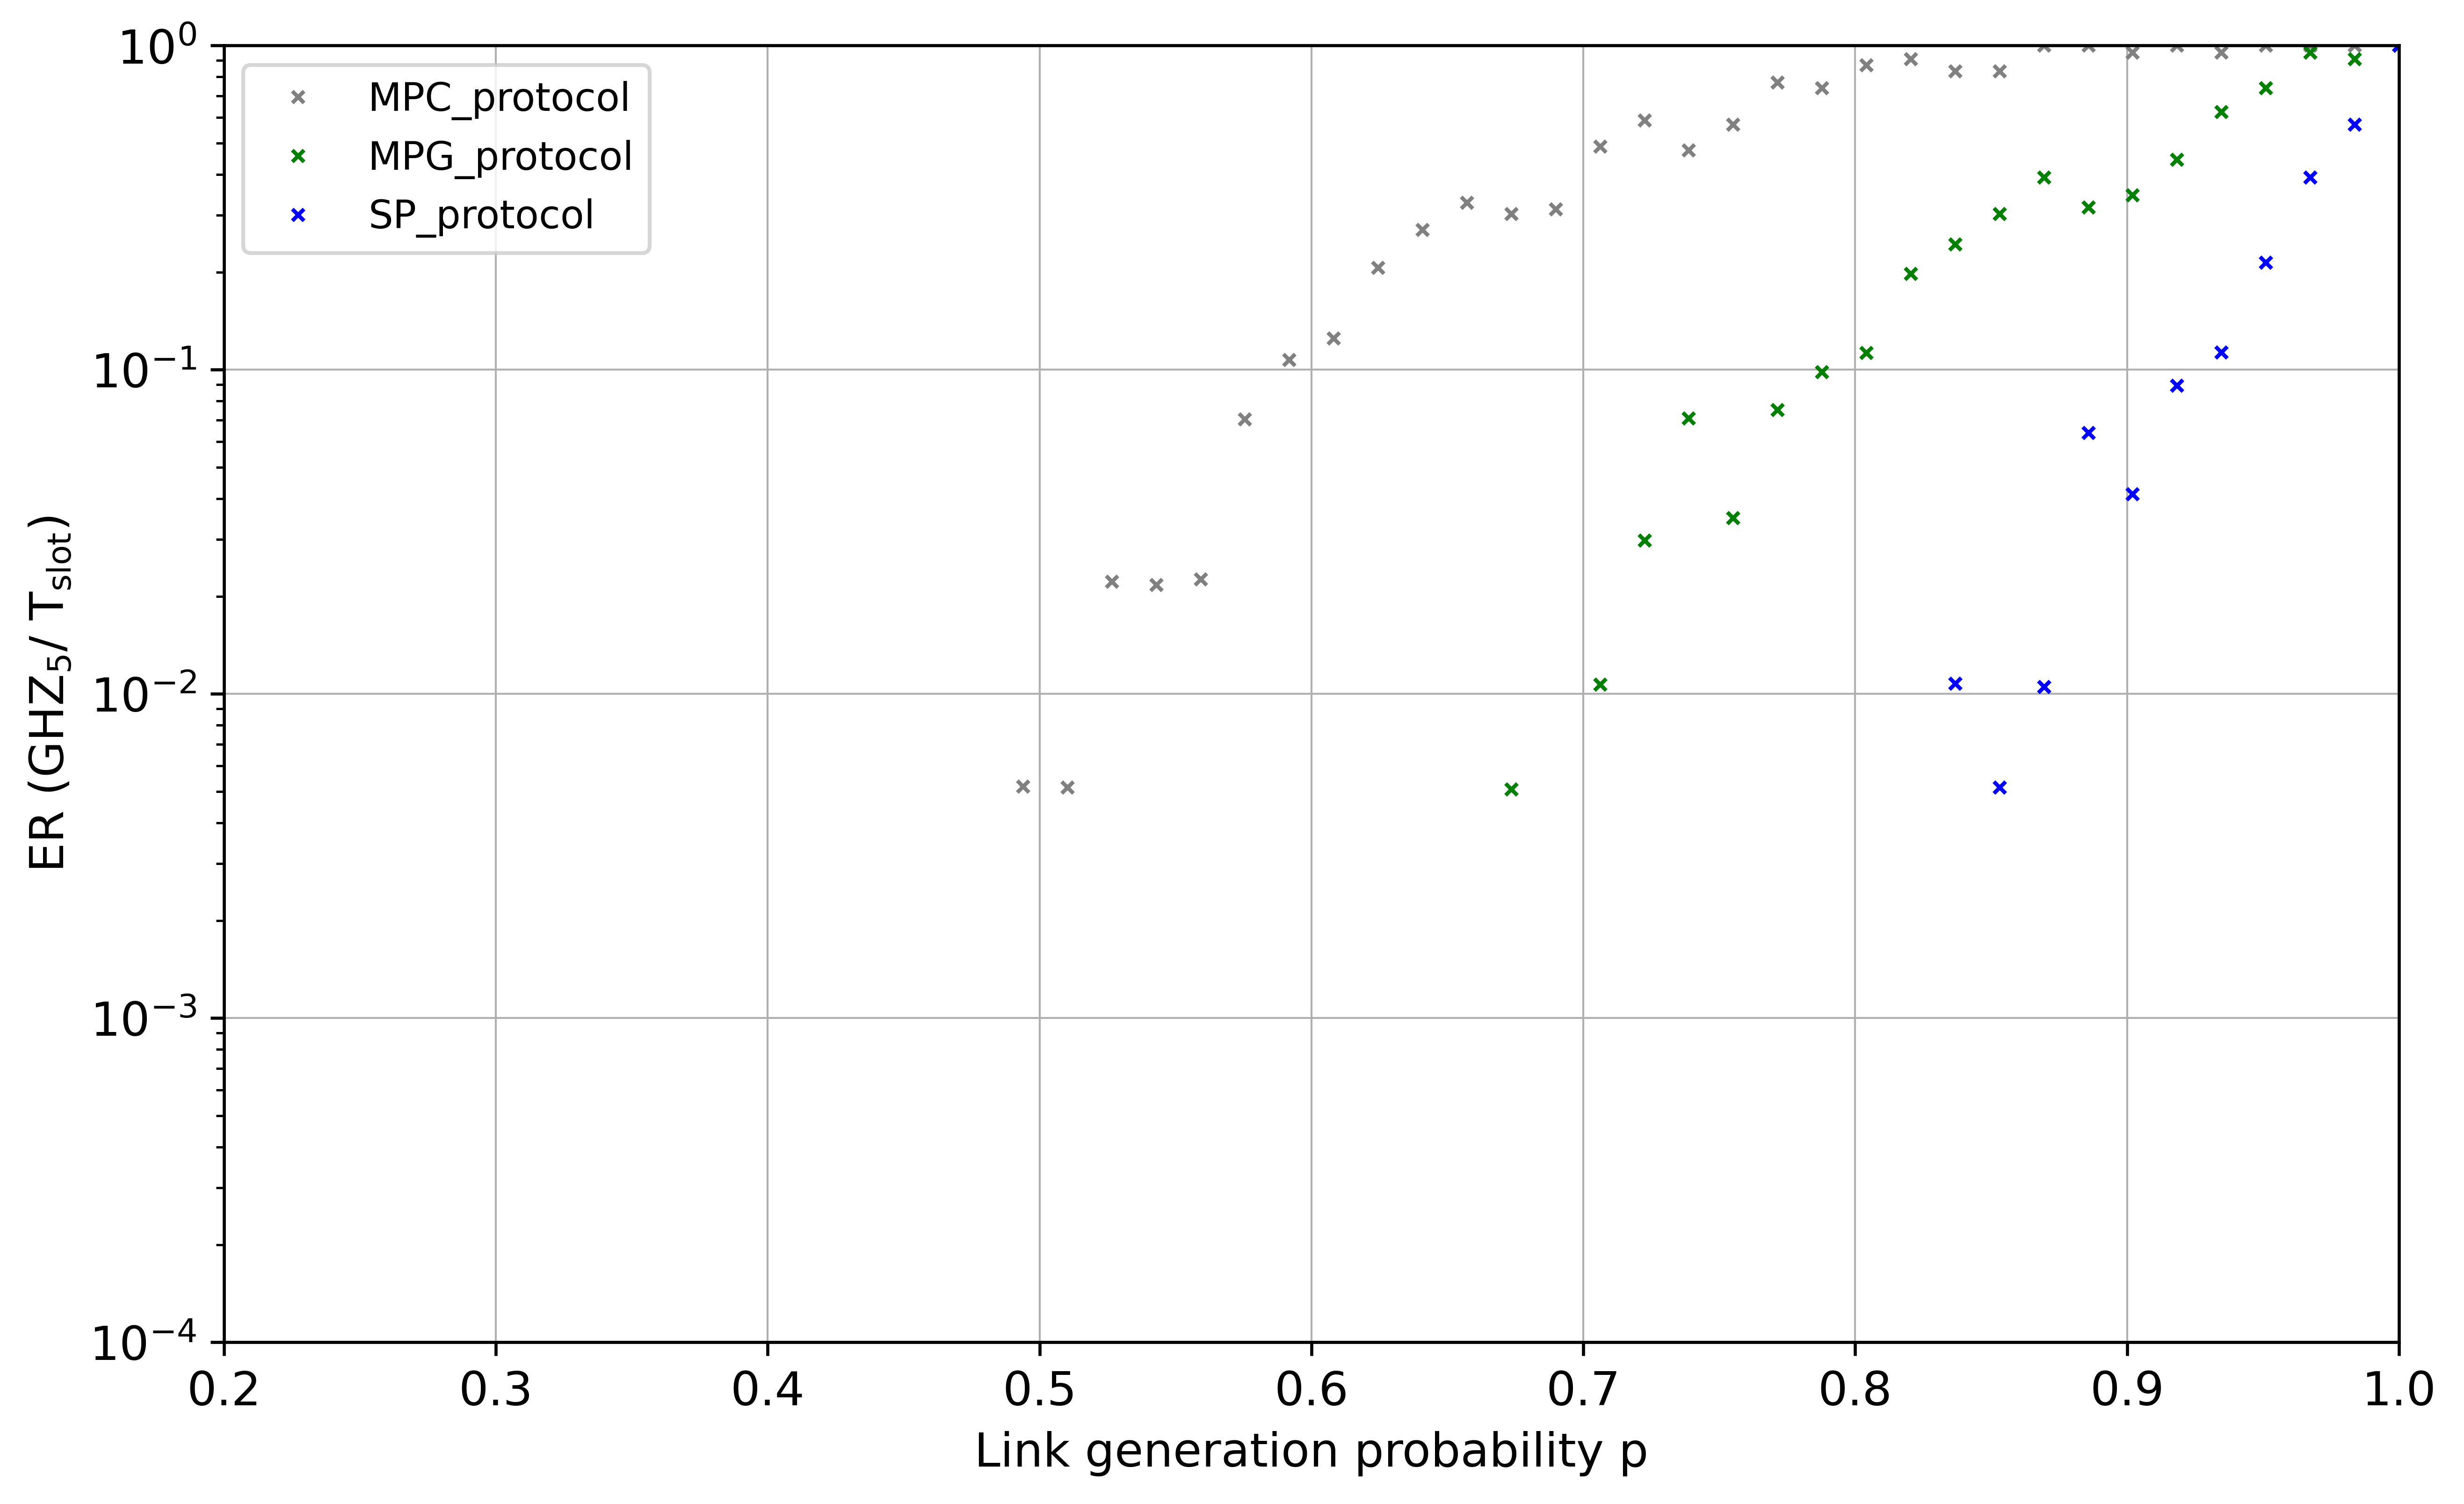

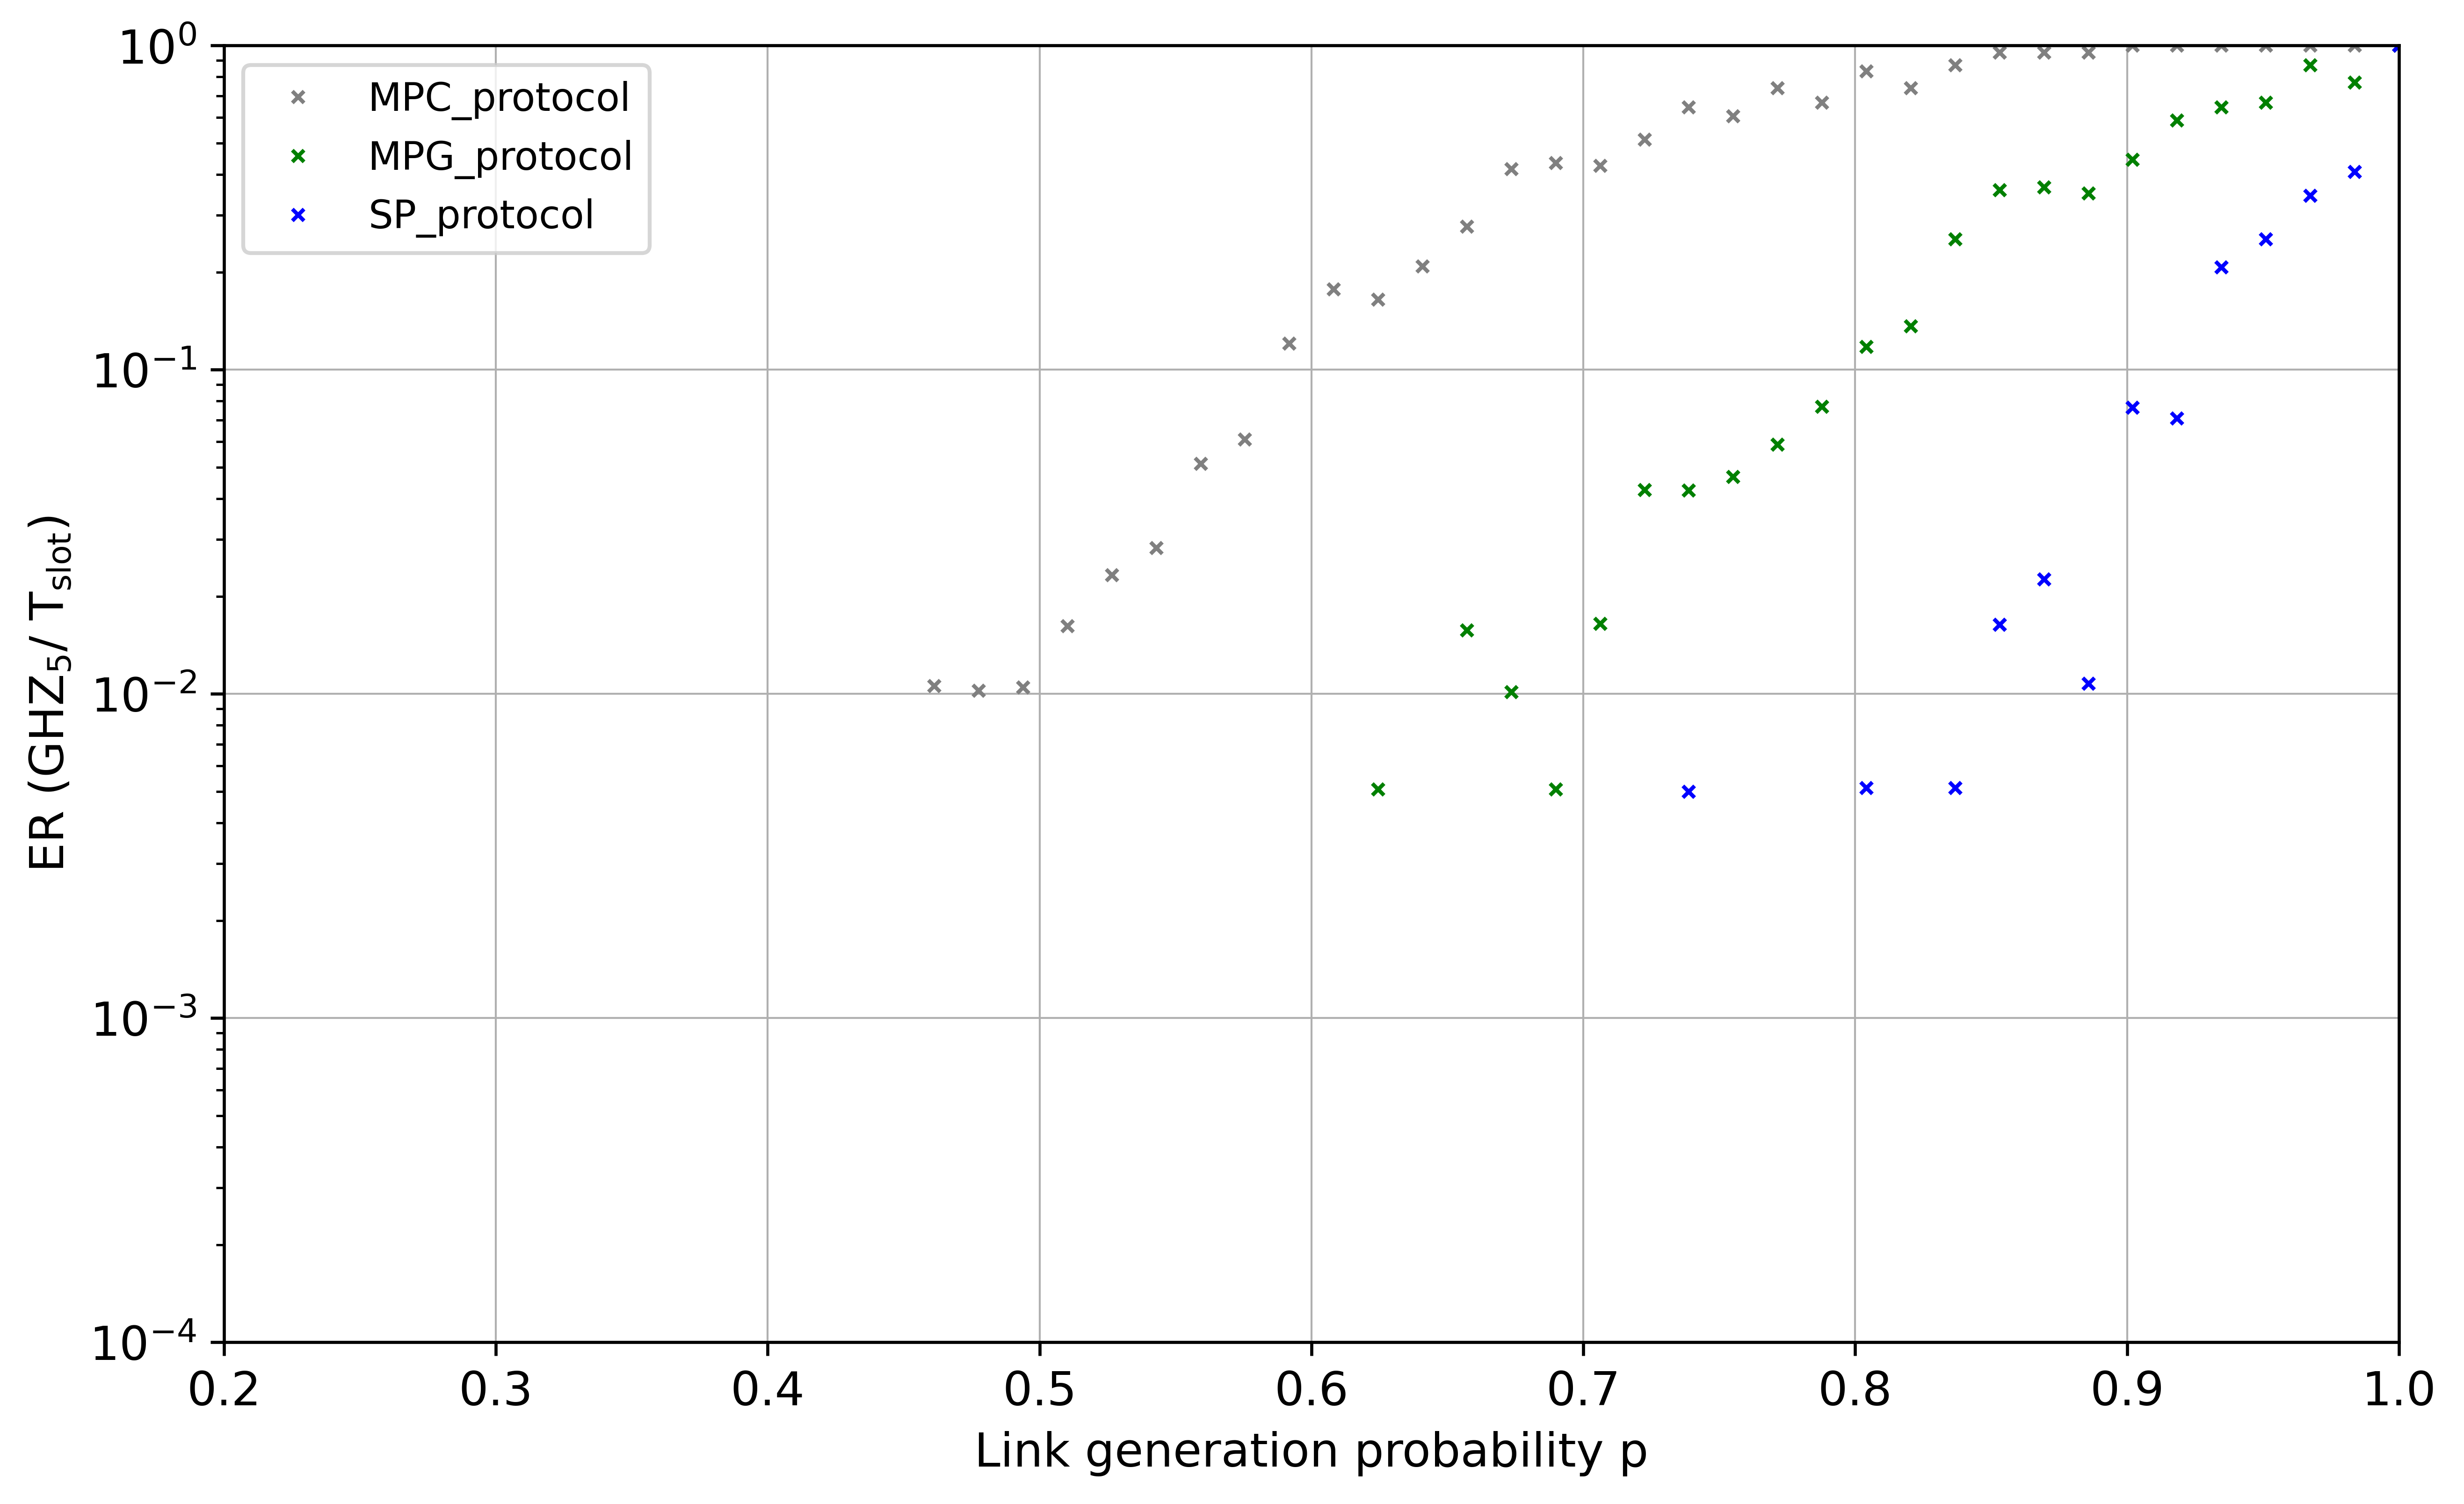

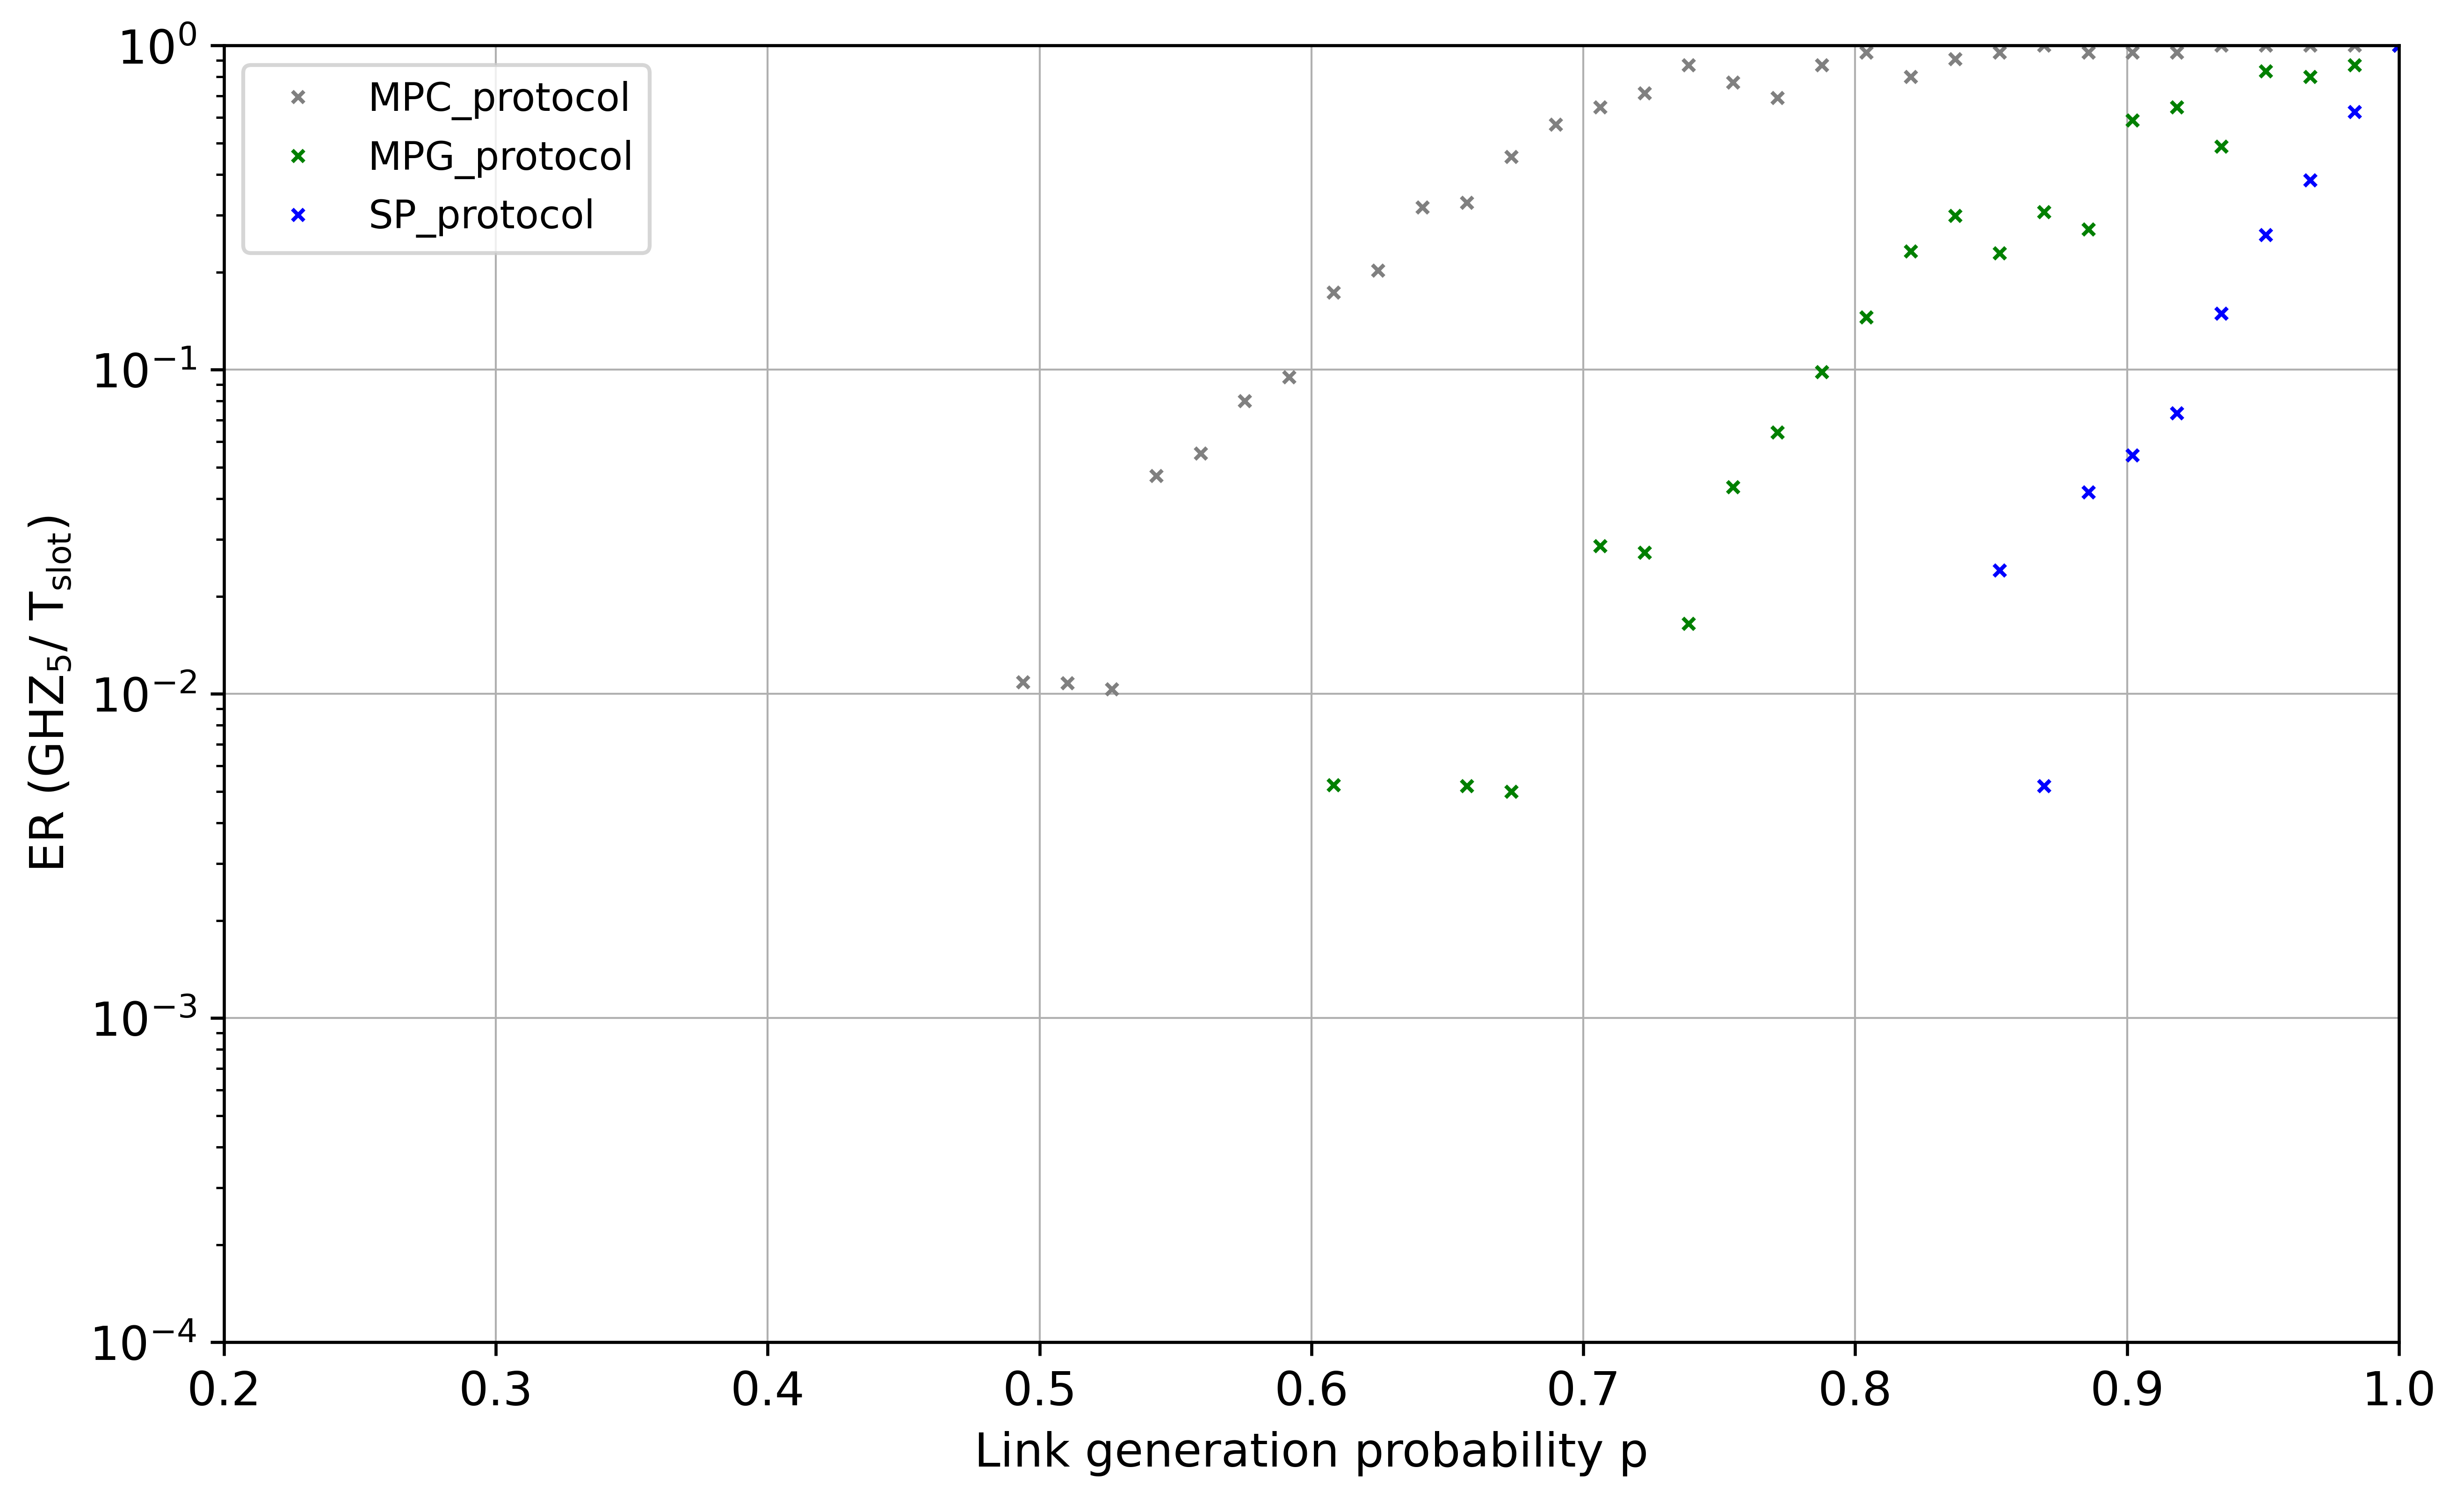

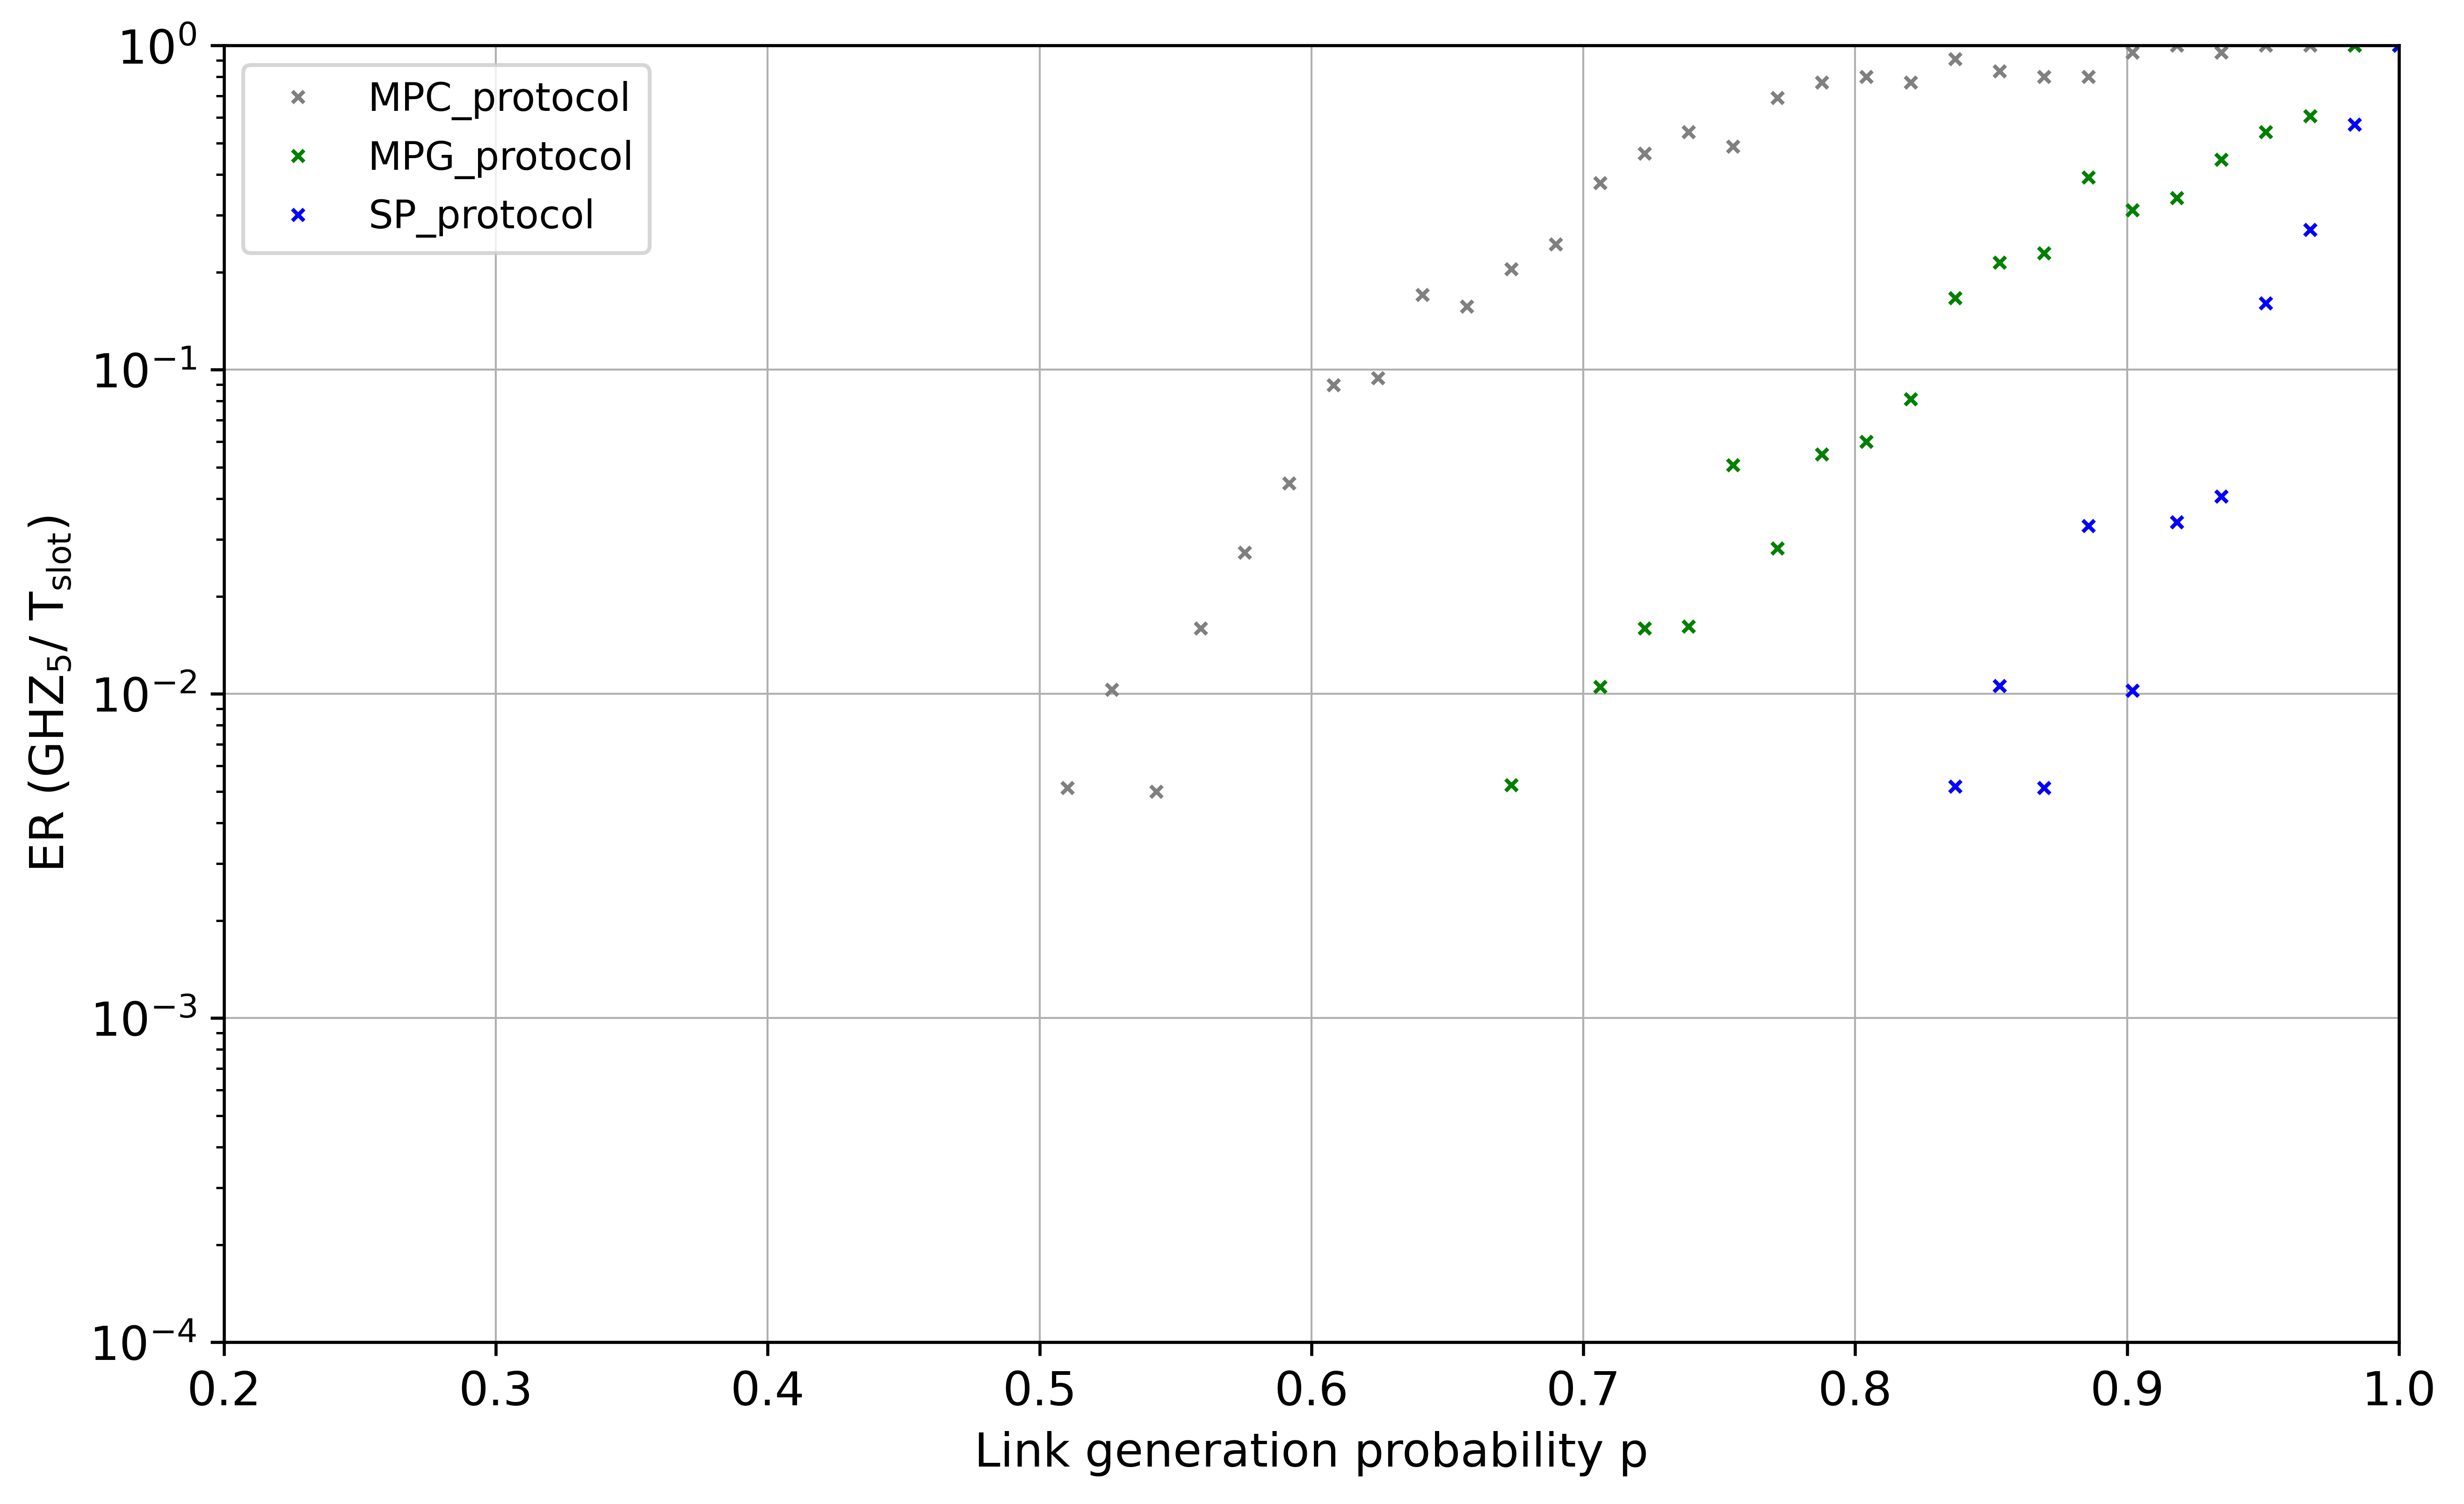

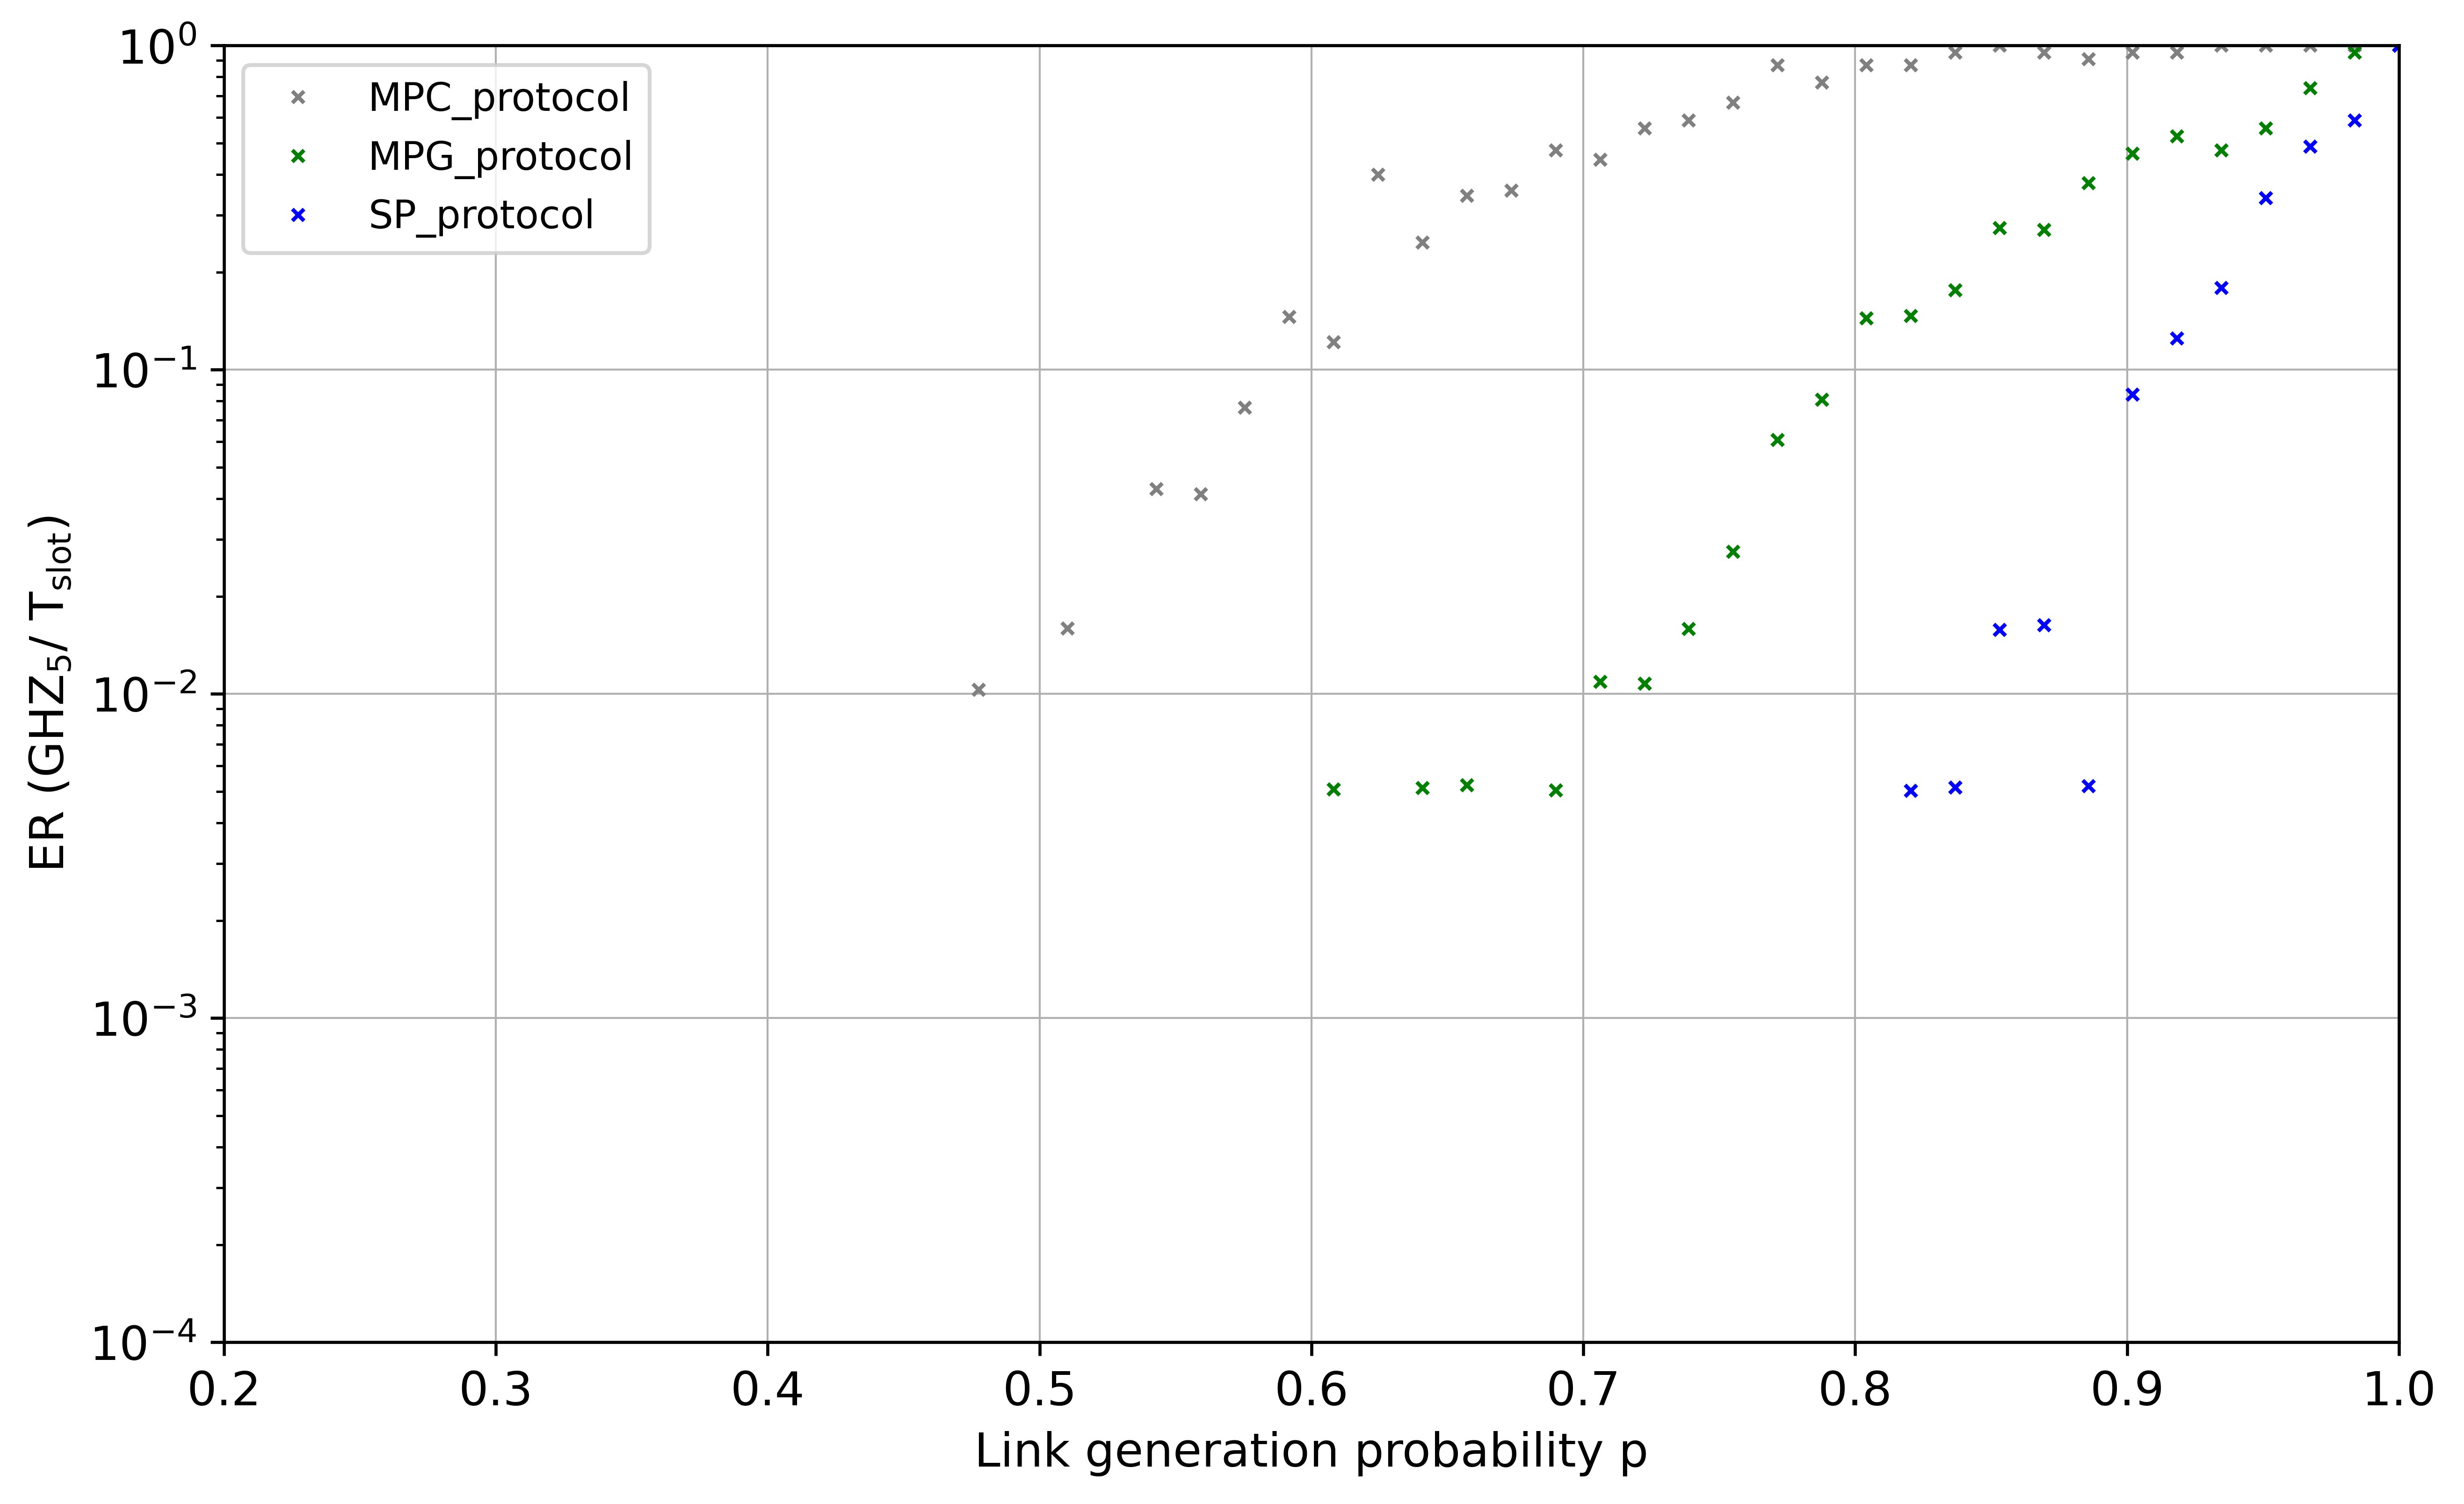

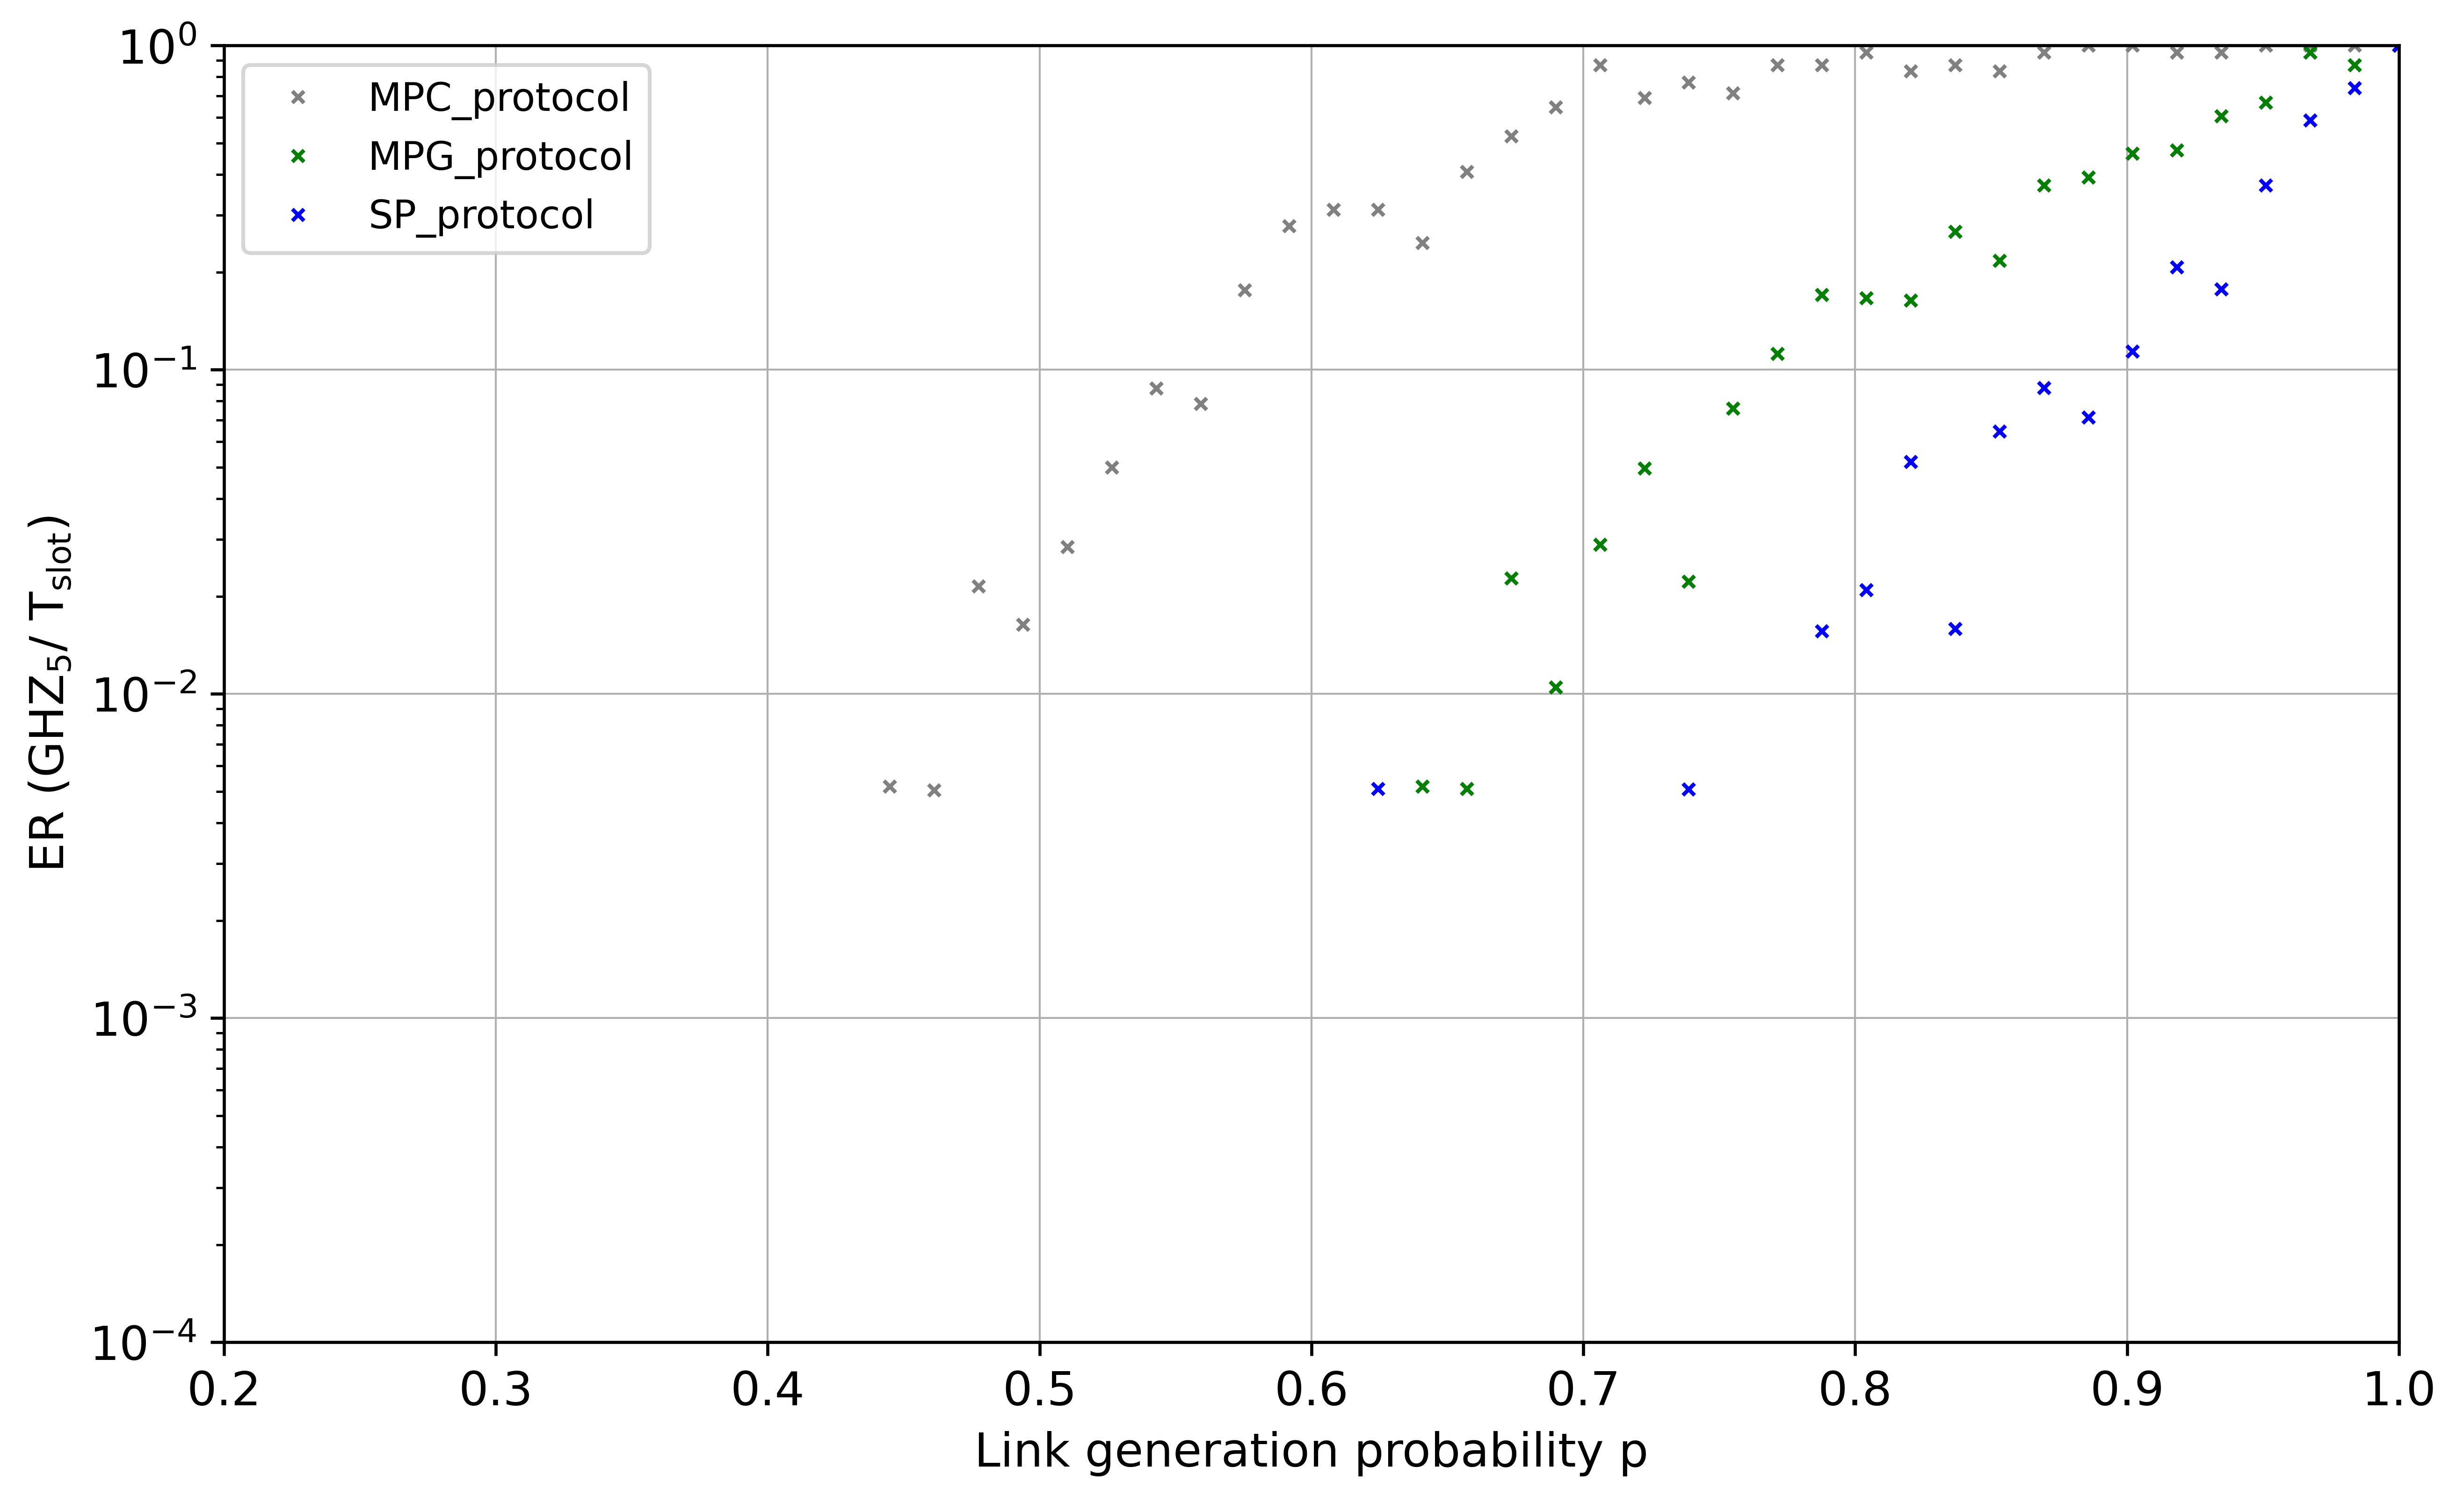

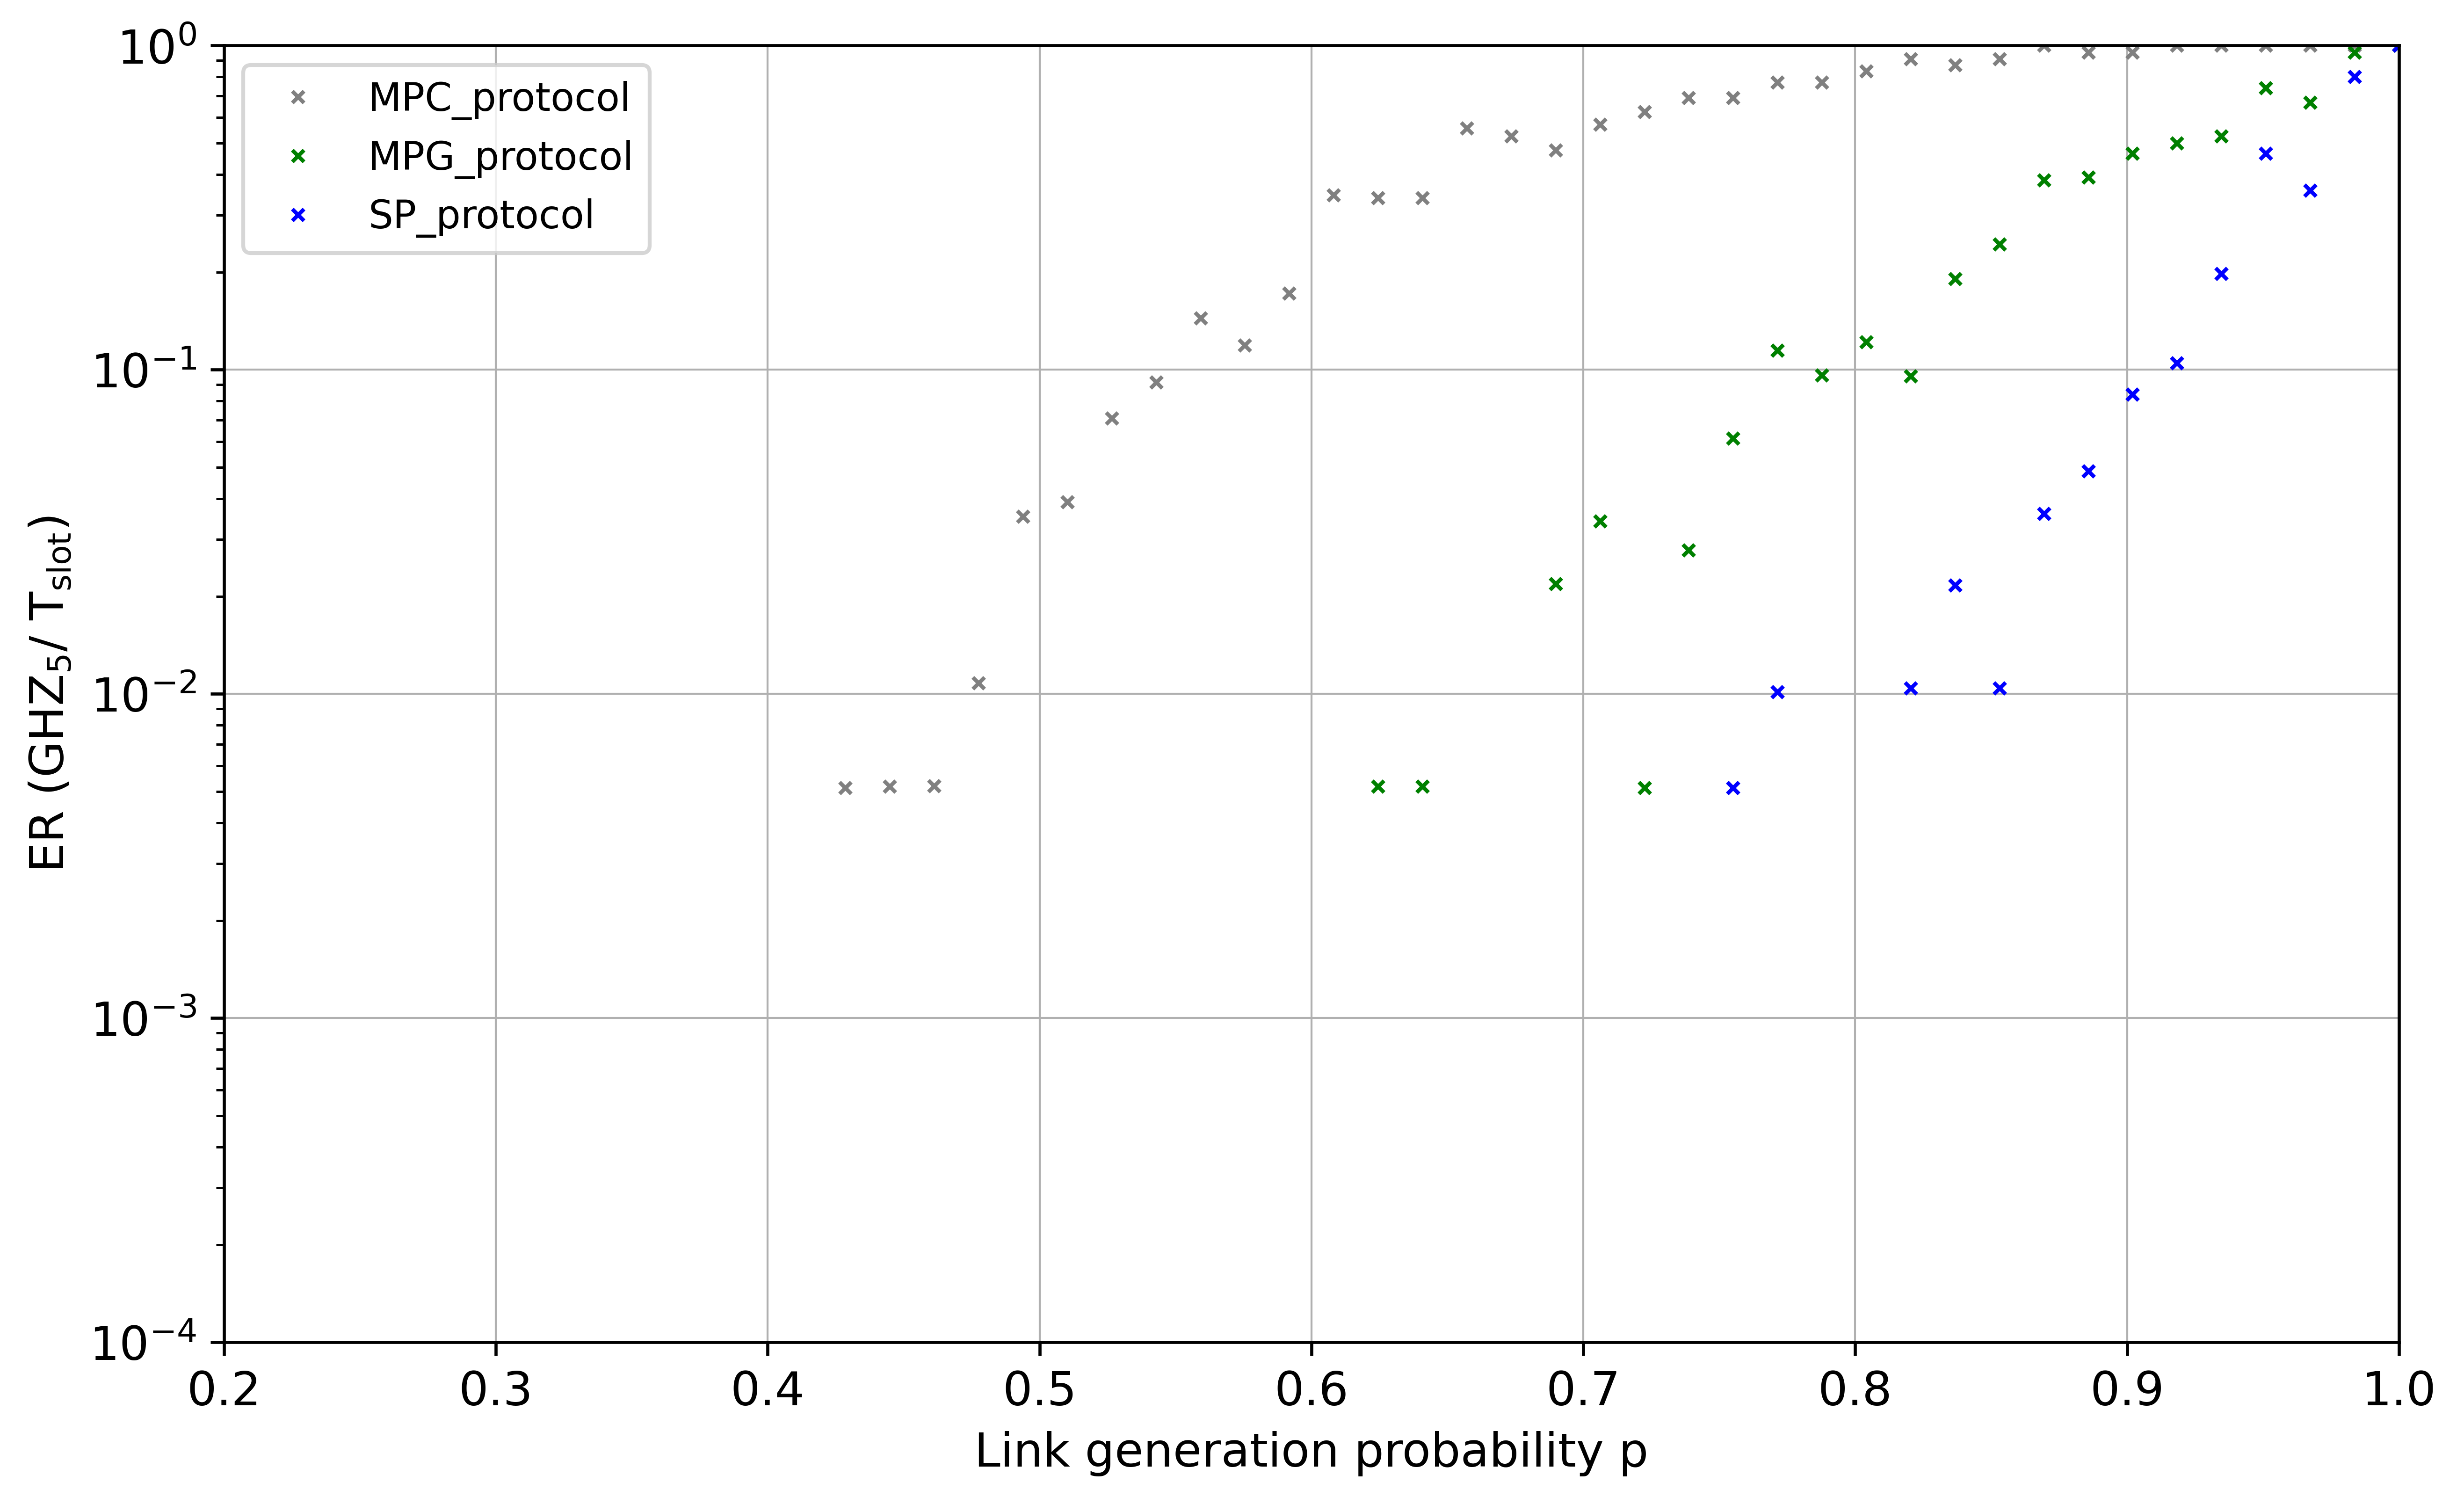

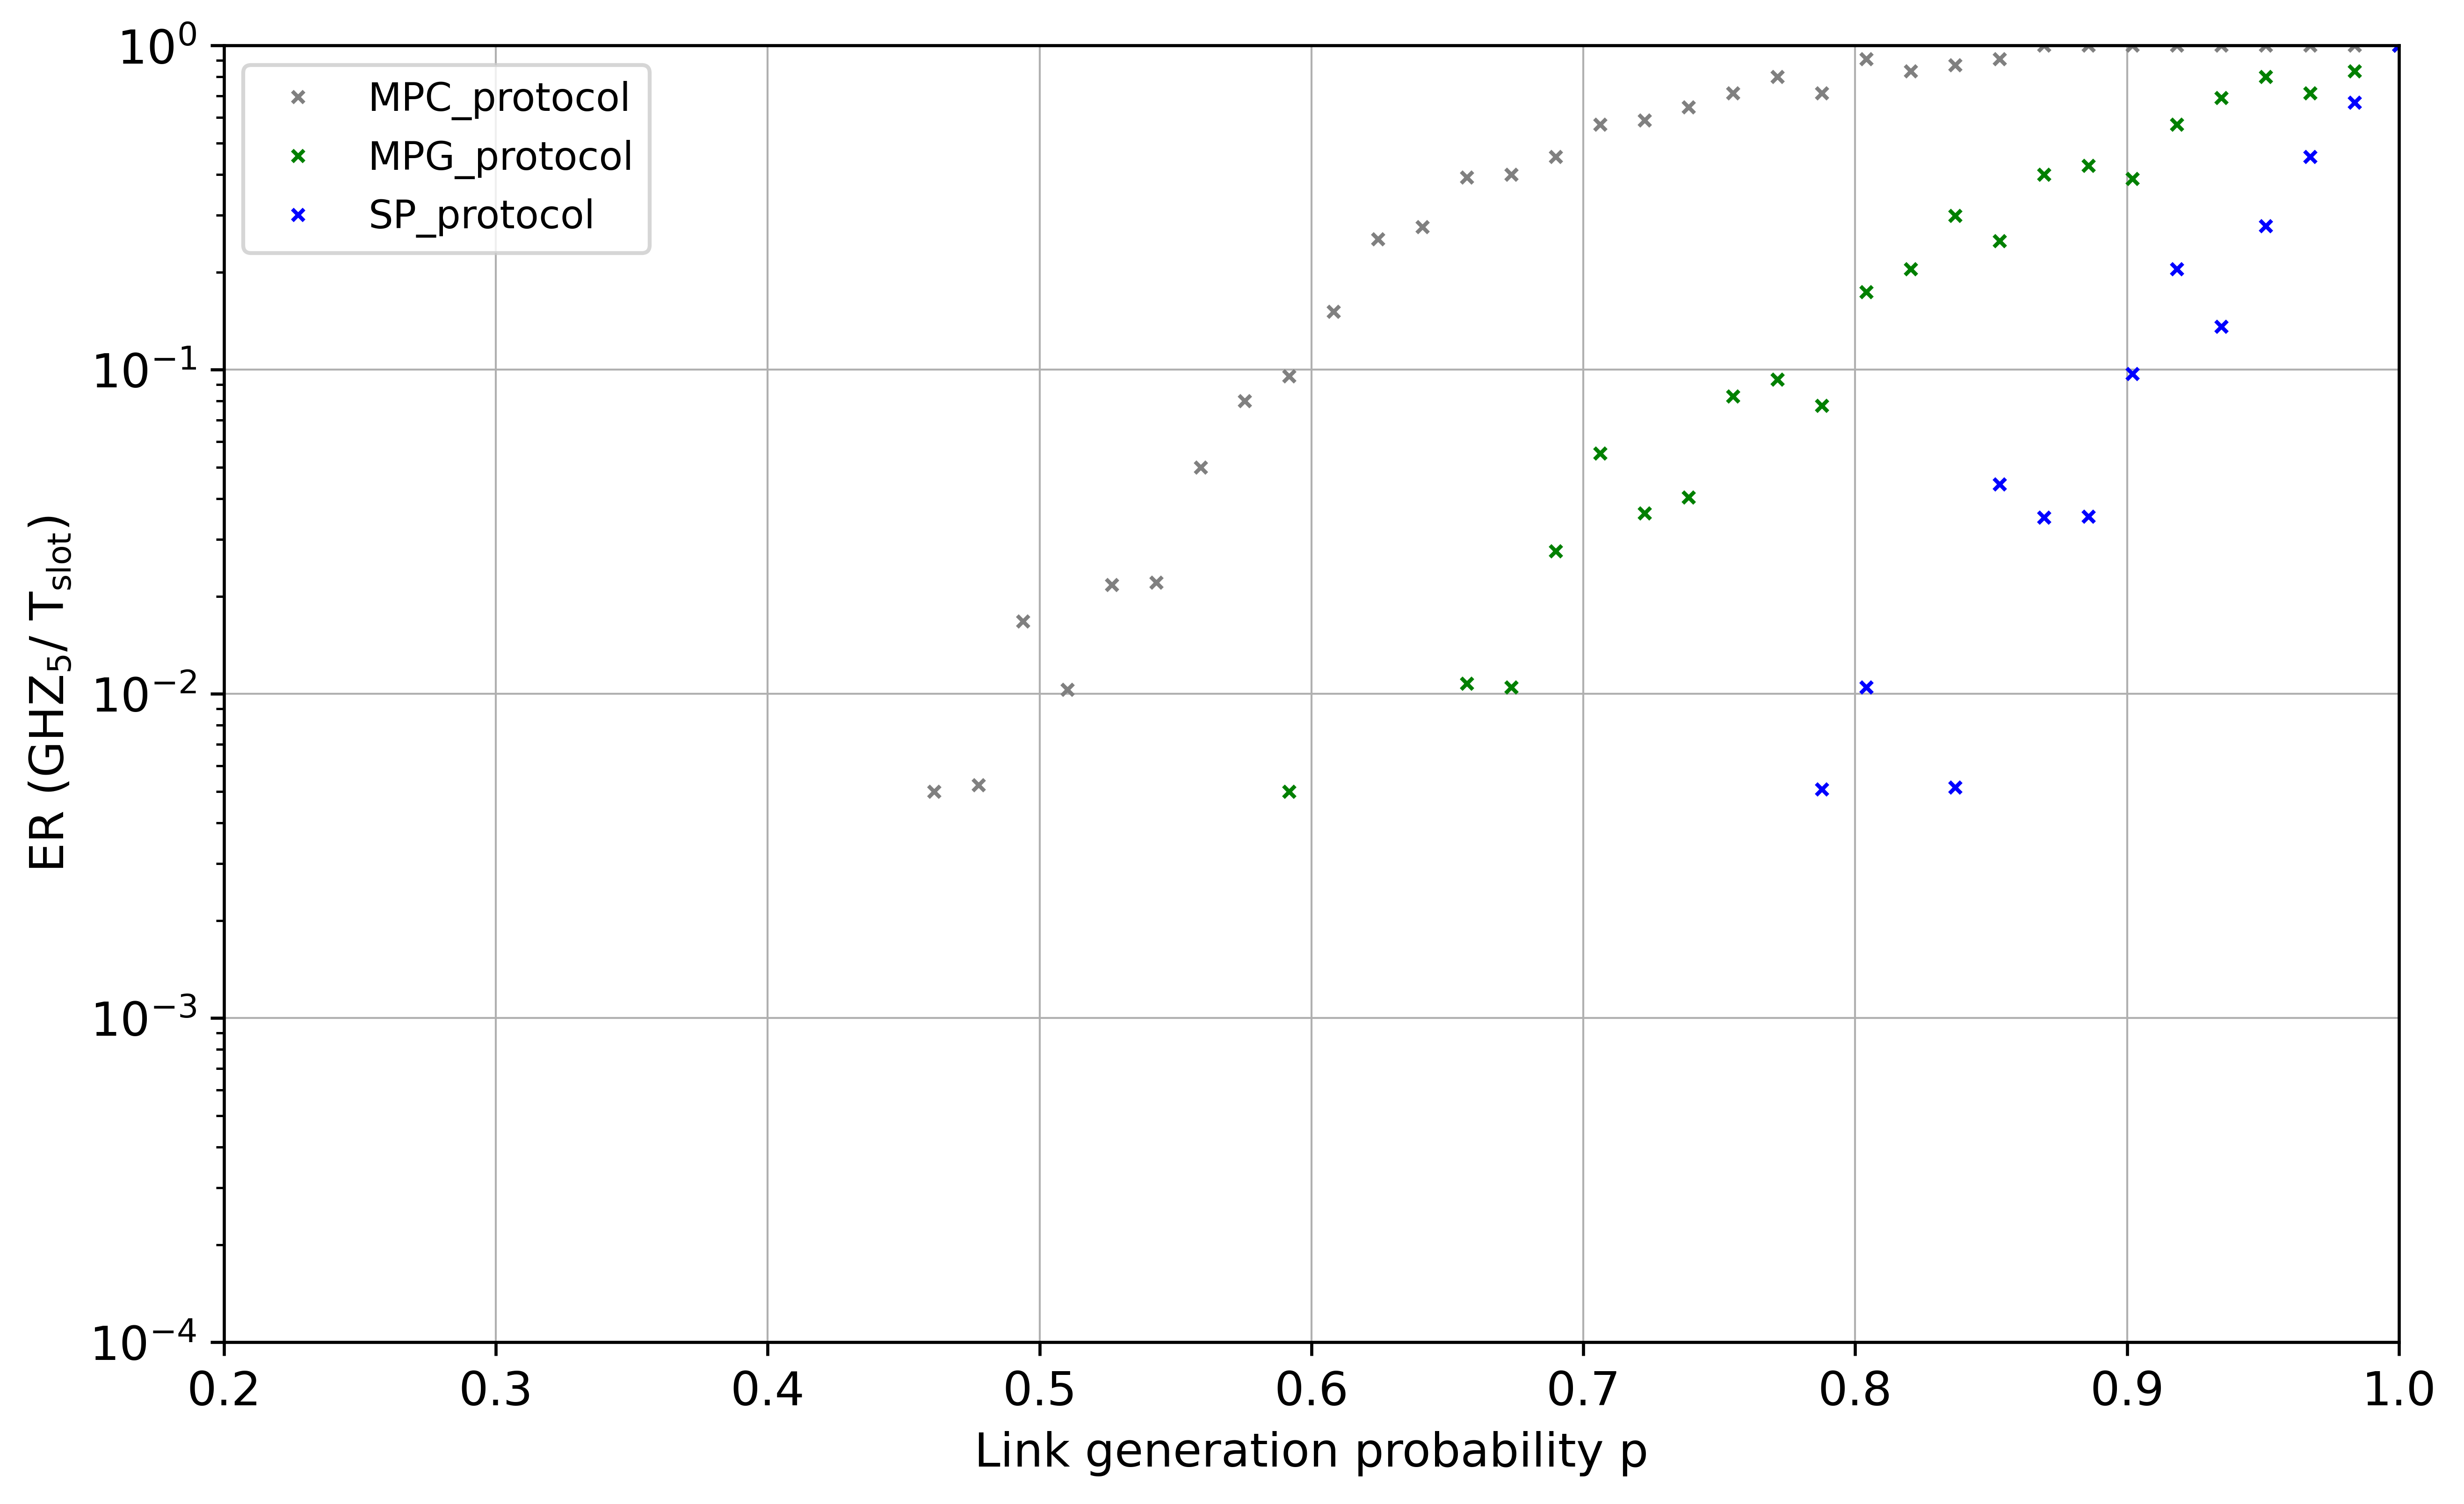

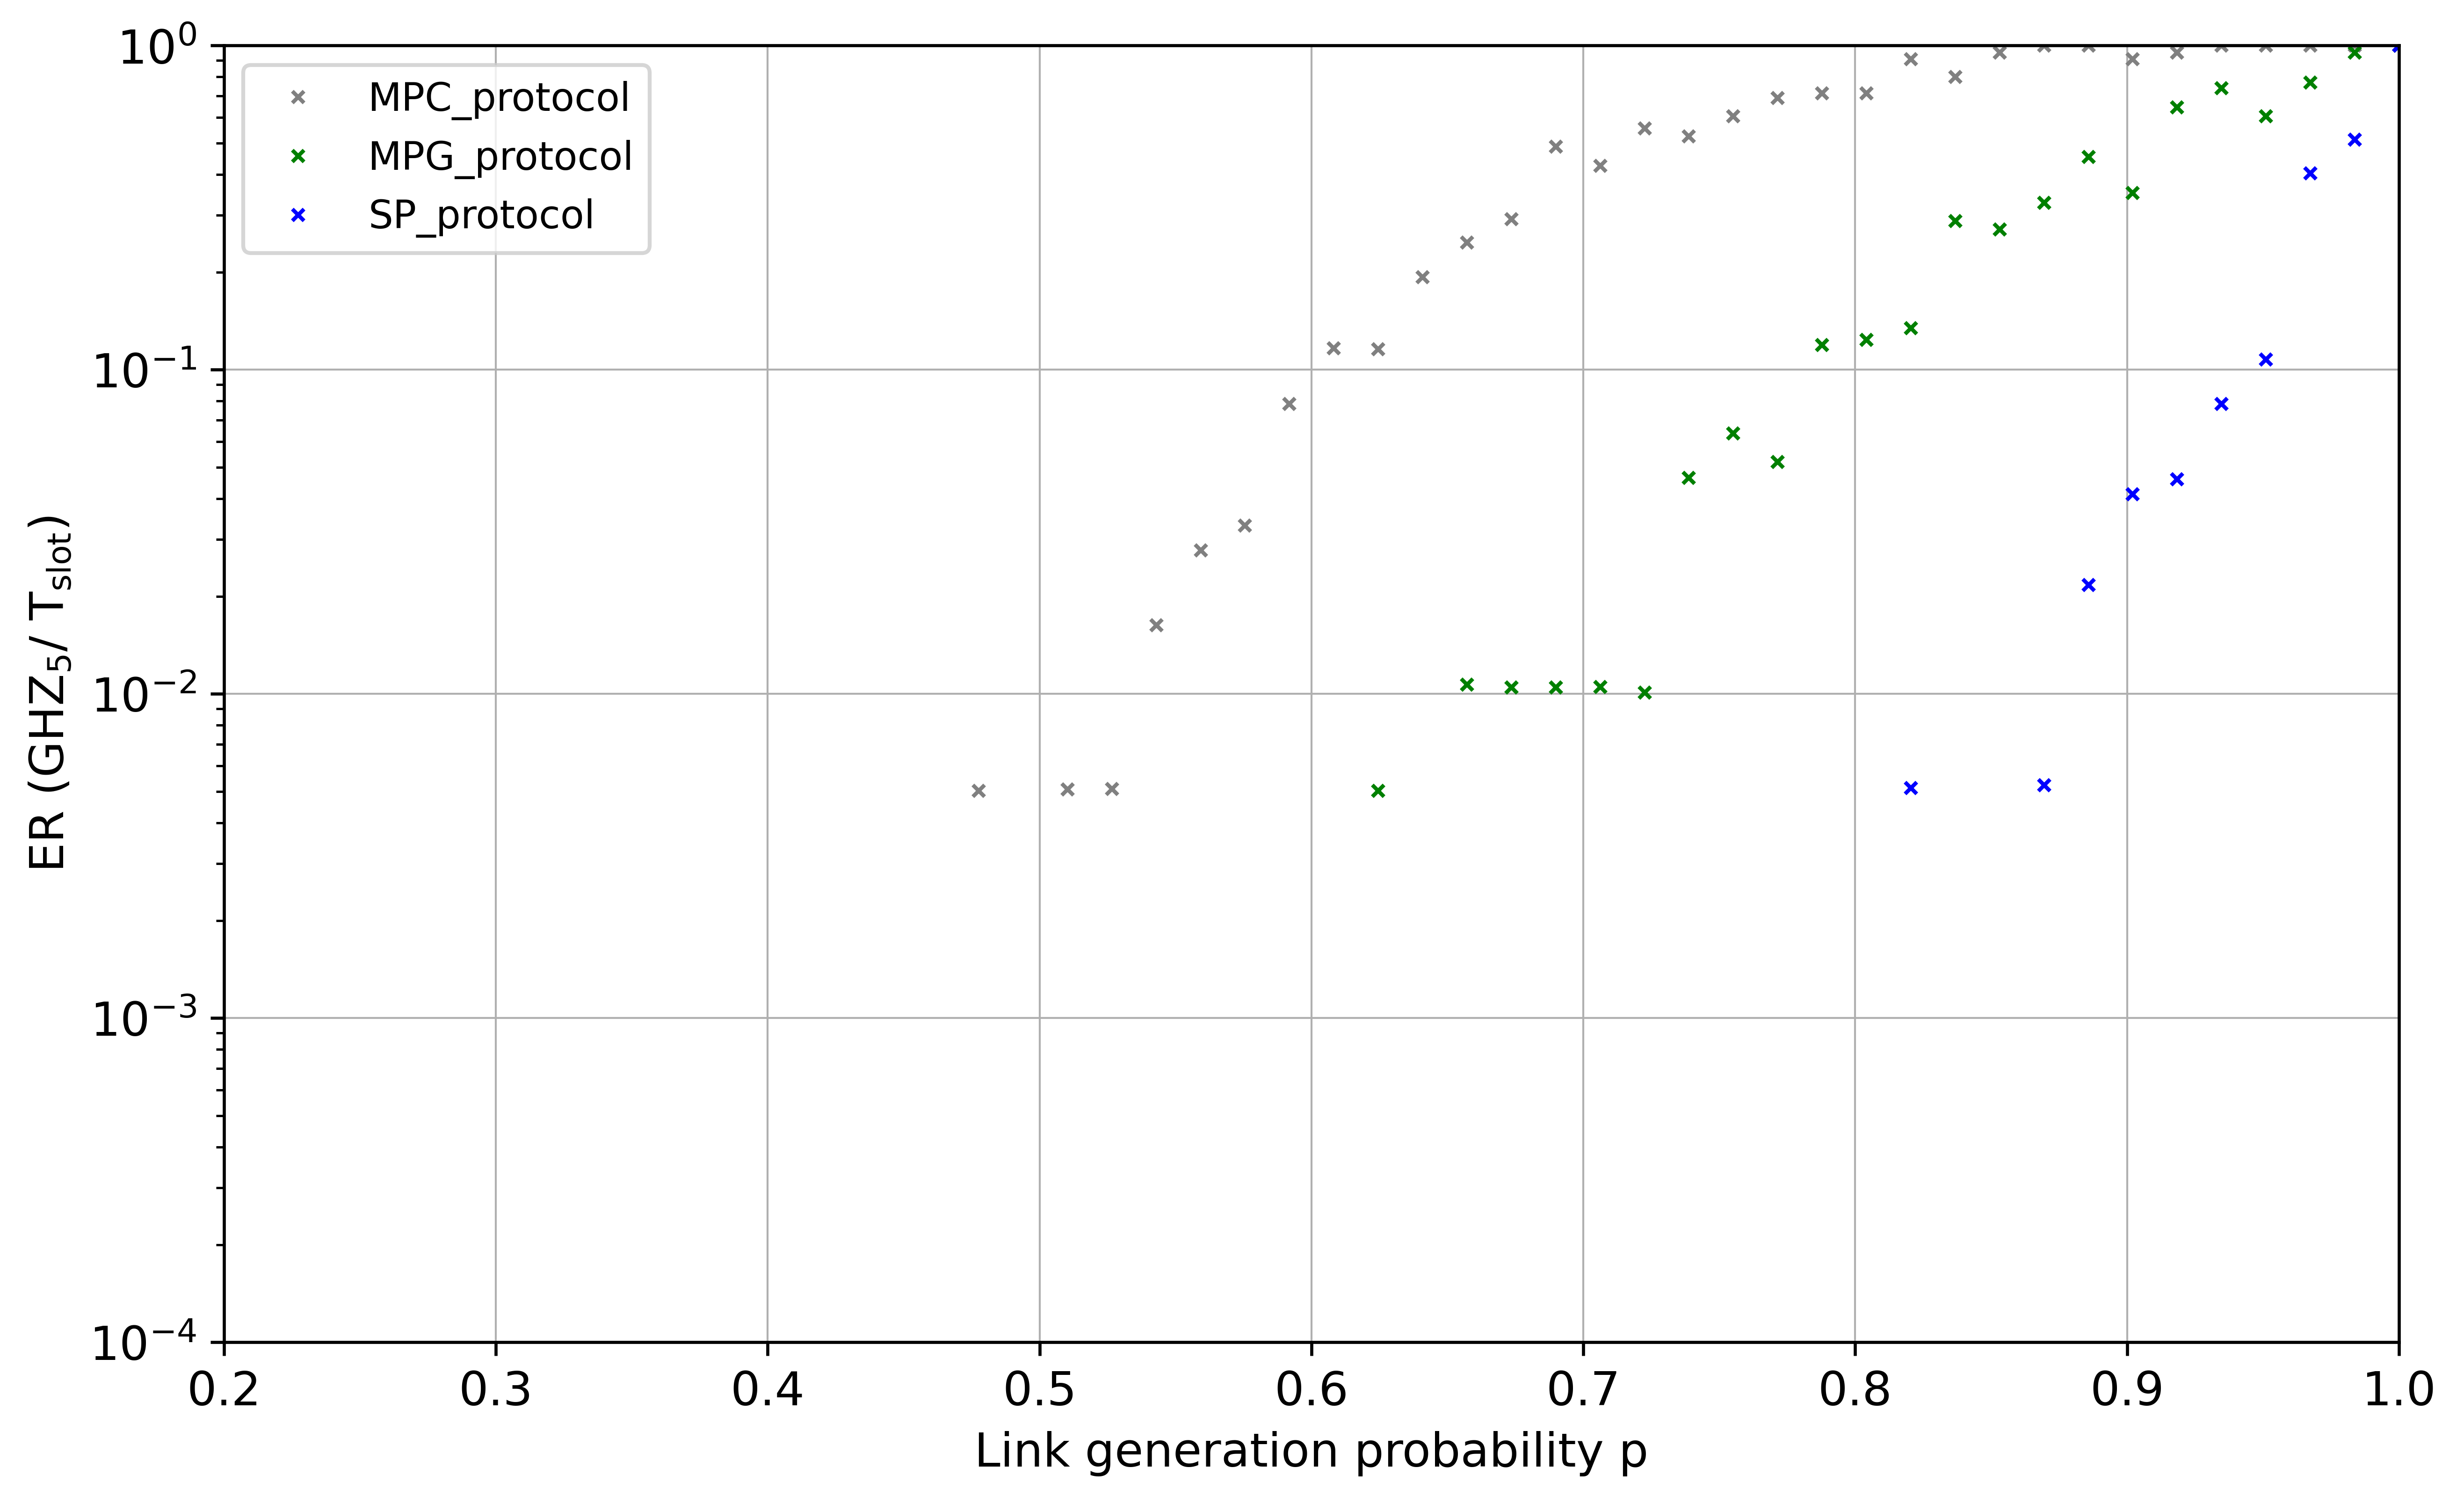

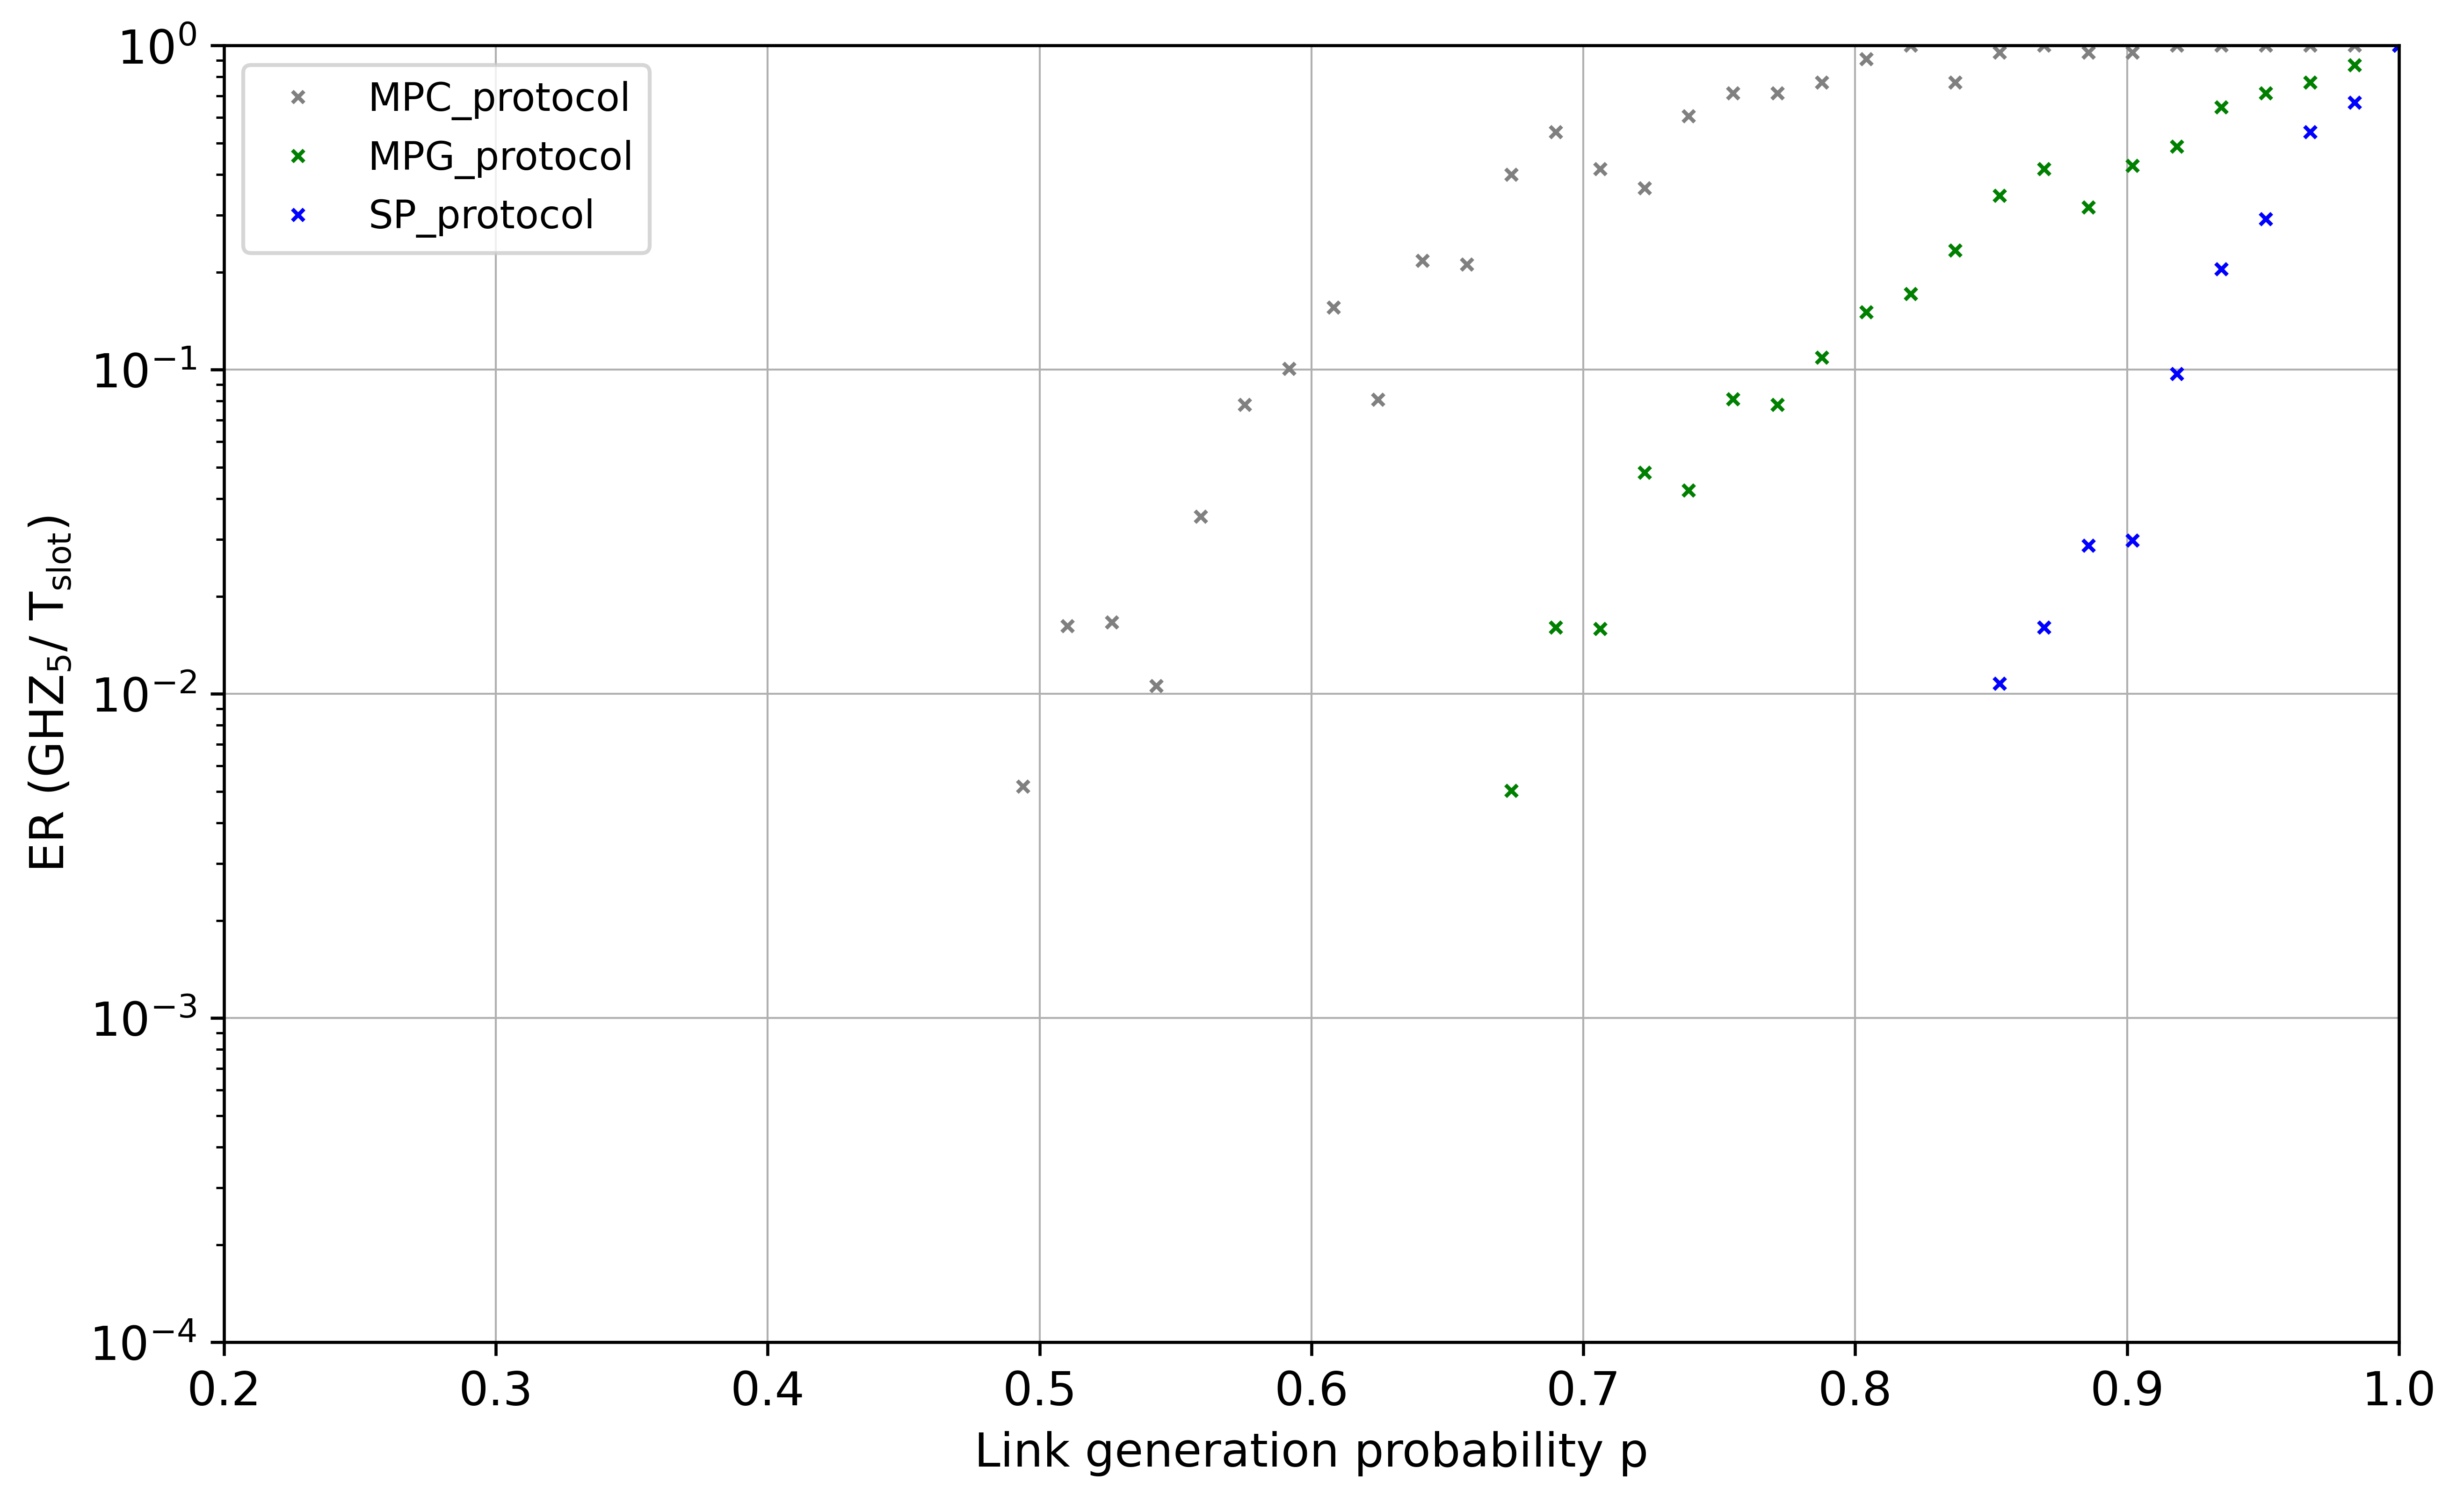

In [ ]:
# ============== 2) 全局参数 ==============
funcs = [MPC_protocol, MPG_protocol, SP_protocol]
p_range = np.linspace(1, 0.2, 50)

timesteps = 10
reps = 20
alpha = 1.4
beta = 0.105
max_rounds = 10
shuffle_nodes = True


sr_results = []  # 每个文件的 SR 结果都会追加到这里

# 分段退出：针对“组合”数量
chunk_size = 300  
state_file = "loop_state.pkl"

# ============== 3) 读取/初始化进度 ==============
try:
    with open(state_file, "rb") as f:
        progress = pickle.load(f)
    print("恢复进度：", progress)
except FileNotFoundError:
    progress = {
        "subfolder_idx": 0,   # 当前处理到第几个子文件夹
        "file_idx": 0,        # 当前子文件夹内处理到第几个文件
        "combo_idx": 0,       # 当前文件内处理到第几个组合
        "global_combo_count": 0  # 全局已处理的组合数
    }
    print("未发现进度文件，从头开始。")

# 子文件夹列表
subfolders = [sf for sf in root_path.iterdir() if sf.is_dir()]
subfolders.sort()

# ============== 4) 主循环 ==============
for s_idx in range(progress["subfolder_idx"], len(subfolders)):
    subfolder = subfolders[s_idx]
    if not subfolder.is_dir():
        continue

    print(f"Processing subfolder: {subfolder}")

    # 遍历文件
    files = [f for f in subfolder.iterdir() if f.is_file()]
    files.sort()

    for f_idx in range(progress["file_idx"], len(files)):
        file = files[f_idx]
        if not file.is_file():
            continue

        print(f"  Processing file: {file} ...")

        # 每个文件：初始化 counters
        failure_counts = {func.__name__: 0 for func in funcs}
        combination_counter = 0

        # 加载图
        G, users, pos = load_data(file)
        nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
        plt.close()

        G = network(G)

        # 输出路径
        class_folder = subfolder.name
        file_path = file.with_suffix(".png")
        file_name = file_path.name

        er_folder_path = Path.cwd().parent.joinpath("new_result", class_folder)
        er_folder_path.mkdir(exist_ok=True)
        er_topology_folder_path = er_folder_path.joinpath(file_name)
        er_topology_folder_path.mkdir(exist_ok=True)
        communities_output_path = Path.cwd().parent.joinpath("communitie", class_folder, file_name)

        communities, users_node_combination = multi_iterative_score_partition_with_drawing(
            G, users[0], alpha, beta, max_rounds, shuffle_nodes, pos, communities_output_path
        )

        sampled_combinations = np.random.choice(
            len(users_node_combination),
            size=min(100, len(users_node_combination)),
            replace=False
        )


        # 遍历本文件100个组合
        for sampled_idx, original_idx in enumerate(sampled_combinations):
            combo = users_node_combination[original_idx]
            combination_counter += 1
            progress["global_combo_count"] += 1


            # =========== 新增：组合详细信息 ===========
            combination_sr = {
                "Combination_ID": f"combo_{sampled_idx}",
                "Nodes": str(combo),  # 将节点列表转为字符串，如 "[2,5,9]"
            }

            # 计算 ER
            ER = np.zeros((len(funcs), len(p_range)))
            results = Parallel(n_jobs=-1, verbose=10)(
                delayed(process_single_p)(G, combo, p, funcs, timesteps, reps)
                for p in p_range
            )

            # 将结果填充到 ER 矩阵
            for i, p_ers in enumerate(results):
                ER[:, i] = p_ers

            plot_er_vs_p(p_range, ER, funcs, cols, er_topology_folder_path.joinpath(f'result_for_{str(combo)}'))


            # =========== 计算成功率比例 ===========
            for func_idx, func in enumerate(funcs):
                protocol_er = ER[func_idx, :]
                zero_count = np.sum(protocol_er < 1e-10)
                success_ratio = 1 - (zero_count / len(p_range))  # 计算成功率比例
                combination_sr[func.__name__] = round(success_ratio, 3)  # 保留3位小数

            # 分段退出：每处理 chunk_size 个组合后退出
            if progress["global_combo_count"] % chunk_size == 0:
                print(f"已处理 {progress['global_combo_count']} 个组合，准备退出。")
                progress["subfolder_idx"] = s_idx
                progress["file_idx"] = f_idx
                progress["combo_idx"] = sampled_idx + 1  # 下次从下一个组合继续
                with open(state_file, "wb") as pf:
                    pickle.dump(progress, pf)
                exit()

            # 每个组合处理完更新进度
            progress["combo_idx"] = sampled_idx + 1
            progress["subfolder_idx"] = s_idx
            progress["file_idx"] = f_idx
            with open(state_file, "wb") as pf:
                pickle.dump(progress, pf)

            # =========== 写入CSV文件 ===========
            output_subfolder_csv_path = er_topology_folder_path.joinpath(f"{file.stem}_sr_details.csv")

            # 定义字段（首次运行时写入表头）
            fieldnames = ["Combination_ID", "Nodes"] + [func.__name__ for func in funcs]

            # 判断是否需要写表头
            write_header = not output_subfolder_csv_path.exists()

            with open(output_subfolder_csv_path, mode="a", newline="") as subfile:
                csv_writer = csv.DictWriter(subfile, fieldnames=fieldnames)
                if write_header:
                    csv_writer.writeheader()
                csv_writer.writerow(combination_sr)

        # ===========【重点】在文件的所有组合结束后，计算该文件的SR===========
        sr_for_protocols = {}
        if combination_counter > 0:
            for protocol_name, failures in failure_counts.items():
                sr_for_protocols[protocol_name] = (combination_counter - failures) / combination_counter
        else:
            for protocol_name in failure_counts:
                sr_for_protocols[protocol_name] = 0

        # 添加元信息（子文件夹、文件名）
        sr_for_protocols["Subfolder"] = subfolder.name
        sr_for_protocols["File"] = file.name
        sr_results.append(sr_for_protocols)

        # 这个文件处理完 => 重置 combo_idx，并 file_idx+1
        progress["combo_idx"] = 0
        progress["file_idx"] = f_idx + 1
        with open(state_file, "wb") as pf:
            pickle.dump(progress, pf)
